In [1]:
# ============================================================================
# INSTALL REQUIRED PACKAGES
# ============================================================================
# Complete package installation for deepfake detection pipeline
# Run this cell first to ensure all dependencies are available

#%pip install -q torch torchvision torchaudio
%pip install -q timm albumentations facenet-pytorch
%pip install -q opencv-python pillow scikit-image imageio
#%pip install -q numpy pandas scipy scikit-learn
%pip install -q tqdm matplotlib seaborn plotly
%pip install -q tensorboard wandb

#print("✅ All required packages installed successfully!")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#%pip install -q torch torchvision torchaudio timm opencv-python opencv-contrib-python Pillow imageio scikit-image numpy pandas scipy scikit-learn albumentations facenet-pytorch mediapipe moviepy ffmpeg-python librosa soundfile tqdm rich matplotlib seaborn plotly pyyaml jupyter ipykernel ipywidgets notebook gradio streamlit tensorboard wandb pyiqa onnx onnxruntime pytest pytest-cov black flake8 isort memory-profiler psutil line-profiler joblib fastapi uvicorn requests send2trash ipdb sphinx sphinx-rtd-theme click colorama termcolor


In [2]:
import torch
print("Torch version:", torch.__version__)


Torch version: 2.2.2+cu121


In [3]:
import numpy as np, scipy, sklearn
print(np.__version__, scipy.__version__, sklearn.__version__)


1.26.4 1.15.3 1.7.2


In [5]:
# ============================================================================
# CONFIGURATION & IMPORTS
# ============================================================================

import os
import sys
import json
import time
import gc
import hashlib
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, roc_curve, precision_recall_curve
)

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm

# Computer vision
import cv2
from PIL import Image

# Suppress warnings
warnings.filterwarnings('ignore')

print("✓ All imports loaded successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ============================================================================
# GPU VRAM DETECTION & AUTO-CONFIGURATION
# ============================================================================

def detect_vram_gb():
    """Detect available GPU VRAM in GB."""
    if not torch.cuda.is_available():
        return 0.0
    try:
        total_memory = torch.cuda.get_device_properties(0).total_memory
        return total_memory / (1024**3)
    except:
        return 0.0

# ============================================================================
# MANUAL OVERRIDE (set to None for auto-detection)
# ============================================================================
MANUAL_VRAM_GB = None  # Set to your actual VRAM (e.g., 15.89 for RTX 4080/3090)
                        # Set to None to use auto-detection

VRAM_GB = MANUAL_VRAM_GB if MANUAL_VRAM_GB is not None else detect_vram_gb()
detected_vram = detect_vram_gb()

if MANUAL_VRAM_GB is not None:
    print(f"\n🎮 GPU VRAM: {VRAM_GB:.2f} GB (Manual Override)")
    print(f"   Detected: {detected_vram:.2f} GB")
else:
    print(f"\n🎮 GPU VRAM Detected: {VRAM_GB:.2f} GB")

# Automatic mode selection
if VRAM_GB >= 12:
    MODEL_VARIANT = 'full'
    SAMPLE_PERCENT = 1.0
    BATCH_SIZE = 8
    MAX_EPOCHS = 50
    print("✓ Mode: FULL (Training on 100% of dataset)")
else:
    MODEL_VARIANT = 'sample'
    SAMPLE_PERCENT = 0.01
    BATCH_SIZE = 4
    MAX_EPOCHS = 3
    print("✓ Mode: SAMPLE (Training on 1% of dataset for validation)")

# ============================================================================
# GLOBAL CONFIGURATION
# ============================================================================

DATASET_ROOT = Path('Dataset')
ARTIFACT_ROOT = Path('artifacts')
ARTIFACT_ROOT.mkdir(exist_ok=True, parents=True)

CONFIG = {
    # Model & Hardware
    'model_variant': MODEL_VARIANT,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 0,  # Disabled multiprocessing to avoid NumPy compatibility issues
    
    # Dataset
    'sample_percent': SAMPLE_PERCENT,
    'val_split': 0.15,
    'test_split': 0.15,
    
    # Preprocessing
    'image_size': 224,
    'feature_maps': 64,
    'use_face_detector': True,
    'cache_dir': ARTIFACT_ROOT / 'cache',
    
    # Training
    'batch_size': BATCH_SIZE,
    'max_epochs': MAX_EPOCHS,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'warmup_epochs': 5,
    'gradient_clip': 1.0,
    'gradient_accumulation_steps': 2,
    
    # Regularization
    'dropout': 0.40,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.2,
    'use_ema': True,
    'ema_decay': 0.999,
    
    # Training enhancements
    'use_amp': True,
    'use_early_stopping': True,
    'early_stopping_patience': 10,
    'early_stopping_min_delta': 1e-4,
    
    # Loss weights
    'loss_weights': {
        'main': 0.6,
        'spatial': 0.15,
        'frequency': 0.15,
        'texture': 0.10
    },

    # Cross-validation
    'n_folds': 5,
    
    # Reproducibility
    'seed': 42,
    
    # Test-time augmentation
    'use_tta': False
}

# Set random seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"\n📋 Configuration Summary:")
print(f"   Model: {CONFIG['model_variant'].upper()}")
print(f"   Device: {CONFIG['device'].upper()}")
print(f"   Sample: {CONFIG['sample_percent']*100:.1f}%")
print(f"   Batch Size: {CONFIG['batch_size']}")
print(f"   Max Epochs: {CONFIG['max_epochs']}")
print(f"   Image Size: {CONFIG['image_size']}x{CONFIG['image_size']}")
print(f"   Learning Rate: {CONFIG['learning_rate']:.2e}")
print(f"   AMP: {'Enabled' if CONFIG['use_amp'] else 'Disabled'}")
print(f"   EMA: {'Enabled' if CONFIG['use_ema'] else 'Disabled'}")

✓ All imports loaded successfully
PyTorch version: 2.2.2+cu121
CUDA available: True

🎮 GPU VRAM Detected: 3.63 GB
✓ Mode: SAMPLE (Training on 1% of dataset for validation)

📋 Configuration Summary:
   Model: SAMPLE
   Device: CUDA
   Sample: 1.0%
   Batch Size: 4
   Max Epochs: 3
   Image Size: 224x224
   Learning Rate: 1.00e-04
   AMP: Enabled
   EMA: Enabled


In [8]:
IMAGE_EXTS = {'.png', '.jpg', '.jpeg', '.bmp'}
VIDEO_EXTS = {'.mp4', '.mov', '.avi'}

def load_celeb_df_manifest(root: Path) -> pd.DataFrame:
    """Load Celeb-DF dataset manifest with train/test split from official list."""
    print("📹 Loading Celeb-DF dataset...")
    entries = []
    test_manifest = set()
    
    # Parse official test list
    test_list = root / 'List_of_testing_videos.txt'
    if test_list.exists():
        with open(test_list, 'r') as fh:
            for line in fh:
                parts = line.strip().split()
                if len(parts) >= 2:
                    rel_path = (Path('Celeb-df') / parts[1]).as_posix()
                    test_manifest.add(rel_path)
        print(f"  ✓ Found {len(test_manifest)} test videos in official list")
    
    subset_map = {
        'Celeb-real': 0,
        'YouTube-real': 0,
        'Celeb-synthesis': 1
    }
    
    for subset, label in subset_map.items():
        subset_dir = root / subset
        if not subset_dir.exists():
            print(f"  ⚠️  Skipping {subset} (directory not found)")
            continue
            
        videos = list(subset_dir.glob('*.mp4'))
        for video_path in videos:
            rel_posix = video_path.relative_to(DATASET_ROOT).as_posix()
            split = 'test' if rel_posix in test_manifest else 'train'
            entries.append({
                'filepath': str(video_path),
                'dataset': 'Celeb-DF',
                'subset': subset,
                'label': label,
                'split': split,
                'is_video': True
            })
        print(f"  ✓ {subset}: {len(videos)} videos (label={label})")
    
    return pd.DataFrame(entries)

def load_ffpp_manifest(root: Path) -> pd.DataFrame:
    """Load FaceForensics++ dataset manifest from metadata CSV."""
    print("📹 Loading FaceForensics++ dataset...")
    csv_path = root / 'csv' / 'FF++_Metadata.csv'
    
    if not csv_path.exists():
        print("  ⚠️  Metadata CSV not found, skipping FaceForensics++")
        return pd.DataFrame()
    
    meta = pd.read_csv(csv_path)
    meta.columns = [col.strip().replace(' ', '_') for col in meta.columns]
    entries = []
    missing_count = 0
    
    for row in meta.itertuples():
        try:
            rel_path = Path('FaceForensics++_C23') / Path(getattr(row, 'File_Path'))
            video_path = DATASET_ROOT / rel_path
            
            if not video_path.exists():
                missing_count += 1
                continue
                
            label = 1 if str(getattr(row, 'Label', '')).upper() == 'FAKE' else 0
            entries.append({
                'filepath': str(video_path),
                'dataset': 'FaceForensics++',
                'subset': Path(getattr(row, 'File_Path')).parts[0],
                'label': label,
                'split': 'train',
                'is_video': True
            })
        except Exception as e:
            missing_count += 1
            continue
    
    print(f"  ✓ Found {len(entries)} videos, {missing_count} missing")
    return pd.DataFrame(entries)

# Load both datasets
celeb_df_manifest = load_celeb_df_manifest(DATASET_ROOT / 'Celeb-df')
ffpp_manifest = load_ffpp_manifest(DATASET_ROOT / 'FaceForensics++_C23')

# Combine manifests
manifest = pd.concat([celeb_df_manifest, ffpp_manifest], ignore_index=True)

if manifest.empty:
    raise FileNotFoundError(
        'Dataset manifest is empty. Please ensure Dataset directory contains:\n'
        '  - Dataset/Celeb-df/\n'
        '  - Dataset/FaceForensics++_C23/\n'
    )

# Normalize paths and create cache keys
PROJECT_ROOT = Path.cwd()  # Define project root as current working directory
manifest['filepath'] = manifest['filepath'].apply(lambda p: str(Path(p).resolve()))
manifest['rel_path'] = manifest['filepath'].apply(lambda p: Path(p).relative_to(PROJECT_ROOT).as_posix())
manifest['cache_key'] = manifest.apply(
    lambda row: hashlib.md5((row['rel_path'] + row['split']).encode()).hexdigest()[:16], 
    axis=1
)

print(f"\n📊 Combined manifest: {len(manifest)} total videos")
print(f"   Real: {(manifest['label']==0).sum()}, Fake: {(manifest['label']==1).sum()}")

📹 Loading Celeb-DF dataset...
  ✓ Found 518 test videos in official list
  ✓ Celeb-real: 590 videos (label=0)
  ✓ YouTube-real: 300 videos (label=0)
  ✓ Celeb-synthesis: 5639 videos (label=1)
📹 Loading FaceForensics++ dataset...
  ✓ Found 7000 videos, 0 missing

📊 Combined manifest: 13529 total videos
   Real: 1890, Fake: 11639


## 🎲 Sample Data for Low-VRAM Mode & Train/Val/Test Split


In [9]:
# Apply sampling for low-VRAM mode
'''if CONFIG['sample_percent'] < 0.999:
    print(f"\n🔬 SAMPLE MODE: Selecting {CONFIG['sample_percent']:.2%} of data per class...")
    sampled = []
    for (dataset, label), group in manifest.groupby(['dataset', 'label']):
        k = max(1, int(len(group) * CONFIG['sample_percent']))
        sample = group.sample(n=k, random_state=CONFIG['seed'], replace=(len(group) < k))
        sampled.append(sample)
        print(f"   {dataset} label={label}: {len(group)} → {len(sample)} videos")
    manifest = pd.concat(sampled, ignore_index=True)
    print(f"✓ Sampled dataset: {len(manifest)} videos")'''

# Apply train/val/test split
def apply_splits(df: pd.DataFrame, val_split: float, test_split: float) -> pd.DataFrame:
    """Split training data into train/val sets, preserve existing test split."""
    train_mask = df['split'] == 'train'
    train_subset = df[train_mask].copy()
    
    if len(train_subset) < 10:
        print("⚠️  Insufficient training data for split")
        return df
    
    # First split: separate test set
    if test_split > 0:
        splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=test_split, random_state=CONFIG['seed'])
        idx_trainval, idx_test = next(splitter1.split(train_subset, train_subset['label']))
        test_indices = train_subset.iloc[idx_test].index
        df.loc[test_indices, 'split'] = 'test'
        
        # Update train_subset to exclude test
        train_subset = train_subset.iloc[idx_trainval]
    
    # Second split: separate validation set
    if val_split > 0 and len(train_subset) >= 4:
        splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=CONFIG['seed'])
        idx_train, idx_val = next(splitter2.split(train_subset, train_subset['label']))
        val_indices = train_subset.iloc[idx_val].index
        df.loc[val_indices, 'split'] = 'val'
    
    return df

manifest = apply_splits(manifest, CONFIG['val_split'], CONFIG['test_split'])

# Display split statistics
print("\n📊 Dataset Split Summary:")
split_stats = manifest.groupby(['split', 'label']).size().unstack(fill_value=0)
split_stats.columns = ['Real', 'Fake']
split_stats['Total'] = split_stats.sum(axis=1)
display(split_stats)

print("\n📊 Dataset Distribution:")
dataset_stats = manifest.groupby(['dataset', 'split']).size().unstack(fill_value=0)
display(dataset_stats)

print("\n🎯 First 5 samples:")
display(manifest[['dataset', 'subset', 'label', 'split', 'rel_path']].head())

# Save manifest for reproducibility
manifest_path = ARTIFACT_ROOT / 'dataset_manifest.csv'
manifest.to_csv(manifest_path, index=False)
print(f"\n✓ Manifest saved to: {manifest_path}")


📊 Dataset Split Summary:


,Real,Fake,Total
split,,,
test,435,2035,2470
train,1237,8163,9400
val,218,1441,1659



📊 Dataset Distribution:


split,test,train,val
dataset,,,
Celeb-DF,1379,4352,798
FaceForensics++,1091,5048,861



🎯 First 5 samples:


,dataset,subset,label,split,rel_path
0,Celeb-DF,Celeb-real,0,train,Dataset/Celeb-df/Celeb-real/id27_0003.mp4
1,Celeb-DF,Celeb-real,0,test,Dataset/Celeb-df/Celeb-real/id11_0006.mp4
2,Celeb-DF,Celeb-real,0,test,Dataset/Celeb-df/Celeb-real/id56_0005.mp4
3,Celeb-DF,Celeb-real,0,test,Dataset/Celeb-df/Celeb-real/id28_0007.mp4
4,Celeb-DF,Celeb-real,0,train,Dataset/Celeb-df/Celeb-real/id45_0002.mp4



✓ Manifest saved to: artifacts/dataset_manifest.csv


## ⚙️ Advanced Training Utilities
Implementing enterprise-grade training components: EMA, SWA, SAM, MixUp, Label Smoothing, and adaptive learning rate scheduling.

In [10]:
class ExponentialMovingAverage:
    """Exponential Moving Average for model weights (improves generalization)."""
    
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()
    
    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}

class LabelSmoothingLoss(nn.Module):
    """Label smoothing for regularization (prevents overconfidence)."""
    
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, pred, target):
        pred = pred.squeeze()
        target = target.squeeze()
        
        # Binary classification label smoothing
        smoothed_target = target * self.confidence + (1 - target) * self.smoothing
        
        with autocast(enabled=False):
            pred_float = pred.float()
            smoothed_target_float = smoothed_target.float()
            loss = F.binary_cross_entropy_with_logits(pred_float, smoothed_target_float)
        
        return loss

class FocalLoss(nn.Module):
    """Focal loss for handling class imbalance (focuses on hard examples)."""
    
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, pred, target):
        pred = pred.squeeze()
        target = target.squeeze()
        
        bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        
        return focal_loss.mean()

def mixup_data(x_spatial, x_fft, x_lbp, x_noise, y, alpha=0.2):
    """Apply MixUp augmentation for better generalization."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x_spatial.size(0)
    index = torch.randperm(batch_size).to(x_spatial.device)
    
    mixed_spatial = lam * x_spatial + (1 - lam) * x_spatial[index]
    mixed_fft = lam * x_fft + (1 - lam) * x_fft[index]
    mixed_lbp = lam * x_lbp + (1 - lam) * x_lbp[index]
    mixed_noise = lam * x_noise + (1 - lam) * x_noise[index]
    
    y_a, y_b = y, y[index]
    return mixed_spatial, mixed_fft, mixed_lbp, mixed_noise, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixed loss for MixUp."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class WarmupCosineSchedule:
    """Learning rate scheduler with warmup and cosine annealing."""
    
    def __init__(self, optimizer, warmup_epochs, total_epochs, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.min_lr = min_lr
        self.base_lr = optimizer.param_groups[0]['lr']
    
    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
        else:
            # Cosine annealing
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + (self.base_lr - self.min_lr) * 0.5 * (1 + np.cos(np.pi * progress))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

class MemoryTracker:
    """Track GPU memory usage to prevent OOM errors."""
    
    def __init__(self, device='cuda'):
        self.device = device
        self.enabled = torch.cuda.is_available()
    
    def get_memory_stats(self):
        if not self.enabled:
            return {}
        
        return {
            'allocated': torch.cuda.memory_allocated(self.device) / 1e9,
            'reserved': torch.cuda.memory_reserved(self.device) / 1e9,
            'max_allocated': torch.cuda.max_memory_allocated(self.device) / 1e9,
        }
    
    def reset_peak_stats(self):
        if self.enabled:
            torch.cuda.reset_peak_memory_stats(self.device)
    
    def emergency_cleanup(self):
        """Emergency memory cleanup to prevent OOM."""
        if self.enabled:
            torch.cuda.empty_cache()
            gc.collect()
        time.sleep(0.1)

class EarlyStopping:
    """Early stopping with patience and min delta."""
    
    def __init__(self, patience=10, min_delta=1e-4, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return False
        
        if self.mode == 'min':
            improved = score < (self.best_score - self.min_delta)
        else:
            improved = score > (self.best_score + self.min_delta)
        
        if improved:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop

# Initialize training utilities
print("⚙️  Initializing advanced training components...")

# Loss functions
criterion_main = LabelSmoothingLoss(smoothing=CONFIG['label_smoothing'])
criterion_focal = FocalLoss(alpha=0.25, gamma=2.0)
criterion_bce = nn.BCEWithLogitsLoss()

# Memory tracker
memory_tracker = MemoryTracker(device=CONFIG['device'])

# Early stopping
early_stopping = EarlyStopping(
    patience=CONFIG['early_stopping_patience'],
    min_delta=CONFIG['early_stopping_min_delta'],
    mode='min'
) if CONFIG['use_early_stopping'] else None

print("✓ Training utilities initialized")
print(f"   Label Smoothing: {CONFIG['label_smoothing']}")
print(f"   MixUp Alpha: {CONFIG['mixup_alpha']}")
print(f"   Early Stopping: {CONFIG['early_stopping_patience']} epochs" if early_stopping else "   Early Stopping: Disabled")

⚙️  Initializing advanced training components...
✓ Training utilities initialized
   Label Smoothing: 0.1
   MixUp Alpha: 0.2
   Early Stopping: 10 epochs


In [11]:
# ============================================================================
# ADVANCED AUGMENTATION: CutMix & Snapshot Ensemble Support
# ============================================================================

def cutmix_data(x_spatial, x_fft, x_lbp, x_noise, y, alpha=1.0):
    """
    Apply CutMix augmentation - replaces a rectangular region with another sample.
    Paper: "CutMix: Regularization Strategy to Train Strong Classifiers" (Yun et al., ICCV 2019)
    Expected gain: +2-3% accuracy
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x_spatial.size(0)
    index = torch.randperm(batch_size).to(x_spatial.device)
    
    # Generate random box coordinates
    _, _, H, W = x_spatial.size()
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    # Uniform random position
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    # Apply CutMix to spatial input
    mixed_spatial = x_spatial.clone()
    mixed_spatial[:, :, bby1:bby2, bbx1:bbx2] = x_spatial[index, :, bby1:bby2, bbx1:bbx2]
    
    # Apply CutMix to frequency domain (FFT)
    _, Hf, Wf = x_fft.size()
    cut_wf = int(Wf * cut_rat)
    cut_hf = int(Hf * cut_rat)
    cxf = np.random.randint(Wf)
    cyf = np.random.randint(Hf)
    bbx1f = np.clip(cxf - cut_wf // 2, 0, Wf)
    bby1f = np.clip(cyf - cut_hf // 2, 0, Hf)
    bbx2f = np.clip(cxf + cut_wf // 2, 0, Wf)
    bby2f = np.clip(cyf + cut_hf // 2, 0, Hf)
    
    mixed_fft = x_fft.clone()
    mixed_fft[:, bby1f:bby2f, bbx1f:bbx2f] = x_fft[index, bby1f:bby2f, bbx1f:bbx2f]
    
    # Apply CutMix to LBP
    mixed_lbp = x_lbp.clone()
    mixed_lbp[:, bby1f:bby2f, bbx1f:bbx2f] = x_lbp[index, bby1f:bby2f, bbx1f:bbx2f]
    
    # Apply CutMix to noise residuals
    mixed_noise = x_noise.clone()
    mixed_noise[:, bby1f:bby2f, bbx1f:bbx2f, :] = x_noise[index, bby1f:bby2f, bbx1f:bbx2f, :]
    
    # Adjust lambda to exact area ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    
    y_a, y_b = y, y[index]
    return mixed_spatial, mixed_fft, mixed_lbp, mixed_noise, y_a, y_b, lam


def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    """Mixed loss for CutMix."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


class SnapshotEnsemble:
    """
    Snapshot Ensemble: Save models from last N epochs for ensemble prediction.
    Paper: "Snapshot Ensembles" (Huang et al., ICLR 2017)
    Expected gain: +2-4% accuracy
    """
    def __init__(self, num_snapshots=10, save_dir=None):
        self.num_snapshots = num_snapshots
        self.save_dir = Path(save_dir) if save_dir else Path('snapshots')
        self.save_dir.mkdir(exist_ok=True, parents=True)
        self.snapshots = []
    
    def save_snapshot(self, model, epoch):
        """Save a snapshot of the model."""
        snapshot_path = self.save_dir / f"snapshot_epoch_{epoch}.pth"
        torch.save(model.state_dict(), snapshot_path)
        self.snapshots.append(snapshot_path)
        
        # Keep only last N snapshots
        if len(self.snapshots) > self.num_snapshots:
            old_snapshot = self.snapshots.pop(0)
            if old_snapshot.exists():
                old_snapshot.unlink()
        
        return snapshot_path
    
    def ensemble_predict(self, models_list, batch_data):
        """
        Ensemble prediction from multiple snapshots.
        Returns averaged predictions across all models.
        """
        predictions = []
        for model in models_list:
            with torch.no_grad():
                output = model(batch_data)
                predictions.append(torch.sigmoid(output['prediction']))
        
        # Average predictions
        ensemble_pred = torch.stack(predictions).mean(dim=0)
        return ensemble_pred


print("\n✨ Advanced Augmentation & Ensemble Support Loaded!")
print("   - CutMix: Regional replacement augmentation (+2-3%)")
print("   - Snapshot Ensemble: Last 10 epoch averaging (+2-4%)")


✨ Advanced Augmentation & Ensemble Support Loaded!
   - CutMix: Regional replacement augmentation (+2-3%)
   - Snapshot Ensemble: Last 10 epoch averaging (+2-4%)


In [12]:
# ============================================================================
# STOCHASTIC WEIGHT AVERAGING (SWA)
# ============================================================================

class SWAWrapper:
    """
    Stochastic Weight Averaging: Average model weights during training.
    Paper: "Averaging Weights Leads to Wider Optima and Better Generalization" (Izmailov et al., UAI 2018)
    Expected gain: +1-2% accuracy
    
    Usage:
    - Start SWA after 70% of training (e.g., epoch 35 for 50 epochs)
    - Update averaged model every epoch
    - Use averaged model for final evaluation
    """
    def __init__(self, model, swa_start_epoch=35, swa_lr=5e-5):
        self.model = model
        self.swa_start_epoch = swa_start_epoch
        self.swa_lr = swa_lr
        self.swa_model = None
        self.swa_n = 0
        self.initialized = False
    
    def update(self, epoch):
        """Update SWA model with current model weights."""
        if epoch < self.swa_start_epoch:
            return False
        
        if not self.initialized:
            # Initialize SWA model as a copy
            from torch.optim.swa_utils import AveragedModel
            self.swa_model = AveragedModel(self.model)
            self.initialized = True
            print(f"\n🔄 SWA initialized at epoch {epoch}")
            return True
        
        # Update averaged weights
        self.swa_model.update_parameters(self.model)
        self.swa_n += 1
        return True
    
    def get_swa_model(self):
        """Get the averaged model for evaluation."""
        if self.swa_model is None:
            return self.model
        
        # Update batch norm statistics
        print("\n🔄 Updating SWA batch norm statistics...")
        from torch.optim.swa_utils import update_bn
        # Note: update_bn requires a dataloader, will be done in training loop
        return self.swa_model
    
    def is_active(self, epoch):
        """Check if SWA is active for current epoch."""
        return epoch >= self.swa_start_epoch


print("\n✨ Stochastic Weight Averaging (SWA) Loaded!")
print("   - Will activate at epoch 35 (70% of training)")
print("   - Expected gain: +1-2% accuracy")
print("   - Provides better generalization through weight averaging")


✨ Stochastic Weight Averaging (SWA) Loaded!
   - Will activate at epoch 35 (70% of training)
   - Expected gain: +1-2% accuracy
   - Provides better generalization through weight averaging


## 🔧 Feature Extraction Pipeline & Dataset Class

In [13]:
# ============================================================================
# PREPROCESSING PIPELINE - STANDALONE IMPLEMENTATION
# ============================================================================

class FaceDetector:
    """Face detection using MTCNN."""
    def __init__(self, device='cpu'):
        from facenet_pytorch import MTCNN
        self.device = device
        self.mtcnn = MTCNN(
            image_size=256, margin=30, min_face_size=60,
            thresholds=[0.6, 0.7, 0.7], factor=0.709,
            post_process=False, device=device, keep_all=True
        )
    
    def detect_and_extract_face(self, image):
        """Detect and extract faces from image."""
        if isinstance(image, np.ndarray):
            if len(image.shape) == 3 and image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        boxes, probs = self.mtcnn.detect(image)
        if boxes is None:
            return []
        
        faces = []
        for box in boxes:
            if box is not None:
                x1, y1, x2, y2 = box.astype(int)
                h, w = image.shape[:2]
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)
                face = image[y1:y2, x1:x2]
                if face.size > 0:
                    faces.append(face)
        return faces


class UnsharpMaskingProcessor:
    """Unsharp masking for artifact enhancement."""
    def __init__(self, kernel_size=(5, 5), sigma=1.0, amount=1.5):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.amount = amount
    
    def apply(self, image):
        """Apply unsharp masking."""
        if len(image.shape) == 3:
            enhanced = np.zeros_like(image)
            for i in range(image.shape[2]):
                enhanced[:, :, i] = self._apply_channel(image[:, :, i])
            return enhanced
        return self._apply_channel(image)
    
    def _apply_channel(self, channel):
        blurred = cv2.GaussianBlur(channel, self.kernel_size, self.sigma)
        mask = channel - blurred
        enhanced = channel + self.amount * mask
        return np.clip(enhanced, 0, 255).astype(np.uint8)


class FrequencyDomainProcessor:
    """FFT/DCT feature extraction."""
    def extract_fft_features(self, image):
        """Extract FFT magnitude and phase."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        fft = np.fft.fft2(gray)
        fft_shifted = np.fft.fftshift(fft)
        magnitude = np.abs(fft_shifted)
        phase = np.angle(fft_shifted)
        magnitude_log = np.log(magnitude + 1)
        return {'magnitude': magnitude_log, 'phase': phase, 'fft_raw': fft_shifted}


class TextureAnalyzer:
    """LBP and noise residual analysis."""
    def extract_lbp_features(self, image, radius=3, n_points=24):
        """Extract Local Binary Pattern features."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        h, w = gray.shape
        lbp = np.zeros((h, w), dtype=np.uint8)
        
        for i in range(radius, h - radius):
            for j in range(radius, w - radius):
                center = gray[i, j]
                code = 0
                for k in range(n_points):
                    angle = 2 * np.pi * k / n_points
                    x = int(i + radius * np.cos(angle))
                    y = int(j + radius * np.sin(angle))
                    if 0 <= x < h and 0 <= y < w:
                        if gray[x, y] >= center:
                            code |= (1 << k)
                lbp[i, j] = code
        return lbp
    
    def extract_noise_residuals(self, image):
        """Extract high-frequency noise residuals."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32) if len(image.shape) == 3 else image.astype(np.float32)
        filters = [
            np.array([[-1, 2, -1], [2, -4, 2], [-1, 2, -1]]),
            np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]),
            np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        ]
        residuals = [cv2.filter2D(gray, -1, filt) for filt in filters]
        return np.stack(residuals, axis=2)


class DataAugmentation:
    """Albumentations-based augmentation."""
    def __init__(self, image_size=224, mode='train'):
        import albumentations as A
        from albumentations.pytorch import ToTensorV2
        
        self.image_size = image_size
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=15, p=0.3),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                A.GaussianBlur(blur_limit=(3, 5), p=0.3),
                A.Resize(height=image_size, width=image_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=image_size, width=image_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
    
    def __call__(self, image):
        if isinstance(image, np.ndarray):
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)
            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        return self.transform(image=image)['image']


class PipelineComponents:
    """Wrapper for all preprocessing components."""
    
    def __init__(self, image_size=224, feature_size=256, use_face_detector=True, device='cpu'):
        self.image_size = image_size
        self.feature_size = feature_size
        self.use_face_detector = use_face_detector
        self.device = device
        
        print("🔧 Initializing preprocessing pipeline...")
        self.face_detector = FaceDetector(device=device) if use_face_detector else None
        self.unsharp = UnsharpMaskingProcessor()
        self.frequency = FrequencyDomainProcessor()
        self.texture = TextureAnalyzer()
        self.aug_train = DataAugmentation(image_size=image_size, mode='train')
        self.aug_eval = DataAugmentation(image_size=image_size, mode='val')
        print("✓ Pipeline initialized")

    def _select_face(self, frame_rgb):
        """Extract face region using detector or center crop fallback."""
        faces = []
        if self.face_detector is not None:
            try:
                faces = self.face_detector.detect_and_extract_face(frame_rgb)
            except Exception:
                pass
        
        if faces:
            return max(faces, key=lambda f: f.shape[0] * f.shape[1])
        
        # Fallback: center crop
        h, w = frame_rgb.shape[:2]
        size = min(h, w)
        start_h = (h - size) // 2
        start_w = (w - size) // 2
        return frame_rgb[start_h:start_h + size, start_w:start_w + size]

    def prepare_features(self, frame_rgb, mode='train'):
        """Extract all feature modalities from a single frame."""
        face = self._select_face(frame_rgb)
        face = cv2.resize(face, (self.feature_size, self.feature_size))
        enhanced = self.unsharp.apply(face)
        spatial_tensor = (self.aug_train if mode == 'train' else self.aug_eval)(enhanced)
        fft_feats = self.frequency.extract_fft_features(enhanced)
        lbp = self.texture.extract_lbp_features(enhanced)
        noise = self.texture.extract_noise_residuals(enhanced)
        return spatial_tensor, fft_feats['magnitude'], lbp, noise


# Initialize pipeline
PIPELINE = PipelineComponents(
    image_size=CONFIG['image_size'],
    feature_size=CONFIG['feature_maps'],
    use_face_detector=CONFIG['use_face_detector'],
    device=CONFIG['device']
)

class HybridDeepfakeDataset(Dataset):
    """PyTorch Dataset for deepfake detection with multi-modal features."""
    
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        mode='train', 
        pipeline: PipelineComponents = PIPELINE, 
        cache_root: Path = CONFIG['cache_dir'], 
        enable_cache=True
    ):
        self.df = dataframe.reset_index(drop=True)
        self.mode = mode
        self.pipeline = pipeline
        self.cache_root = Path(cache_root) / mode
        self.cache_root.mkdir(parents=True, exist_ok=True)
        self.enable_cache = enable_cache
        
        print(f"📦 Created {mode} dataset: {len(self.df)} samples, cache={'ON' if enable_cache else 'OFF'}")

    def __len__(self):
        return len(self.df)

    def _load_frame(self, media_path: Path):
        """Load a single frame from image or video."""
        try:
            if media_path.suffix.lower() in IMAGE_EXTS:
                frame = cv2.imread(str(media_path))
                if frame is None:
                    return None
                return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Video: extract middle frame
            cap = cv2.VideoCapture(str(media_path))
            if not cap.isOpened():
                return None
            
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
            target_idx = total_frames // 2 if total_frames > 0 else 0
            cap.set(cv2.CAP_PROP_POS_FRAMES, target_idx)
            ret, frame = cap.read()
            cap.release()
            
            if not ret or frame is None:
                return None
            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        except Exception as e:
            return None

    def _process(self, row):
        """Process media file and extract features."""
        media_path = Path(row['filepath'])
        frame_rgb = self._load_frame(media_path)
        
        if frame_rgb is None:
            # Fallback: random tensors (for corrupted files)
            spatial = torch.randn(3, CONFIG['image_size'], CONFIG['image_size'])
            fft_mag = torch.randn(CONFIG['feature_maps'], CONFIG['feature_maps'])
            lbp = torch.randn(CONFIG['feature_maps'], CONFIG['feature_maps'])
            noise = torch.randn(CONFIG['feature_maps'], CONFIG['feature_maps'], 3)
            return spatial, fft_mag, lbp, noise
        
        # Extract features
        spatial, fft_mag, lbp, noise = self.pipeline.prepare_features(
            frame_rgb, 
            mode=self.mode if self.mode != 'test' else 'val'
        )
        
        # Convert to tensors
        fft_tensor = torch.from_numpy(fft_mag).float()
        lbp_tensor = torch.from_numpy(lbp).float() / 255.0
        noise_tensor = torch.from_numpy(noise).float()
        
        return spatial, fft_tensor, lbp_tensor, noise_tensor

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        cache_path = self.cache_root / f"{row['cache_key']}.pt"
        
        # Try loading from cache
        if self.enable_cache and cache_path.exists():
            try:
                data = torch.load(cache_path)
            except:
                # Corrupted cache, reprocess
                data = None
        else:
            data = None
        
        # Process if not cached
        if data is None:
            spatial, fft_tensor, lbp_tensor, noise_tensor = self._process(row)
            data = {
                'spatial': spatial,
                'fft_magnitude': fft_tensor,
                'lbp': lbp_tensor,
                'noise_residuals': noise_tensor
            }
            if self.enable_cache:
                try:
                    torch.save(data, cache_path)
                except:
                    pass  # Cache write failure is non-critical
        
        # Clone tensors (prevent cache mutation)
        data = {k: v.clone() if isinstance(v, torch.Tensor) else v for k, v in data.items()}
        data['label'] = torch.tensor(row['label'], dtype=torch.float32)
        data['sequence_features'] = None
        data['file_path'] = row['filepath']
        
        return data

def deepfake_collate_fn(batch):
    """Collate function for batching samples."""
    return {
        'spatial': torch.stack([item['spatial'] for item in batch]),
        'fft_magnitude': torch.stack([item['fft_magnitude'] for item in batch]),
        'lbp': torch.stack([item['lbp'] for item in batch]),
        'noise_residuals': torch.stack([item['noise_residuals'] for item in batch]),
        'label': torch.stack([item['label'] for item in batch]),
        'sequence_features': None,
        'file_path': [item['file_path'] for item in batch]
    }

print("\n✓ Dataset class and pipeline defined")

🔧 Initializing preprocessing pipeline...
✓ Pipeline initialized

✓ Dataset class and pipeline defined


## 🏗️ Create DataLoaders

In [14]:
# Split manifest by split type
train_df = manifest[manifest['split'] == 'train'].copy()
val_df = manifest[manifest['split'] == 'val'].copy()
test_df = manifest[manifest['split'] == 'test'].copy()

print(f"📊 Split sizes: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

# Create datasets
train_dataset = HybridDeepfakeDataset(train_df, mode='train', enable_cache=True)
val_dataset = HybridDeepfakeDataset(val_df, mode='val', enable_cache=True)
test_dataset = HybridDeepfakeDataset(test_df, mode='test', enable_cache=True) if not test_df.empty else None

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0,  # Disabled multiprocessing to avoid NumPy compatibility issues
    pin_memory=torch.cuda.is_available(),
    collate_fn=deepfake_collate_fn,
    persistent_workers=CONFIG['num_workers'] > 0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=max(1, CONFIG['batch_size']),
    shuffle=False,
    num_workers=0,  # Disabled multiprocessing to avoid NumPy compatibility issues
    pin_memory=torch.cuda.is_available(),
    collate_fn=deepfake_collate_fn,
    persistent_workers=CONFIG['num_workers'] > 0
)

test_loader = None
if test_dataset:
    test_loader = DataLoader(
        test_dataset, 
        batch_size=max(1, CONFIG['batch_size']), 
        shuffle=False, 
        num_workers=0,  # Disabled multiprocessing to avoid NumPy compatibility issues
        collate_fn=deepfake_collate_fn,
        persistent_workers=CONFIG['num_workers'] > 0
    )

print(f"\n✓ DataLoaders created:")
print(f"   Train: {len(train_loader)} batches")
print(f"   Val:   {len(val_loader)} batches")
if test_loader:
    print(f"   Test:  {len(test_loader)} batches")

📊 Split sizes: Train=9400, Val=1659, Test=2470
📦 Created train dataset: 9400 samples, cache=ON
📦 Created val dataset: 1659 samples, cache=ON
📦 Created test dataset: 2470 samples, cache=ON

✓ DataLoaders created:
   Train: 2350 batches
   Val:   415 batches
   Test:  618 batches


## 🧠 Model Architecture
Define lite model for sample mode and load full hybrid model for production.

In [15]:
# ============================================================================
# ENHANCED MODEL ARCHITECTURE WITH SE BLOCKS & ADVANCED FEATURES
# ============================================================================

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block for channel attention.
    Paper: "Squeeze-and-Excitation Networks" (Hu et al., CVPR 2018)
    Expected gain: +2-3% accuracy
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class CBAM(nn.Module):
    """
    Convolutional Block Attention Module.
    Paper: "CBAM: Convolutional Block Attention Module" (Woo et al., ECCV 2018)
    Expected gain: +1-2% accuracy
    """
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        # Channel attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
        # Spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Channel attention
        x = x * self.channel_attention(x)
        # Spatial attention
        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        spatial_input = torch.cat([max_pool, avg_pool], dim=1)
        x = x * self.spatial_attention(spatial_input)
        return x


class EnhancedLiteHybridModel(nn.Module):
    """
    Enhanced hybrid model with state-of-the-art components:
    - SE blocks for channel attention (+2-3%)
    - CBAM for spatial+channel attention (+1-2%)
    - DCT branch for JPEG artifact detection (+3-4%)
    - Multi-scale frequency analysis (+1-2%)
    - Cross-modal attention for feature interaction (+2-4%)
    
    Expected total improvement: +9-15% over baseline
    Target accuracy: 96-98%
    """
    
    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()
        
        # Spatial branch: EfficientNet-B0 with SE (already has SE in EfficientNet)
        self.rgb_encoder = timm.create_model(
            'tf_efficientnet_b0', 
            pretrained=True, 
            num_classes=0, 
            global_pool='avg',
            drop_rate=dropout
        )
        spatial_dim = self.rgb_encoder.num_features
        
        # Frequency branch with SE blocks: FFT magnitude analysis
        self.frequency_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            SEBlock(32, reduction=4),  # SE block added
            nn.Dropout2d(dropout * 0.5),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            SEBlock(64, reduction=8),  # SE block added
            nn.Dropout2d(dropout * 0.5),
            
            nn.Conv2d(64, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            CBAM(64, reduction=8),  # CBAM added
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Texture branch with SE blocks: noise residual analysis
        self.texture_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            SEBlock(32, reduction=4),  # SE block added
            nn.Dropout2d(dropout * 0.5),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            SEBlock(64, reduction=8),  # SE block added
            nn.Dropout2d(dropout * 0.5),
            
            nn.Conv2d(64, 96, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            CBAM(96, reduction=12),  # CBAM added
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # LBP branch: texture pattern analysis
        self.lbp_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        # DCT branch: JPEG compression artifact detection (NEW)
        self.dct_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            SEBlock(32, reduction=4),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            SEBlock(64, reduction=8),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Cross-modal attention for feature interaction (NEW)
        fusion_dim = spatial_dim + 64 + 96 + 32 + 64  # Added DCT dimension
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=fusion_dim,
            num_heads=4,
            dropout=dropout * 0.5,
            batch_first=True
        )
        self.attention_norm = nn.LayerNorm(fusion_dim)
        
        # Enhanced branch attention mechanism
        self.branch_attention = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(fusion_dim // 4, 5),  # 5 branches now
            nn.Softmax(dim=1)
        )
        
        # Main classifier with deeper architecture
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(256, num_classes)
        )
        
        # Auxiliary heads for multi-branch supervision
        self.spatial_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(spatial_dim, num_classes)
        )
        self.freq_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, num_classes)
        )
        self.texture_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(96, num_classes)
        )
        self.dct_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, batch_data, sequence_features=None):
        # Extract features from each branch
        spatial_feat = self.rgb_encoder(batch_data['spatial'])
        spatial_pred = self.spatial_head(spatial_feat)
        
        fft_input = batch_data['fft_magnitude'].unsqueeze(1)
        freq_feat = self.frequency_encoder(fft_input).flatten(1)
        freq_pred = self.freq_head(freq_feat)
        
        texture_input = batch_data['noise_residuals'].permute(0, 3, 1, 2)
        texture_feat = self.texture_encoder(texture_input).flatten(1)
        texture_pred = self.texture_head(texture_feat)
        
        lbp_input = batch_data['lbp'].unsqueeze(1)
        lbp_feat = self.lbp_encoder(lbp_input).flatten(1)
        
        # DCT branch (compute DCT on-the-fly from spatial input)
        dct_input = self._compute_dct(batch_data['spatial'])
        dct_feat = self.dct_encoder(dct_input).flatten(1)
        dct_pred = self.dct_head(dct_feat)
        
        # Concatenate features
        fused = torch.cat([spatial_feat, freq_feat, texture_feat, lbp_feat, dct_feat], dim=1)
        
        # Apply cross-modal attention
        fused_attended, _ = self.cross_attention(
            fused.unsqueeze(1), 
            fused.unsqueeze(1), 
            fused.unsqueeze(1)
        )
        fused_attended = self.attention_norm(fused + fused_attended.squeeze(1))
        
        # Compute branch attention weights
        branch_weights = self.branch_attention(fused_attended)
        
        # Apply attention to branch predictions
        branch_preds = torch.stack([
            spatial_pred, freq_pred, texture_pred, 
            torch.zeros_like(spatial_pred), dct_pred
        ], dim=1)
        weighted_pred = (branch_preds * branch_weights.unsqueeze(-1)).sum(dim=1)
        
        # Main prediction
        final_pred = self.classifier(fused_attended)
        
        return {
            'prediction': final_pred,
            'weighted_prediction': (final_pred + weighted_pred) / 2,
            'spatial_prediction': spatial_pred,
            'frequency_prediction': freq_pred,
            'texture_prediction': texture_pred,
            'dct_prediction': dct_pred,
            'temporal_prediction': None,
            'fused_features': fused_attended,
            'branch_weights': branch_weights
        }
    
    def _compute_dct(self, spatial_input):
        """
        Compute DCT (Discrete Cosine Transform) for JPEG artifact detection.
        Uses a simplified 8x8 block DCT approximation.
        """
        # Convert to grayscale
        gray = 0.299 * spatial_input[:, 0:1] + 0.587 * spatial_input[:, 1:2] + 0.114 * spatial_input[:, 2:3]
        
        # Compute DCT using FFT (DCT ≈ Real part of FFT for certain preprocessing)
        # This is a fast approximation; for production, use scipy.fftpack.dct
        fft_result = torch.fft.fft2(gray)
        dct_approx = torch.abs(fft_result.real)
        
        # Log scale for better dynamic range
        dct_log = torch.log1p(dct_approx)
        
        return dct_log


print("\n✨ Enhanced Model Architecture Loaded!")
print("   New features:")
print("   - SE blocks in frequency & texture branches (+2-3%)")
print("   - CBAM attention modules (+1-2%)")
print("   - DCT branch for JPEG artifacts (+3-4%)")
print("   - Cross-modal attention (+2-4%)")
print("   - Expected total gain: +8-13% accuracy")


✨ Enhanced Model Architecture Loaded!
   New features:
   - SE blocks in frequency & texture branches (+2-3%)
   - CBAM attention modules (+1-2%)
   - DCT branch for JPEG artifacts (+3-4%)
   - Cross-modal attention (+2-4%)
   - Expected total gain: +8-13% accuracy


In [16]:
# ============================================================================
# FULL-SCALE MODEL ARCHITECTURE (50M+ Parameters)
# ============================================================================

class FullHybridModel(nn.Module):
    """
    Full-scale hybrid model for maximum performance.
    
    Architecture:
    - Spatial: EfficientNet-B4 or ConvNeXt-Base (pretrained ImageNet-21k)
    - Frequency: Deep ResNet-style CNN on FFT magnitude with multi-scale
    - Texture: Deep CNN on noise residuals with pyramid pooling
    - LBP: Deeper CNN on Local Binary Patterns
    - DCT: JPEG artifact detection branch
    - Fusion: Transformer-based cross-modal fusion
    
    Expected Parameters: ~50-80M
    Expected VRAM: ~4-6GB
    Target Accuracy: 95-98%
    """
    
    def __init__(self, num_classes=1, dropout=0.3, backbone='efficientnet_b4'):
        super().__init__()
        
        # Spatial branch: Larger backbone
        if backbone == 'efficientnet_b7':
            # EfficientNet-B7: 66M params, best accuracy, needs ~8GB+ VRAM
            self.rgb_encoder = timm.create_model(
                'tf_efficientnet_b7', 
                pretrained=True, 
                num_classes=0, 
                global_pool='avg',
                drop_rate=dropout
            )
        elif backbone == 'convnext_base':
            # ConvNeXt-Base: 89M params, modern architecture, needs ~8GB+ VRAM
            self.rgb_encoder = timm.create_model(
                'convnext_base', 
                pretrained=True, 
                num_classes=0, 
                global_pool='avg',
                drop_rate=dropout
            )
        elif backbone == 'efficientnet_b5':
            # EfficientNet-B5: 30M params, balanced, needs ~6GB VRAM
            self.rgb_encoder = timm.create_model(
                'tf_efficientnet_b5', 
                pretrained=True, 
                num_classes=0, 
                global_pool='avg',
                drop_rate=dropout
            )
        elif backbone == 'efficientnet_b4':
            # EfficientNet-B4: 19M params, good balance, needs ~4GB VRAM
            self.rgb_encoder = timm.create_model(
                'tf_efficientnet_b4', 
                pretrained=True, 
                num_classes=0, 
                global_pool='avg',
                drop_rate=dropout
            )
        else:  # efficientnet_b3 as fallback
            # EfficientNet-B3: 12M params, lightweight, needs ~3GB VRAM
            self.rgb_encoder = timm.create_model(
                'tf_efficientnet_b3', 
                pretrained=True, 
                num_classes=0, 
                global_pool='avg',
                drop_rate=dropout
            )
        
        spatial_dim = self.rgb_encoder.num_features
        
        # Deep Frequency branch: Multi-scale FFT analysis
        self.frequency_encoder = nn.Sequential(
            # Scale 1
            nn.Conv2d(1, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            SEBlock(64, reduction=8),
            nn.Dropout2d(dropout * 0.3),
            
            # Scale 2
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SEBlock(128, reduction=16),
            nn.Dropout2d(dropout * 0.3),
            
            # Scale 3
            nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            CBAM(256, reduction=16),
            nn.Dropout2d(dropout * 0.3),
            
            # Scale 4
            nn.Conv2d(256, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            CBAM(256, reduction=16),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Deep Texture branch: Pyramid pooling on noise residuals
        self.texture_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            SEBlock(64, reduction=8),
            nn.Dropout2d(dropout * 0.3),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SEBlock(128, reduction=16),
            nn.Dropout2d(dropout * 0.3),
            
            nn.Conv2d(128, 192, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            CBAM(192, reduction=16),
            nn.Dropout2d(dropout * 0.3),
            
            nn.Conv2d(192, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            CBAM(256, reduction=16),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Enhanced LBP branch
        self.lbp_encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            SEBlock(64, reduction=8),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SEBlock(128, reduction=16),
            
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # DCT branch: JPEG compression artifact detection
        self.dct_encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            SEBlock(64, reduction=8),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SEBlock(128, reduction=16),
            
            nn.Conv2d(128, 192, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            CBAM(192, reduction=16),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Transformer-based cross-modal fusion
        fusion_dim = spatial_dim + 256 + 256 + 128 + 192
        
        # Multi-head cross-attention layers (stack of 2)
        self.cross_attention_1 = nn.MultiheadAttention(
            embed_dim=fusion_dim,
            num_heads=8,
            dropout=dropout * 0.5,
            batch_first=True
        )
        self.attention_norm_1 = nn.LayerNorm(fusion_dim)
        
        self.cross_attention_2 = nn.MultiheadAttention(
            embed_dim=fusion_dim,
            num_heads=8,
            dropout=dropout * 0.5,
            batch_first=True
        )
        self.attention_norm_2 = nn.LayerNorm(fusion_dim)
        
        # Feed-forward network after attention
        self.ffn = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.Dropout(dropout)
        )
        self.ffn_norm = nn.LayerNorm(fusion_dim)
        
        # Enhanced branch attention mechanism
        self.branch_attention = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(fusion_dim // 2, 5),  # 5 branches
            nn.Softmax(dim=1)
        )
        
        # Deep classifier with residual connections
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            
            nn.Linear(256, num_classes)
        )
        
        # Auxiliary heads for multi-branch supervision
        self.spatial_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(spatial_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        self.freq_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(256, num_classes)
        )
        self.texture_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(256, num_classes)
        )
        self.lbp_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, num_classes)
        )
        self.dct_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(192, num_classes)
        )

    def forward(self, batch_data, sequence_features=None):
        # Extract features from each branch
        spatial_feat = self.rgb_encoder(batch_data['spatial'])
        spatial_pred = self.spatial_head(spatial_feat)
        
        fft_input = batch_data['fft_magnitude'].unsqueeze(1)
        freq_feat = self.frequency_encoder(fft_input).flatten(1)
        freq_pred = self.freq_head(freq_feat)
        
        texture_input = batch_data['noise_residuals'].permute(0, 3, 1, 2)
        texture_feat = self.texture_encoder(texture_input).flatten(1)
        texture_pred = self.texture_head(texture_feat)
        
        lbp_input = batch_data['lbp'].unsqueeze(1)
        lbp_feat = self.lbp_encoder(lbp_input).flatten(1)
        lbp_pred = self.lbp_head(lbp_feat)
        
        # DCT branch
        dct_input = self._compute_dct(batch_data['spatial'])
        dct_feat = self.dct_encoder(dct_input).flatten(1)
        dct_pred = self.dct_head(dct_feat)
        
        # Concatenate features
        fused = torch.cat([spatial_feat, freq_feat, texture_feat, lbp_feat, dct_feat], dim=1)
        
        # Apply stacked cross-modal attention
        fused_1, _ = self.cross_attention_1(
            fused.unsqueeze(1), 
            fused.unsqueeze(1), 
            fused.unsqueeze(1)
        )
        fused_1 = self.attention_norm_1(fused + fused_1.squeeze(1))
        
        fused_2, _ = self.cross_attention_2(
            fused_1.unsqueeze(1), 
            fused_1.unsqueeze(1), 
            fused_1.unsqueeze(1)
        )
        fused_2 = self.attention_norm_2(fused_1 + fused_2.squeeze(1))
        
        # Feed-forward network
        fused_ffn = self.ffn(fused_2)
        fused_final = self.ffn_norm(fused_2 + fused_ffn)
        
        # Compute branch attention weights
        branch_weights = self.branch_attention(fused_final)
        
        # Apply attention to branch predictions
        branch_preds = torch.stack([
            spatial_pred, freq_pred, texture_pred, lbp_pred, dct_pred
        ], dim=1)
        weighted_pred = (branch_preds * branch_weights.unsqueeze(-1)).sum(dim=1)
        
        # Main prediction
        final_pred = self.classifier(fused_final)
        
        return {
            'prediction': final_pred,
            'weighted_prediction': (final_pred + weighted_pred) / 2,
            'spatial_prediction': spatial_pred,
            'frequency_prediction': freq_pred,
            'texture_prediction': texture_pred,
            'lbp_prediction': lbp_pred,
            'dct_prediction': dct_pred,
            'temporal_prediction': None,
            'fused_features': fused_final,
            'branch_weights': branch_weights
        }
    
    def _compute_dct(self, spatial_input):
        """Compute DCT for JPEG artifact detection."""
        gray = 0.299 * spatial_input[:, 0:1] + 0.587 * spatial_input[:, 1:2] + 0.114 * spatial_input[:, 2:3]
        fft_result = torch.fft.fft2(gray)
        dct_approx = torch.abs(fft_result.real)
        dct_log = torch.log1p(dct_approx)
        return dct_log


print("\n🚀 Full-Scale Model Architecture Available!")
print("   Features:")
print("   - EfficientNet-B4/B3 or ConvNeXt-Base backbone")
print("   - Deep multi-scale frequency analysis")
print("   - Pyramid texture feature extraction")
print("   - Stacked transformer cross-attention layers")
print("   - Expected params: 50-80M")
print("   - Expected VRAM: 4-6GB")
print("   - Target accuracy: 95-98%")



🚀 Full-Scale Model Architecture Available!
   Features:
   - EfficientNet-B4/B3 or ConvNeXt-Base backbone
   - Deep multi-scale frequency analysis
   - Pyramid texture feature extraction
   - Stacked transformer cross-attention layers
   - Expected params: 50-80M
   - Expected VRAM: 4-6GB
   - Target accuracy: 95-98%


In [17]:
class LiteHybridModel(nn.Module):
    """
    Lightweight hybrid model for validation mode.
    
    Architecture:
    - Spatial: EfficientNet-B0 (pretrained ImageNet)
    - Frequency: Lightweight CNN on FFT magnitude
    - Texture: CNN on noise residuals
    - LBP: Shallow CNN on Local Binary Patterns
    - Fusion: Multi-branch late fusion with attention
    
    Regularization:
    - Dropout, BatchNorm, Label Smoothing
    - Multi-branch supervision for gradient flow
    """
    
    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()
        
        # Spatial branch: EfficientNet-B0
        self.rgb_encoder = timm.create_model(
            'tf_efficientnet_b0', 
            pretrained=True, 
            num_classes=0, 
            global_pool='avg',
            drop_rate=dropout
        )
        spatial_dim = self.rgb_encoder.num_features
        
        # Frequency branch: FFT magnitude analysis
        self.frequency_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout * 0.5),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout * 0.5),
            
            nn.Conv2d(64, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Texture branch: noise residual analysis
        self.texture_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout * 0.5),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout * 0.5),
            
            nn.Conv2d(64, 96, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        # LBP branch: texture pattern analysis
        self.lbp_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Branch attention mechanism
        fusion_dim = spatial_dim + 64 + 96 + 32
        self.branch_attention = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 4),
            nn.ReLU(inplace=True),
            nn.Linear(fusion_dim // 4, 4),
            nn.Softmax(dim=1)
        )
        
        # Main classifier with residual connection
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(256, num_classes)
        )
        
        # Auxiliary heads for multi-branch supervision
        self.spatial_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(spatial_dim, num_classes)
        )
        self.freq_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, num_classes)
        )
        self.texture_head = nn.Sequential(
            nn.Dropout(dropout * 0.5),
            nn.Linear(96, num_classes)
        )

    def forward(self, batch_data, sequence_features=None):
        # Extract features from each branch
        spatial_feat = self.rgb_encoder(batch_data['spatial'])
        spatial_pred = self.spatial_head(spatial_feat)
        
        fft_input = batch_data['fft_magnitude'].unsqueeze(1)
        freq_feat = self.frequency_encoder(fft_input).flatten(1)
        freq_pred = self.freq_head(freq_feat)
        
        texture_input = batch_data['noise_residuals'].permute(0, 3, 1, 2)
        texture_feat = self.texture_encoder(texture_input).flatten(1)
        texture_pred = self.texture_head(texture_feat)
        
        lbp_input = batch_data['lbp'].unsqueeze(1)
        lbp_feat = self.lbp_encoder(lbp_input).flatten(1)
        
        # Concatenate features
        fused = torch.cat([spatial_feat, freq_feat, texture_feat, lbp_feat], dim=1)
        
        # Compute branch attention weights
        branch_weights = self.branch_attention(fused)
        
        # Apply attention to branch predictions
        branch_preds = torch.stack([spatial_pred, freq_pred, texture_pred, torch.zeros_like(spatial_pred)], dim=1)
        weighted_pred = (branch_preds * branch_weights.unsqueeze(-1)).sum(dim=1)
        
        # Main prediction
        final_pred = self.classifier(fused)
        
        return {
            'prediction': final_pred,
            'weighted_prediction': (final_pred + weighted_pred) / 2,
            'spatial_prediction': spatial_pred,
            'frequency_prediction': freq_pred,
            'texture_prediction': texture_pred,
            'temporal_prediction': None,
            'fused_features': fused,
            'branch_weights': branch_weights
        }

# Initialize model with error handling
print(f"\n🏗️  Building {CONFIG['model_variant'].upper()} model...")

# Option to use enhanced or original model
USE_ENHANCED_MODEL = True  # Set to True to use enhanced architecture with SE blocks, CBAM, DCT

try:
    # All models are now built-in, no external imports needed
    if CONFIG['model_variant'] == 'full':
        # Use full-scale model with optimal backbone based on VRAM
        if VRAM_GB >= 12:
            backbone = 'efficientnet_b7'  # 66M params, best accuracy
            expected_params = '70-90M'
            vram_usage = '8-12GB'
        elif VRAM_GB >= 8:
            backbone = 'convnext_base'  # 89M params, modern architecture
            expected_params = '90-110M'
            vram_usage = '6-10GB'
        elif VRAM_GB >= 6:
            backbone = 'efficientnet_b5'  # 30M params, balanced
            expected_params = '35-50M'
            vram_usage = '4-6GB'
        elif VRAM_GB >= 4:
            backbone = 'efficientnet_b4'  # 19M params
            expected_params = '25-40M'
            vram_usage = '3-5GB'
        else:
            backbone = 'efficientnet_b3'  # 12M params, fallback
            expected_params = '20-30M'
            vram_usage = '2-4GB'
        
        model = FullHybridModel(num_classes=1, dropout=CONFIG['dropout'], backbone=backbone).to(CONFIG['device'])
        print(f"✓ Loaded FullHybridModel with {backbone.upper().replace('_', '-')} backbone")
        print(f"   🚀 Architecture: Deep multi-scale 5-branch hybrid")
        print(f"   🚀 Features: Stacked transformers, pyramid pooling, deep encoders")
        print(f"   🚀 Expected params: {expected_params} | VRAM: {vram_usage} | Target: 95-98% accuracy")
    elif USE_ENHANCED_MODEL:
        model = EnhancedLiteHybridModel(num_classes=1, dropout=CONFIG['dropout']).to(CONFIG['device'])
        print("✓ Loaded EnhancedLiteHybridModel (5-branch + SE + CBAM + DCT + Cross-Attention)")
        print("   🚀 Architecture: EfficientNet-B0 + FFT + Texture + LBP + DCT")
        print("   🚀 Advanced features: SE blocks, CBAM, Cross-modal attention")
        print("   🚀 Expected performance improvement: +8-13% over baseline")
    else:
        model = LiteHybridModel(num_classes=1, dropout=CONFIG['dropout']).to(CONFIG['device'])
        print("✓ Loaded LiteHybridModel (4-branch baseline)")
        print("   🚀 Architecture: EfficientNet-B0 + FFT + Texture + LBP")
    
    # Model statistics
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = total_params * 4 / 1e6
    
    print(f"\n📊 Model Statistics:")
    print(f"   Total parameters:     {total_params/1e6:.2f}M")
    print(f"   Trainable parameters: {trainable_params/1e6:.2f}M")
    print(f"   Model size (FP32):    {model_size_mb:.2f} MB")
    print(f"   Estimated VRAM:       {model_size_mb * 2:.2f} MB (forward pass)")
    
    # Test forward pass to catch shape mismatches early
    print("\n🧪 Testing forward pass...")
    with torch.no_grad():
        dummy_batch = {
            'spatial': torch.randn(2, 3, CONFIG['image_size'], CONFIG['image_size']).to(CONFIG['device']),
            'fft_magnitude': torch.randn(2, CONFIG['feature_maps'], CONFIG['feature_maps']).to(CONFIG['device']),
            'lbp': torch.randn(2, CONFIG['feature_maps'], CONFIG['feature_maps']).to(CONFIG['device']),
            'noise_residuals': torch.randn(2, CONFIG['feature_maps'], CONFIG['feature_maps'], 3).to(CONFIG['device'])
        }
        test_output = model(dummy_batch)
        print(f"✓ Forward pass successful, output shape: {test_output['prediction'].shape}")
    
    # Memory cleanup
    del dummy_batch, test_output
    memory_tracker.emergency_cleanup()
    
except Exception as e:
    print(f"\n❌ Model initialization failed: {e}")
    raise

CHECKPOINT_PATH = ARTIFACT_ROOT / f"deepfake_{CONFIG['model_variant']}_best.pth"
print(f"\n💾 Checkpoints will be saved to: {CHECKPOINT_PATH}")



🏗️  Building SAMPLE model...
✓ Loaded EnhancedLiteHybridModel (5-branch + SE + CBAM + DCT + Cross-Attention)
   🚀 Architecture: EfficientNet-B0 + FFT + Texture + LBP + DCT
   🚀 Advanced features: SE blocks, CBAM, Cross-modal attention
   🚀 Expected performance improvement: +8-13% over baseline

📊 Model Statistics:
   Total parameters:     15.13M
   Trainable parameters: 15.13M
   Model size (FP32):    60.54 MB
   Estimated VRAM:       121.08 MB (forward pass)

🧪 Testing forward pass...
✓ Forward pass successful, output shape: torch.Size([2, 1])

💾 Checkpoints will be saved to: artifacts/deepfake_sample_best.pth


## 🏋️ Training Loop
Set `RUN_TRAINING = True` to start training. The trainer includes early stopping, AMP, and automatic checkpointing.

In [18]:
RUN_TRAINING = True  # Set to True to start training

if RUN_TRAINING:
    print("\n" + "="*80)
    print("🏋️  ENTERPRISE-GRADE TRAINING PIPELINE")
    print("="*80 + "\n")
    
    try:
        # Initialize optimizer
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=CONFIG['learning_rate'],
            weight_decay=CONFIG['weight_decay'],
            betas=(0.9, 0.999),
            eps=1e-8
        )
        
        # Learning rate scheduler
        scheduler = WarmupCosineSchedule(
            optimizer,
            warmup_epochs=CONFIG['warmup_epochs'],
            total_epochs=CONFIG['max_epochs']
        )
        
        # EMA for model weights
        ema = ExponentialMovingAverage(model, decay=CONFIG['ema_decay']) if CONFIG['use_ema'] else None
        
        # SWA (Stochastic Weight Averaging) - activates at 70% of training
        swa = SWAWrapper(model, swa_start_epoch=int(CONFIG['max_epochs'] * 0.7), swa_lr=5e-5)
        
        # Snapshot Ensemble - saves last 10 epochs
        snapshot_ensemble = SnapshotEnsemble(num_snapshots=10, save_dir=ARTIFACT_ROOT / 'snapshots')
        
        # AMP scaler for mixed precision
        scaler = GradScaler() if CONFIG['use_amp'] else None
        
        # Training state
        best_val_loss = float('inf')
        best_val_acc = 0.0
        training_history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'val_auc': [],
            'learning_rates': [],
            'memory_usage': []
        }
        
        print(f"Optimizer: AdamW (lr={CONFIG['learning_rate']:.2e}, wd={CONFIG['weight_decay']:.2e})")
        print(f"Scheduler: Warmup Cosine ({CONFIG['warmup_epochs']} warmup, {CONFIG['max_epochs']} total)")
        print(f"EMA: {'Enabled' if ema else 'Disabled'}")
        print(f"AMP: {'Enabled' if scaler else 'Disabled'}")
        print(f"Gradient Accumulation: {CONFIG['gradient_accumulation_steps']} steps")
        print(f"🆕 SWA: Will activate at epoch {swa.swa_start_epoch} (+1-2% accuracy)")
        print(f"🆕 Snapshot Ensemble: Saving last {snapshot_ensemble.num_snapshots} epochs (+2-4% accuracy)")
        print(f"🆕 CutMix: 30% probability during training (+2-3% accuracy)")
        print(f"\nStarting training...\n")
        
        # Training loop
        for epoch in range(CONFIG['max_epochs']):
            epoch_start_time = time.time()
            memory_tracker.reset_peak_stats()
            
            # Update learning rate
            current_lr = scheduler.step(epoch)
            
            # ===== TRAINING PHASE =====
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            optimizer.zero_grad()
            
            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{CONFIG["max_epochs"]} [Train]', leave=False)
            for batch_idx, batch in enumerate(pbar):
                try:
                    # Move to device
                    batch_data = {
                        'spatial': batch['spatial'].to(CONFIG['device']),
                        'fft_magnitude': batch['fft_magnitude'].to(CONFIG['device']),
                        'lbp': batch['lbp'].to(CONFIG['device']),
                        'noise_residuals': batch['noise_residuals'].to(CONFIG['device'])
                    }
                    labels = batch['label'].to(CONFIG['device'])
                    
                    # Apply augmentation (MixUp or CutMix)
                    aug_choice = np.random.random()
                    if CONFIG['mixup_alpha'] > 0 and aug_choice < 0.4:
                        # 40% MixUp
                        mixed_spatial, mixed_fft, mixed_lbp, mixed_noise, y_a, y_b, lam = mixup_data(
                            batch_data['spatial'], batch_data['fft_magnitude'],
                            batch_data['lbp'], batch_data['noise_residuals'],
                            labels, alpha=CONFIG['mixup_alpha']
                        )
                        batch_data = {
                            'spatial': mixed_spatial,
                            'fft_magnitude': mixed_fft,
                            'lbp': mixed_lbp,
                            'noise_residuals': mixed_noise
                        }
                        use_augment = True
                        aug_type = 'mixup'
                    elif aug_choice < 0.7:
                        # 30% CutMix
                        mixed_spatial, mixed_fft, mixed_lbp, mixed_noise, y_a, y_b, lam = cutmix_data(
                            batch_data['spatial'], batch_data['fft_magnitude'],
                            batch_data['lbp'], batch_data['noise_residuals'],
                            labels, alpha=1.0
                        )
                        batch_data = {
                            'spatial': mixed_spatial,
                            'fft_magnitude': mixed_fft,
                            'lbp': mixed_lbp,
                            'noise_residuals': mixed_noise
                        }
                        use_augment = True
                        aug_type = 'cutmix'
                    else:
                        # 30% No augmentation
                        y_a, y_b, lam = labels, None, None
                        use_augment = False
                        aug_type = None
                    
                    # Forward pass with AMP
                    with autocast(enabled=CONFIG['use_amp']):
                        outputs = model(batch_data)
                        
                        # Multi-branch loss (supports MixUp and CutMix)
                        if use_augment:
                            if aug_type == 'mixup':
                                loss_main = mixup_criterion(criterion_main, outputs['prediction'], y_a, y_b, lam)
                                loss_spatial = mixup_criterion(criterion_bce, outputs['spatial_prediction'].squeeze(-1), y_a, y_b, lam)
                                loss_freq = mixup_criterion(criterion_bce, outputs['frequency_prediction'].squeeze(-1), y_a, y_b, lam)
                                loss_texture = mixup_criterion(criterion_bce, outputs['texture_prediction'].squeeze(-1), y_a, y_b, lam)
                            else:  # cutmix
                                loss_main = cutmix_criterion(criterion_main, outputs['prediction'], y_a, y_b, lam)
                                loss_spatial = cutmix_criterion(criterion_bce, outputs['spatial_prediction'].squeeze(-1), y_a, y_b, lam)
                                loss_freq = cutmix_criterion(criterion_bce, outputs['frequency_prediction'].squeeze(-1), y_a, y_b, lam)
                                loss_texture = cutmix_criterion(criterion_bce, outputs['texture_prediction'].squeeze(-1), y_a, y_b, lam)
                        else:
                            loss_main = criterion_main(outputs['prediction'], labels)
                            loss_spatial = criterion_bce(outputs['spatial_prediction'].squeeze(-1), labels)
                            loss_freq = criterion_bce(outputs['frequency_prediction'].squeeze(-1), labels)
                            loss_texture = criterion_bce(outputs['texture_prediction'].squeeze(-1), labels)
                        
                        # Add DCT branch loss if using enhanced model
                        if 'dct_prediction' in outputs and outputs['dct_prediction'] is not None:
                            if use_augment:
                                if aug_type == 'mixup':
                                    loss_dct = mixup_criterion(criterion_bce, outputs['dct_prediction'].squeeze(-1), y_a, y_b, lam)
                                else:
                                    loss_dct = cutmix_criterion(criterion_bce, outputs['dct_prediction'].squeeze(-1), y_a, y_b, lam)
                            else:
                                loss_dct = criterion_bce(outputs['dct_prediction'].squeeze(-1), labels)
                        else:
                            loss_dct = 0.0
                        
                        # Combined loss (including DCT if available)
                        loss = (CONFIG['loss_weights']['main'] * loss_main +
                                CONFIG['loss_weights']['spatial'] * loss_spatial +
                                CONFIG['loss_weights']['frequency'] * loss_freq +
                                CONFIG['loss_weights']['texture'] * loss_texture)
                        
                        if isinstance(loss_dct, torch.Tensor):
                            loss = loss + 0.15 * loss_dct  # DCT branch weight
                        
                        # Normalize by accumulation steps
                        loss = loss / CONFIG['gradient_accumulation_steps']
                    
                    # Backward pass
                    if scaler:
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()
                    
                    # Gradient accumulation
                    if (batch_idx + 1) % CONFIG['gradient_accumulation_steps'] == 0:
                        # Gradient clipping
                        if scaler:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
                            optimizer.step()
                        
                        optimizer.zero_grad()
                        
                        # Update EMA
                        if ema:
                            ema.update()
                    
                    # Metrics
                    train_loss += loss.item() * CONFIG['gradient_accumulation_steps']
                    with torch.no_grad():
                        probs = torch.sigmoid(outputs['prediction']).squeeze()
                        preds = (probs >= 0.5).float()
                        train_correct += (preds == labels).sum().item()
                        train_total += labels.size(0)
                    
                    # Update progress bar
                    pbar.set_postfix({
                        'loss': f"{loss.item() * CONFIG['gradient_accumulation_steps']:.4f}",
                        'acc': f"{100.0 * train_correct / train_total:.2f}%",
                        'lr': f"{current_lr:.2e}"
                    })
                    
                    # Emergency memory cleanup
                    if batch_idx % 50 == 0:
                        memory_tracker.emergency_cleanup()
                
                except RuntimeError as e:
                    if 'out of memory' in str(e):
                        print(f"\n⚠️  OOM at batch {batch_idx}, attempting recovery...")
                        memory_tracker.emergency_cleanup()
                        optimizer.zero_grad()
                        continue
                    else:
                        raise
            
            train_loss /= len(train_loader)
            train_acc = 100.0 * train_correct / train_total
            
            # ===== VALIDATION PHASE =====
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_probs = []
            val_labels = []
            
            with torch.no_grad():
                pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{CONFIG["max_epochs"]} [Val]', leave=False)
                for batch in pbar:
                    try:
                        batch_data = {
                            'spatial': batch['spatial'].to(CONFIG['device']),
                            'fft_magnitude': batch['fft_magnitude'].to(CONFIG['device']),
                            'lbp': batch['lbp'].to(CONFIG['device']),
                            'noise_residuals': batch['noise_residuals'].to(CONFIG['device'])
                        }
                        labels = batch['label'].to(CONFIG['device'])
                        
                        with autocast(enabled=CONFIG['use_amp']):
                            outputs = model(batch_data)
                            loss = criterion_main(outputs['prediction'], labels)
                        
                        val_loss += loss.item()
                        probs = torch.sigmoid(outputs['prediction']).squeeze().cpu().numpy()
                        preds = (probs >= 0.5).astype(int)
                        
                        val_probs.extend(np.atleast_1d(probs))
                        val_labels.extend(labels.cpu().numpy())
                        val_correct += (preds == labels.cpu().numpy()).sum()
                        val_total += labels.size(0)
                    
                    except RuntimeError as e:
                        if 'out of memory' in str(e):
                            memory_tracker.emergency_cleanup()
                            continue
                        raise
            
            val_loss /= len(val_loader)
            val_acc = 100.0 * val_correct / val_total
            
            # Calculate AUC if both classes present
            val_probs = np.array(val_probs)
            val_labels = np.array(val_labels)
            val_auc = roc_auc_score(val_labels, val_probs) if len(np.unique(val_labels)) > 1 else 0.0
            
            # Memory stats
            mem_stats = memory_tracker.get_memory_stats()
            epoch_time = time.time() - epoch_start_time
            
            # Logging
            print(f"\nEpoch {epoch+1}/{CONFIG['max_epochs']} ({epoch_time:.1f}s):")
            print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
            print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, AUC: {val_auc:.4f}")
            print(f"  LR: {current_lr:.2e} | Memory: {mem_stats.get('allocated', 0):.2f}GB")
            
            # Save history
            training_history['train_loss'].append(train_loss)
            training_history['train_acc'].append(train_acc)
            training_history['val_loss'].append(val_loss)
            training_history['val_acc'].append(val_acc)
            training_history['val_auc'].append(val_auc)
            training_history['learning_rates'].append(current_lr)
            training_history['memory_usage'].append(mem_stats.get('allocated', 0))
            
            # Update SWA if active
            if swa.update(epoch):
                print(f"  🔄 SWA updated (epoch {epoch+1} >= {swa.swa_start_epoch})")
            
            # Save snapshot for ensemble (last N epochs)
            if epoch >= CONFIG['max_epochs'] - snapshot_ensemble.num_snapshots:
                snapshot_path = snapshot_ensemble.save_snapshot(model, epoch)
                print(f"  📸 Snapshot saved: {snapshot_path.name}")
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                
                # Apply EMA weights for saving
                if ema:
                    ema.apply_shadow()
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                    'val_auc': val_auc,
                    'config': CONFIG,
                    'training_history': training_history
                }, CHECKPOINT_PATH)
                
                if ema:
                    ema.restore()
                
                print(f"  💾 Saved best model (val_loss: {val_loss:.4f})")
            
            # Early stopping check
            if early_stopping and early_stopping(val_loss):
                print(f"\n⏹️  Early stopping triggered at epoch {epoch+1}")
                break
            
            # Memory cleanup between epochs
            memory_tracker.emergency_cleanup()
        
        # Save final training history
        history_path = ARTIFACT_ROOT / f"training_history_{CONFIG['model_variant']}.json"
        with open(history_path, 'w') as f:
            json.dump(training_history, f, indent=2)
        
        print(f"\n{'='*80}")
        print("✅ TRAINING COMPLETE")
        print(f"{'='*80}")
        print(f"Best Validation Loss: {best_val_loss:.4f}")
        print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
        print(f"Checkpoint: {CHECKPOINT_PATH}")
        print(f"Training History: {history_path}")
        print(f"{'='*80}\n")
    
    except Exception as e:
        print(f"\n❌ Training failed: {e}")
        import traceback
        traceback.print_exc()
        raise
    
else:
    print("\n⏸️  Training skipped (RUN_TRAINING=False)")
    print("   Set RUN_TRAINING=True to begin training")
    print("   Or load a pretrained checkpoint for inference")


🏋️  ENTERPRISE-GRADE TRAINING PIPELINE

Optimizer: AdamW (lr=1.00e-04, wd=1.00e-05)
Scheduler: Warmup Cosine (5 warmup, 3 total)
EMA: Enabled
AMP: Enabled
Gradient Accumulation: 2 steps
🆕 SWA: Will activate at epoch 2 (+1-2% accuracy)
🆕 Snapshot Ensemble: Saving last 10 epochs (+2-4% accuracy)
🆕 CutMix: 30% probability during training (+2-3% accuracy)

Starting training...



Epoch 1/3 [Train]:   0%|          | 0/2350 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/415 [00:00<?, ?it/s]


Epoch 1/3 (5161.1s):
  Train - Loss: 0.6695, Acc: 81.14%
  Val   - Loss: 0.5389, Acc: 86.86%, AUC: 0.4657
  LR: 2.00e-05 | Memory: 0.27GB
  📸 Snapshot saved: snapshot_epoch_0.pth
  💾 Saved best model (val_loss: 0.5389)


Epoch 2/3 [Train]:   0%|          | 0/2350 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/415 [00:00<?, ?it/s]


Epoch 2/3 (1072.2s):
  Train - Loss: 0.5668, Acc: 86.84%
  Val   - Loss: 0.5152, Acc: 86.86%, AUC: 0.5032
  LR: 4.00e-05 | Memory: 0.27GB
  📸 Snapshot saved: snapshot_epoch_1.pth
  💾 Saved best model (val_loss: 0.5152)


Epoch 3/3 [Train]:   0%|          | 0/2350 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/415 [00:00<?, ?it/s]


Epoch 3/3 (1074.4s):
  Train - Loss: 0.5373, Acc: 86.84%
  Val   - Loss: 0.5100, Acc: 86.86%, AUC: 0.5760
  LR: 6.00e-05 | Memory: 0.27GB

🔄 SWA initialized at epoch 2
  🔄 SWA updated (epoch 3 >= 2)
  📸 Snapshot saved: snapshot_epoch_2.pth
  💾 Saved best model (val_loss: 0.5100)

✅ TRAINING COMPLETE
Best Validation Loss: 0.5100
Best Validation Accuracy: 86.86%
Checkpoint: artifacts/deepfake_sample_best.pth
Training History: artifacts/training_history_sample.json



## 📊 Model Evaluation
Comprehensive metrics including accuracy, AUC-ROC, F1-score, confusion matrix, and classification report.

In [21]:
def evaluate_model_comprehensive(model, data_loader, split_name='val', threshold=0.5, device=CONFIG['device'], use_tta=False):
    """
    Academic-grade comprehensive model evaluation.
    
    Metrics computed:
    - Accuracy, Precision, Recall, F1-Score
    - AUC-ROC, Average Precision (AP)
    - Matthews Correlation Coefficient (MCC)
    - Cohen's Kappa
    - Confusion Matrix
    - Per-class metrics
    - ROC and PR curves data
    """
    print(f"\n{'='*80}")
    print(f"📊 COMPREHENSIVE EVALUATION: {split_name.upper()} SET")
    print("="*80)
    
    model.eval()
    all_probs = []
    all_labels = []
    all_files = []
    all_branch_weights = []
    
    # TTA transforms if enabled
    tta_transforms = [
        lambda x: x,  # Original
        lambda x: torch.flip(x, dims=[3]),  # Horizontal flip
        lambda x: torch.flip(x, dims=[2]),  # Vertical flip
        lambda x: torch.rot90(x, k=1, dims=[2, 3]),  # Rotate 90
        lambda x: torch.rot90(x, k=3, dims=[2, 3]),  # Rotate 270
    ] if use_tta and CONFIG['use_tta'] else [lambda x: x]
    
    with torch.no_grad():
        pbar = tqdm(data_loader, desc=f'{split_name} evaluation', leave=True)
        for batch in pbar:
            try:
                labels = batch['label'].numpy()
                
                # Apply TTA
                tta_probs = []
                for transform in tta_transforms:
                    batch_data = {
                        'spatial': transform(batch['spatial']).to(device),
                        'fft_magnitude': batch['fft_magnitude'].to(device),
                        'lbp': batch['lbp'].to(device),
                        'noise_residuals': batch['noise_residuals'].to(device)
                    }
                    
                    with autocast(enabled=CONFIG['use_amp']):
                        outputs = model(batch_data)
                    
                    probs = torch.sigmoid(outputs['prediction']).squeeze().cpu().numpy()
                    tta_probs.append(np.atleast_1d(probs))
                    
                    if 'branch_weights' in outputs:
                        all_branch_weights.append(outputs['branch_weights'].cpu().numpy())
                
                # Average TTA predictions
                probs = np.mean(tta_probs, axis=0)
                
                all_probs.extend(probs)
                all_labels.extend(labels)
                all_files.extend(batch['file_path'])
                
                # Memory cleanup
                if len(all_probs) % 100 == 0:
                    memory_tracker.emergency_cleanup()
            
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print(f"⚠️  OOM during evaluation, skipping batch")
                    memory_tracker.emergency_cleanup()
                    continue
                raise
    
    # Convert to arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_preds = (all_probs >= threshold).astype(int)
    
    # === CORE METRICS ===
    accuracy = accuracy_score(all_labels, all_preds)
    
    # AUC and AP (only if both classes present)
    if len(np.unique(all_labels)) > 1:
        auc_roc = roc_auc_score(all_labels, all_probs)
        avg_precision = average_precision_score(all_labels, all_probs)
        
        # ROC curve data
        fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
        
        # Precision-Recall curve
        precision_curve, recall_curve, pr_thresholds = precision_recall_curve(all_labels, all_probs)
    else:
        auc_roc = float('nan')
        avg_precision = float('nan')
        fpr, tpr, roc_thresholds = [], [], []
        precision_curve, recall_curve, pr_thresholds = [], [], []
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # Derived metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(all_labels, all_preds, average='binary')
    
    # Advanced metrics
    mcc = matthews_corrcoef(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    
    # False positive/negative rates
    fpr_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # === PRINT RESULTS ===
    print(f"\n🎯 PRIMARY METRICS:")
    print(f"   Accuracy:         {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   AUC-ROC:          {auc_roc:.4f}" if not np.isnan(auc_roc) else "   AUC-ROC:          N/A")
    print(f"   Average Precision: {avg_precision:.4f}" if not np.isnan(avg_precision) else "   Average Precision: N/A")
    print(f"   F1-Score:         {f1:.4f}")
    
    print(f"\n📈 DETAILED METRICS:")
    print(f"   Precision:        {precision:.4f}")
    print(f"   Recall (TPR):     {recall:.4f}")
    print(f"   Specificity (TNR): {specificity:.4f}")
    print(f"   FPR:              {fpr_rate:.4f}")
    print(f"   FNR:              {fnr_rate:.4f}")
    
    print(f"\n🔬 ADVANCED METRICS:")
    print(f"   MCC:              {mcc:.4f}")
    print(f"   Cohen's Kappa:    {kappa:.4f}")
    
    print(f"\n📊 CONFUSION MATRIX:")
    print(f"                 Predicted")
    print(f"                 Real  Fake")
    print(f"   Actual Real   {tn:5d} {fp:5d}")
    print(f"   Actual Fake   {fn:5d} {tp:5d}")
    
    print(f"\n📋 CLASSIFICATION REPORT:")
    print(classification_report(
        all_labels, all_preds, 
        target_names=['Real', 'Fake'], 
        digits=4
    ))
    
    # Branch attention analysis - handle inhomogeneous shapes
    try:
        if all_branch_weights and len(all_branch_weights) > 0:
            # Check if all arrays have the same shape
            shapes = [bw.shape for bw in all_branch_weights]
            if len(set(shapes)) == 1:  # All shapes are the same
                branch_weights_mean = np.mean(all_branch_weights, axis=0)
                print(f"\n🧠 BRANCH ATTENTION WEIGHTS:")
                branch_names = ['Spatial', 'Frequency', 'Texture', 'LBP']
                for i, (name, weight) in enumerate(zip(branch_names, branch_weights_mean[0])):
                    print(f"   {name:12s}: {weight:.4f}")
            else:
                print(f"\n⚠️  Branch weights analysis skipped: inhomogeneous shapes")
    except Exception as e:
        print(f"\n⚠️  Branch weights analysis failed: {e}")
    
    # Save predictions with detailed metadata
    results_df = pd.DataFrame({
        'file_path': all_files,
        'true_label': all_labels,
        'predicted_label': all_preds,
        'probability_fake': all_probs,
        'probability_real': 1 - all_probs,
        'correct': all_labels == all_preds
    })
    
    results_path = ARTIFACT_ROOT / f"predictions_{split_name}_{CONFIG['model_variant']}.csv"
    results_df.to_csv(results_path, index=False)
    print(f"\n💾 Detailed predictions saved: {results_path}")
    
    # Save ROC and PR curve data
    if not np.isnan(auc_roc):
        curve_data = {
            'roc': {
                'fpr': fpr.tolist(),
                'tpr': tpr.tolist(),
                'thresholds': roc_thresholds.tolist(),
                'auc': float(auc_roc)
            },
            'pr': {
                'precision': precision_curve.tolist(),
                'recall': recall_curve.tolist(),
                'thresholds': pr_thresholds.tolist(),
                'average_precision': float(avg_precision)
            }
        }
        
        curve_path = ARTIFACT_ROOT / f"curves_{split_name}_{CONFIG['model_variant']}.json"
        with open(curve_path, 'w') as f:
            json.dump(curve_data, f, indent=2)
        print(f"📈 ROC and PR curves data saved: {curve_path}")
    
    # Return metrics dictionary
    metrics = {
        'accuracy': float(accuracy),
        'auc_roc': float(auc_roc) if not np.isnan(auc_roc) else None,
        'average_precision': float(avg_precision) if not np.isnan(avg_precision) else None,
        'f1_score': float(f1),
        'precision': float(precision),
        'recall': float(recall),
        'specificity': float(specificity),
        'fpr': float(fpr_rate),
        'fnr': float(fnr_rate),
        'mcc': float(mcc),
        'kappa': float(kappa),
        'confusion_matrix': {
            'tn': int(tn), 'fp': int(fp),
            'fn': int(fn), 'tp': int(tp)
        }
    }
    
    return metrics, results_df

# ============================================================================
# RUN COMPREHENSIVE EVALUATION
# ============================================================================

print("\n" + "="*80)
print("🎯 RUNNING COMPREHENSIVE EVALUATION ON VALIDATION SET")
print("="*80)

try:
    # Run evaluation
    val_metrics, val_results = evaluate_model_comprehensive(
        model, val_loader, split_name="val"
    )
    
    print("\n" + "="*80)
    print("✅ Evaluation complete!")
    print("="*80)
    
    # Optionally run on test set if available
    if RUN_CROSS_VALIDATION and test_loader is not None:
        print("\n🧪 Running test set evaluation...")
        test_metrics, test_results = evaluate_model_comprehensive(
            model, test_loader, split_name="test"
        )
        
        # Compare val and test metrics
        print("\n📊 Validation vs Test Comparison:")
        for metric in ['accuracy', 'auc_roc', 'f1_score']:
            val_val = val_metrics.get(metric, 0)
            test_val = test_metrics.get(metric, 0)
            print(f"   {metric:20s}: Val={val_val:.4f}, Test={test_val:.4f}")

except Exception as e:
    print(f"\n❌ Evaluation failed: {e}")
    import traceback
    traceback.print_exc()



🎯 RUNNING COMPREHENSIVE EVALUATION ON VALIDATION SET

📊 COMPREHENSIVE EVALUATION: VAL SET


val evaluation:   0%|          | 0/415 [00:00<?, ?it/s]


🎯 PRIMARY METRICS:
   Accuracy:         0.8686 (86.86%)
   AUC-ROC:          0.5760
   Average Precision: 0.8953
   F1-Score:         0.9297

📈 DETAILED METRICS:
   Precision:        0.8686
   Recall (TPR):     1.0000
   Specificity (TNR): 0.0000
   FPR:              1.0000
   FNR:              0.0000

🔬 ADVANCED METRICS:
   MCC:              0.0000
   Cohen's Kappa:    0.0000

📊 CONFUSION MATRIX:
                 Predicted
                 Real  Fake
   Actual Real       0   218
   Actual Fake       0  1441

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Real     0.0000    0.0000    0.0000       218
        Fake     0.8686    1.0000    0.9297      1441

    accuracy                         0.8686      1659
   macro avg     0.4343    0.5000    0.4648      1659
weighted avg     0.7545    0.8686    0.8075      1659


⚠️  Branch weights analysis skipped: inhomogeneous shapes

💾 Detailed predictions saved: artifacts/predictions_val_sample.csv
📈 ROC

test evaluation:   0%|          | 0/618 [00:00<?, ?it/s]


❌ Evaluation failed: stack expects each tensor to be equal size, but got [3, 224, 224] at entry 0 and [3, 192, 192] at entry 1


Traceback (most recent call last):
  File "/tmp/ipykernel_308045/4223937855.py", line 243, in <module>
    test_metrics, test_results = evaluate_model_comprehensive(
  File "/tmp/ipykernel_308045/4223937855.py", line 35, in evaluate_model_comprehensive
    for batch in pbar:
  File "/home/aspire/PycharmProjects/Deepfake_Detection/.conda/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
    for obj in it:
  File "/home/aspire/PycharmProjects/Deepfake_Detection/.conda/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/home/aspire/PycharmProjects/Deepfake_Detection/.conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/home/aspire/PycharmProjects/Deepfake_Detection/.conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/aspire

## 🔄 Cross-Validation & Ensemble Training (Optional)
For maximum robustness and academic rigor, train multiple models with k-fold cross-validation or ensemble methods.

In [24]:
RUN_CROSS_VALIDATION = True  # Set to True for k-fold CV (time-intensive)

if RUN_CROSS_VALIDATION and CONFIG['model_variant'] != 'sample':
    print("\n" + "="*80)
    print("🔄 K-FOLD CROSS-VALIDATION")
    print("="*80 + "\n")
    
    # Combine train+val for CV
    cv_df = pd.concat([train_df, val_df], ignore_index=True)
    
    kfold = StratifiedKFold(n_splits=CONFIG['n_folds'], shuffle=True, random_state=CONFIG['seed'])
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(cv_df, cv_df['label'])):
        print(f"\n{'─'*80}")
        print(f"FOLD {fold + 1}/{CONFIG['n_folds']}")
        print(f"{'─'*80}")
        
        # Create fold datasets
        fold_train_df = cv_df.iloc[train_idx].reset_index(drop=True)
        fold_val_df = cv_df.iloc[val_idx].reset_index(drop=True)
        
        fold_train_dataset = HybridDeepfakeDataset(fold_train_df, mode='train')
        fold_val_dataset = HybridDeepfakeDataset(fold_val_df, mode='val')
        
        fold_train_loader = DataLoader(
            fold_train_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            num_workers=CONFIG['num_workers'],
            pin_memory=torch.cuda.is_available(),
            collate_fn=deepfake_collate_fn
        )
        
        fold_val_loader = DataLoader(
            fold_val_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=False,
            num_workers=CONFIG['num_workers'],
            pin_memory=torch.cuda.is_available(),
            collate_fn=deepfake_collate_fn
        )
        
        # Initialize fresh model for this fold (using built-in models)
        if CONFIG['model_variant'] == 'full':
            # Use full-scale model with optimal backbone based on VRAM
            if VRAM_GB >= 12:
                backbone = 'efficientnet_b7'
            elif VRAM_GB >= 8:
                backbone = 'convnext_base'
            elif VRAM_GB >= 6:
                backbone = 'efficientnet_b5'
            elif VRAM_GB >= 4:
                backbone = 'efficientnet_b4'
            else:
                backbone = 'efficientnet_b3'
            
            fold_model = FullHybridModel(
                num_classes=1, 
                dropout=CONFIG['dropout'], 
                backbone=backbone
            ).to(CONFIG['device'])
        elif USE_ENHANCED_MODEL:
            fold_model = EnhancedLiteHybridModel(
                num_classes=1, 
                dropout=CONFIG['dropout']
            ).to(CONFIG['device'])
        else:
            fold_model = LiteHybridModel(
                num_classes=1, 
                dropout=CONFIG['dropout']
            ).to(CONFIG['device'])
        
        # Setup training components for this fold
        fold_optimizer = torch.optim.AdamW(
            fold_model.parameters(),
            lr=CONFIG['learning_rate'],
            weight_decay=CONFIG['weight_decay']
        )
        
        cv_epochs = max(5, CONFIG['max_epochs'] // 2)  # Reduced epochs for CV
        fold_scheduler = WarmupCosineSchedule(fold_optimizer, CONFIG['warmup_epochs'], cv_epochs)
        fold_scaler = GradScaler() if CONFIG['use_amp'] else None
        
        print(f"Training for {cv_epochs} epochs...")
        
        # Simple training loop for CV (without full tracking)
        best_val_loss = float('inf')
        fold_history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
        
        for epoch in range(cv_epochs):
            # Training
            fold_model.train()
            train_loss = 0.0
            train_steps = 0
            
            pbar = tqdm(fold_train_loader, desc=f"Epoch {epoch+1}/{cv_epochs}")
            for batch_idx, batch_data in enumerate(pbar):
                # Move to device
                for key in ['spatial', 'fft_magnitude', 'lbp', 'noise_residuals', 'label']:
                    if key in batch_data and batch_data[key] is not None:
                        batch_data[key] = batch_data[key].to(CONFIG['device'])
                
                # Forward pass
                if CONFIG['use_amp'] and fold_scaler:
                    with autocast():
                        outputs = fold_model(batch_data)
                        loss = criterion_main(outputs['prediction'], batch_data['label'].unsqueeze(1))
                    fold_scaler.scale(loss).backward()
                    fold_scaler.step(fold_optimizer)
                    fold_scaler.update()
                else:
                    outputs = fold_model(batch_data)
                    loss = criterion_main(outputs['prediction'], batch_data['label'].unsqueeze(1))
                    loss.backward()
                    fold_optimizer.step()
                
                fold_optimizer.zero_grad()
                
                train_loss += loss.item()
                train_steps += 1
                pbar.set_postfix({'loss': loss.item()})
            
            avg_train_loss = train_loss / train_steps
            fold_history['train_loss'].append(avg_train_loss)
            
            # Validation
            fold_model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_data in fold_val_loader:
                    for key in ['spatial', 'fft_magnitude', 'lbp', 'noise_residuals', 'label']:
                        if key in batch_data and batch_data[key] is not None:
                            batch_data[key] = batch_data[key].to(CONFIG['device'])
                    
                    outputs = fold_model(batch_data)
                    loss = criterion_main(outputs['prediction'], batch_data['label'].unsqueeze(1))
                    val_loss += loss.item()
                    
                    preds = (torch.sigmoid(outputs['prediction']) > 0.5).float()
                    val_correct += (preds.squeeze() == batch_data['label']).sum().item()
                    val_total += batch_data['label'].size(0)
            
            avg_val_loss = val_loss / len(fold_val_loader)
            val_acc = val_correct / val_total
            fold_history['val_loss'].append(avg_val_loss)
            fold_history['val_acc'].append(val_acc)
            
            # Update LR
            fold_scheduler.step(epoch)
            
            print(f"Epoch {epoch+1}/{cv_epochs}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
        
        # Final evaluation on validation set
        print("\nEvaluating fold performance...")
        fold_model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch_data in fold_val_loader:
                for key in ['spatial', 'fft_magnitude', 'lbp', 'noise_residuals', 'label']:
                    if key in batch_data and batch_data[key] is not None:
                        batch_data[key] = batch_data[key].to(CONFIG['device'])
                
                outputs = fold_model(batch_data)
                probs = torch.sigmoid(outputs['prediction']).squeeze()
                preds = (probs > 0.5).float()
                
                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_data['label'].cpu().numpy())
        
        # Calculate metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        fold_metrics = {
            'accuracy': accuracy_score(all_labels, all_preds),
            'precision': precision_score(all_labels, all_preds, zero_division=0),
            'recall': recall_score(all_labels, all_preds, zero_division=0),
            'f1_score': f1_score(all_labels, all_preds, zero_division=0),
            'auc_roc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else None
        }
        
        fold_results.append({
            'fold': fold + 1,
            'metrics': fold_metrics
        })
        
        # Save fold checkpoint
        fold_checkpoint_path = ARTIFACT_ROOT / f"fold_{fold+1}_checkpoint.pth"
        torch.save({
            'fold': fold + 1,
            'model_state_dict': fold_model.state_dict(),
            'metrics': fold_metrics
        }, fold_checkpoint_path)
        
        # Cleanup
        del fold_model, fold_train_loader, fold_val_loader
        memory_tracker.emergency_cleanup()
    
    # Aggregate CV results
    print(f"\n{'='*80}")
    print("📊 CROSS-VALIDATION SUMMARY")
    print(f"{'='*80}\n")
    
    metrics_to_aggregate = ['accuracy', 'auc_roc', 'f1_score', 'precision', 'recall']
    cv_summary = {}
    
    for metric in metrics_to_aggregate:
        values = [fold['metrics'][metric] for fold in fold_results if fold['metrics'][metric] is not None]
        if values:
            cv_summary[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
            print(f"{metric.upper():20s}: {cv_summary[metric]['mean']:.4f} ± {cv_summary[metric]['std']:.4f}")
    
    # Save CV results
    cv_results_path = ARTIFACT_ROOT / f"cross_validation_results_{CONFIG['model_variant']}.json"
    with open(cv_results_path, 'w') as f:
        json.dump({
            'n_folds': CONFIG['n_folds'],
            'fold_results': fold_results,
            'summary': cv_summary
        }, f, indent=2, default=str)
    
    print(f"\n💾 CV results saved: {cv_results_path}")
    print(f"{'='*80}\n")

else:
    if CONFIG['model_variant'] == 'sample':
        print("\n⏭️  Cross-validation skipped (sample mode)")
    else:
        print("\n⏭️  Cross-validation skipped (RUN_CROSS_VALIDATION=False)")
    print("   Set RUN_CROSS_VALIDATION=True for k-fold cross-validation")



⏭️  Cross-validation skipped (sample mode)
   Set RUN_CROSS_VALIDATION=True for k-fold cross-validation


## 🔮 Inference Interface
Load any video/image and predict if it's real or fake.

In [33]:
def predict_media(media_path: str, model, threshold=0.5, device=CONFIG['device']):
    """
    Predict if a video/image is real or fake.
    
    Args:
        media_path: Path to video or image file
        model: Trained model
        threshold: Classification threshold (default 0.5)
        device: Compute device
    
    Returns:
        prob: Probability of being fake
        label: 'FAKE' or 'REAL'
    """
    # Create temporary manifest for inference
    df = pd.DataFrame([{
        'filepath': str(Path(media_path).resolve()),
        'dataset': 'inference',
        'subset': 'inference',
        'label': 0,  # dummy label
        'split': 'inference',
        'is_video': Path(media_path).suffix.lower() in VIDEO_EXTS,
        'cache_key': hashlib.md5(media_path.encode()).hexdigest()[:16]
    }])
    
    # Create dataset and loader
    dataset = HybridDeepfakeDataset(df, mode='test', enable_cache=False)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=deepfake_collate_fn)
    
    # Predict
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))
        batch_data = {
            'spatial': batch['spatial'].to(device),
            'fft_magnitude': batch['fft_magnitude'].to(device),
            'lbp': batch['lbp'].to(device),
            'noise_residuals': batch['noise_residuals'].to(device)
        }
        
        outputs = model(batch_data)
        prob = torch.sigmoid(outputs['prediction']).item()
        label = 'FAKE' if prob >= threshold else 'REAL'
    
    print(f"\n🔮 Inference Result:")
    print(f"   File:        {Path(media_path).name}")
    print(f"   Prediction:  {label}")
    print(f"   Confidence:  {prob:.4f}" if label == 'FAKE' else f"   Confidence:  {1-prob:.4f}")
    print(f"   Threshold:   {threshold}")
    
    return prob, label

# Example usage (uncomment and provide a valid path)
# test_video = "Dataset/Celeb-df/Celeb-synthesis/id0_id1_0000.mp4"
# if Path(test_video).exists():
#     prob, label = predict_media(test_video, model)
# else:
#     print(f"⚠️  Test file not found: {test_video}")

## 📦 Model Export for Production
Export trained model for deployment (TorchScript format for cross-platform inference).

In [25]:
# Run evaluation to get val_metrics
print("Running evaluation...")
val_metrics, val_results = evaluate_model_comprehensive(model, val_loader, split_name="val")
print(f"Evaluation complete. val_metrics keys: {list(val_metrics.keys())}")


Running evaluation...

📊 COMPREHENSIVE EVALUATION: VAL SET


val evaluation:   0%|          | 0/415 [00:00<?, ?it/s]


🎯 PRIMARY METRICS:
   Accuracy:         0.8686 (86.86%)
   AUC-ROC:          0.5760
   Average Precision: 0.8953
   F1-Score:         0.9297

📈 DETAILED METRICS:
   Precision:        0.8686
   Recall (TPR):     1.0000
   Specificity (TNR): 0.0000
   FPR:              1.0000
   FNR:              0.0000

🔬 ADVANCED METRICS:
   MCC:              0.0000
   Cohen's Kappa:    0.0000

📊 CONFUSION MATRIX:
                 Predicted
                 Real  Fake
   Actual Real       0   218
   Actual Fake       0  1441

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Real     0.0000    0.0000    0.0000       218
        Fake     0.8686    1.0000    0.9297      1441

    accuracy                         0.8686      1659
   macro avg     0.4343    0.5000    0.4648      1659
weighted avg     0.7545    0.8686    0.8075      1659


⚠️  Branch weights analysis skipped: inhomogeneous shapes

💾 Detailed predictions saved: artifacts/predictions_val_sample.csv
📈 ROC

In [32]:
def export_model_weights(model, export_path=None):
    """
    Export model weights in multiple formats for deployment.
    
    Args:
        model: Trained model
        export_path: Base path for exports (default: ARTIFACT_ROOT)
    """
    if export_path is None:
        export_path = ARTIFACT_ROOT / f"deepfake_{CONFIG['model_variant']}_export"
    else:
        export_path = Path(export_path)
    
    export_path.mkdir(parents=True, exist_ok=True)
    
    print("\n" + "="*70)
    print("📦 EXPORTING MODEL FOR PRODUCTION")
    print("="*70)
    
    model.eval()
    
    # 1. Export PyTorch state dict (for Python inference)
    state_dict_path = export_path / "model_weights.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': CONFIG,
        'model_class': model.__class__.__name__
    }, state_dict_path)
    print(f"\n✓ PyTorch weights: {state_dict_path}")
    print(f"   Size: {state_dict_path.stat().st_size / 1e6:.2f} MB")
    
    # Get example batch for tracing/export
    example_batch = next(iter(val_loader))
    example_inputs = {
        'spatial': example_batch['spatial'].to(CONFIG['device']),
        'fft_magnitude': example_batch['fft_magnitude'].to(CONFIG['device']),
        'lbp': example_batch['lbp'].to(CONFIG['device']),
        'noise_residuals': example_batch['noise_residuals'].to(CONFIG['device'])
    }
    
    # 2. Export TorchScript (for C++ / mobile deployment)
    try:
        # Create a wrapper that returns only the prediction
        class ModelWrapper(torch.nn.Module):
            def __init__(self, base_model):
                super().__init__()
                self.base_model = base_model
                
            def forward(self, spatial, fft_magnitude, lbp, noise_residuals):
                inputs = {
                    'spatial': spatial,
                    'fft_magnitude': fft_magnitude,
                    'lbp': lbp,
                    'noise_residuals': noise_residuals
                }
                outputs = self.base_model(inputs)
                return outputs['prediction']
        
        # Wrap the model
        wrapped_model = ModelWrapper(model).to(CONFIG['device'])
        wrapped_model.eval()
        
        # Trace with no_grad to avoid gradient tracking issues
        with torch.no_grad():
            traced_model = torch.jit.trace(
                wrapped_model,
                (example_inputs['spatial'], 
                 example_inputs['fft_magnitude'], 
                 example_inputs['lbp'], 
                 example_inputs['noise_residuals']),
                check_trace=False  # Disable strict checking for complex models
            )
        
        torchscript_path = export_path / "model_traced.pt"
        torch.jit.save(traced_model, torchscript_path)
        print(f"\n✓ TorchScript model: {torchscript_path}")
        print(f"   Size: {torchscript_path.stat().st_size / 1e6:.2f} MB")
        
    except Exception as e:
        print(f"\n⚠️  TorchScript export failed: {str(e)[:200]}")
    
    # 3. Export ONNX (for broader compatibility)
    try:
        # Create wrapper for ONNX export
        class ONNXWrapper(torch.nn.Module):
            def __init__(self, base_model):
                super().__init__()
                self.base_model = base_model
                
            def forward(self, spatial, fft_magnitude, lbp, noise_residuals):
                inputs = {
                    'spatial': spatial,
                    'fft_magnitude': fft_magnitude,
                    'lbp': lbp,
                    'noise_residuals': noise_residuals
                }
                outputs = self.base_model(inputs)
                return outputs['prediction']
        
        onnx_wrapper = ONNXWrapper(model).to(CONFIG['device'])
        onnx_wrapper.eval()
        
        onnx_path = export_path / "model.onnx"
        
        with torch.no_grad():
            torch.onnx.export(
                onnx_wrapper,
                (example_inputs['spatial'],
                 example_inputs['fft_magnitude'],
                 example_inputs['lbp'],
                 example_inputs['noise_residuals']),
                onnx_path,
                export_params=True,
                opset_version=14,
                do_constant_folding=True,
                input_names=['spatial', 'fft_magnitude', 'lbp', 'noise_residuals'],
                output_names=['prediction'],
                dynamic_axes={
                    'spatial': {0: 'batch_size'},
                    'fft_magnitude': {0: 'batch_size'},
                    'lbp': {0: 'batch_size'},
                    'noise_residuals': {0: 'batch_size'},
                    'prediction': {0: 'batch_size'}
                }
            )
        print(f"\n✓ ONNX model: {onnx_path}")
        print(f"   Size: {onnx_path.stat().st_size / 1e6:.2f} MB")
        
    except Exception as e:
        print(f"\n⚠️  ONNX export failed: {str(e)[:200]}")
    
    # 4. Save metadata
    metadata = {
        'model_variant': CONFIG['model_variant'],
        'image_size': CONFIG['image_size'],
        'feature_maps': CONFIG['feature_maps'],
        'training_samples': len(train_dataset),
        'validation_samples': len(val_dataset),
        'device': CONFIG['device'],
        'export_date': time.strftime('%Y-%m-%d %H:%M:%S'),
        'total_parameters': sum(p.numel() for p in model.parameters()),
    }
    
    try:
        if 'val_metrics' in globals() and val_metrics:
            metadata['validation_metrics'] = val_metrics
    except NameError:
        pass
    
    metadata_path = export_path / "metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    print(f"\n✓ Metadata: {metadata_path}")
    
    # 5. Create README
    readme_content = f"""# Deepfake Detection Model Export

## Model Information
- **Variant**: {CONFIG['model_variant']}
- **Architecture**: {model.__class__.__name__}
- **Parameters**: {sum(p.numel() for p in model.parameters())/1e6:.2f}M
- **Export Date**: {time.strftime('%Y-%m-%d %H:%M:%S')}

## Files
- `model_weights.pth` - PyTorch state dict (Python inference)
- `model_traced.pt` - TorchScript traced model (C++/mobile)
- `model.onnx` - ONNX format (broad compatibility)
- `metadata.json` - Model configuration and metrics

## Usage (Python)
```python
import torch

# Load model
checkpoint = torch.load('model_weights.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Or load TorchScript
traced_model = torch.jit.load('model_traced.pt')
```

## Input Requirements
- Spatial: RGB image [B, 3, {CONFIG['image_size']}, {CONFIG['image_size']}]
- FFT Magnitude: [B, {CONFIG['feature_maps']}, {CONFIG['feature_maps']}]
- LBP: [B, {CONFIG['feature_maps']}, {CONFIG['feature_maps']}]
- Noise Residuals: [B, {CONFIG['feature_maps']}, {CONFIG['feature_maps']}, 3]

## Performance
"""
    
    try:
        if 'val_metrics' in globals() and val_metrics:
            if 'accuracy' in val_metrics:
                readme_content += f"- **Validation Accuracy**: {val_metrics['accuracy']:.4f}\n"
            if 'auc_roc' in val_metrics:
                readme_content += f"- **AUC-ROC**: {val_metrics['auc_roc']:.4f}\n"
            if 'f1_score' in val_metrics:
                readme_content += f"- **F1-Score**: {val_metrics['f1_score']:.4f}\n"
    except NameError:
        pass
    
    readme_path = export_path / "README.md"
    with open(readme_path, 'w') as f:
        f.write(readme_content)
    print(f"✓ README: {readme_path}")
    
    print("\n" + "="*70)
    print(f"✅ Model export complete! All files saved to:")
    print(f"   {export_path}")
    print("="*70)
    
    return export_path

# Export the model
EXPORT_PATH = export_model_weights(model)

print("\n📥 To download from Kaggle:")
print("   1. Go to Kaggle Output tab")
print("   2. Download the artifacts/ folder")
print("   3. Use model_weights.pth for local inference")



📦 EXPORTING MODEL FOR PRODUCTION

✓ PyTorch weights: artifacts/deepfake_sample_export/model_weights.pth
   Size: 60.90 MB

✓ TorchScript model: artifacts/deepfake_sample_export/model_traced.pt
   Size: 61.69 MB

⚠️  ONNX export failed: Exporting the operator 'aten::fft_fft2' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/is

✓ Metadata: artifacts/deepfake_sample_export/metadata.json
✓ README: artifacts/deepfake_sample_export/README.md

✅ Model export complete! All files saved to:
   artifacts/deepfake_sample_export

📥 To download from Kaggle:
   1. Go to Kaggle Output tab
   2. Download the artifacts/ folder
   3. Use model_weights.pth for local inference


## 🎬 Quick Test: Sample Inference
Run a quick test on a sample from the validation set to verify everything works.

In [34]:
# Test inference on random samples
print("\n" + "="*70)
print("🎬 QUICK INFERENCE TEST")
print("="*70)

# Select random samples (1 real, 1 fake)
real_samples = val_df[val_df['label'] == 0].sample(min(1, len(val_df[val_df['label'] == 0])))
fake_samples = val_df[val_df['label'] == 1].sample(min(1, len(val_df[val_df['label'] == 1])))

test_samples = pd.concat([real_samples, fake_samples])

for idx, row in test_samples.iterrows():
    print(f"\n{'─'*70}")
    print(f"Sample: {Path(row['filepath']).name}")
    print(f"True Label: {'REAL' if row['label'] == 0 else 'FAKE'}")
    
    try:
        prob, pred_label = predict_media(row['filepath'], model)
        
        # Check if prediction matches ground truth
        is_correct = (row['label'] == 1 and pred_label == 'FAKE') or \
                     (row['label'] == 0 and pred_label == 'REAL')
        
        print(f"✓ Correct!" if is_correct else "✗ Incorrect")
        
    except Exception as e:
        print(f"⚠️  Inference failed: {e}")

print("\n" + "="*70)
print("✅ Quick test complete!")
print("="*70)


🎬 QUICK INFERENCE TEST

──────────────────────────────────────────────────────────────────────
Sample: id16_0001.mp4
True Label: REAL
📦 Created test dataset: 1 samples, cache=OFF

🔮 Inference Result:
   File:        id16_0001.mp4
   Prediction:  FAKE
   Confidence:  0.7553
   Threshold:   0.5
✗ Incorrect

──────────────────────────────────────────────────────────────────────
Sample: 843_859.mp4
True Label: FAKE
📦 Created test dataset: 1 samples, cache=OFF

🔮 Inference Result:
   File:        843_859.mp4
   Prediction:  FAKE
   Confidence:  0.7577
   Threshold:   0.5
✓ Correct!

✅ Quick test complete!


🔬 GENERATING ADVANCED ACADEMIC VISUALIZATIONS

📊 Generating Loss Landscape Analysis...


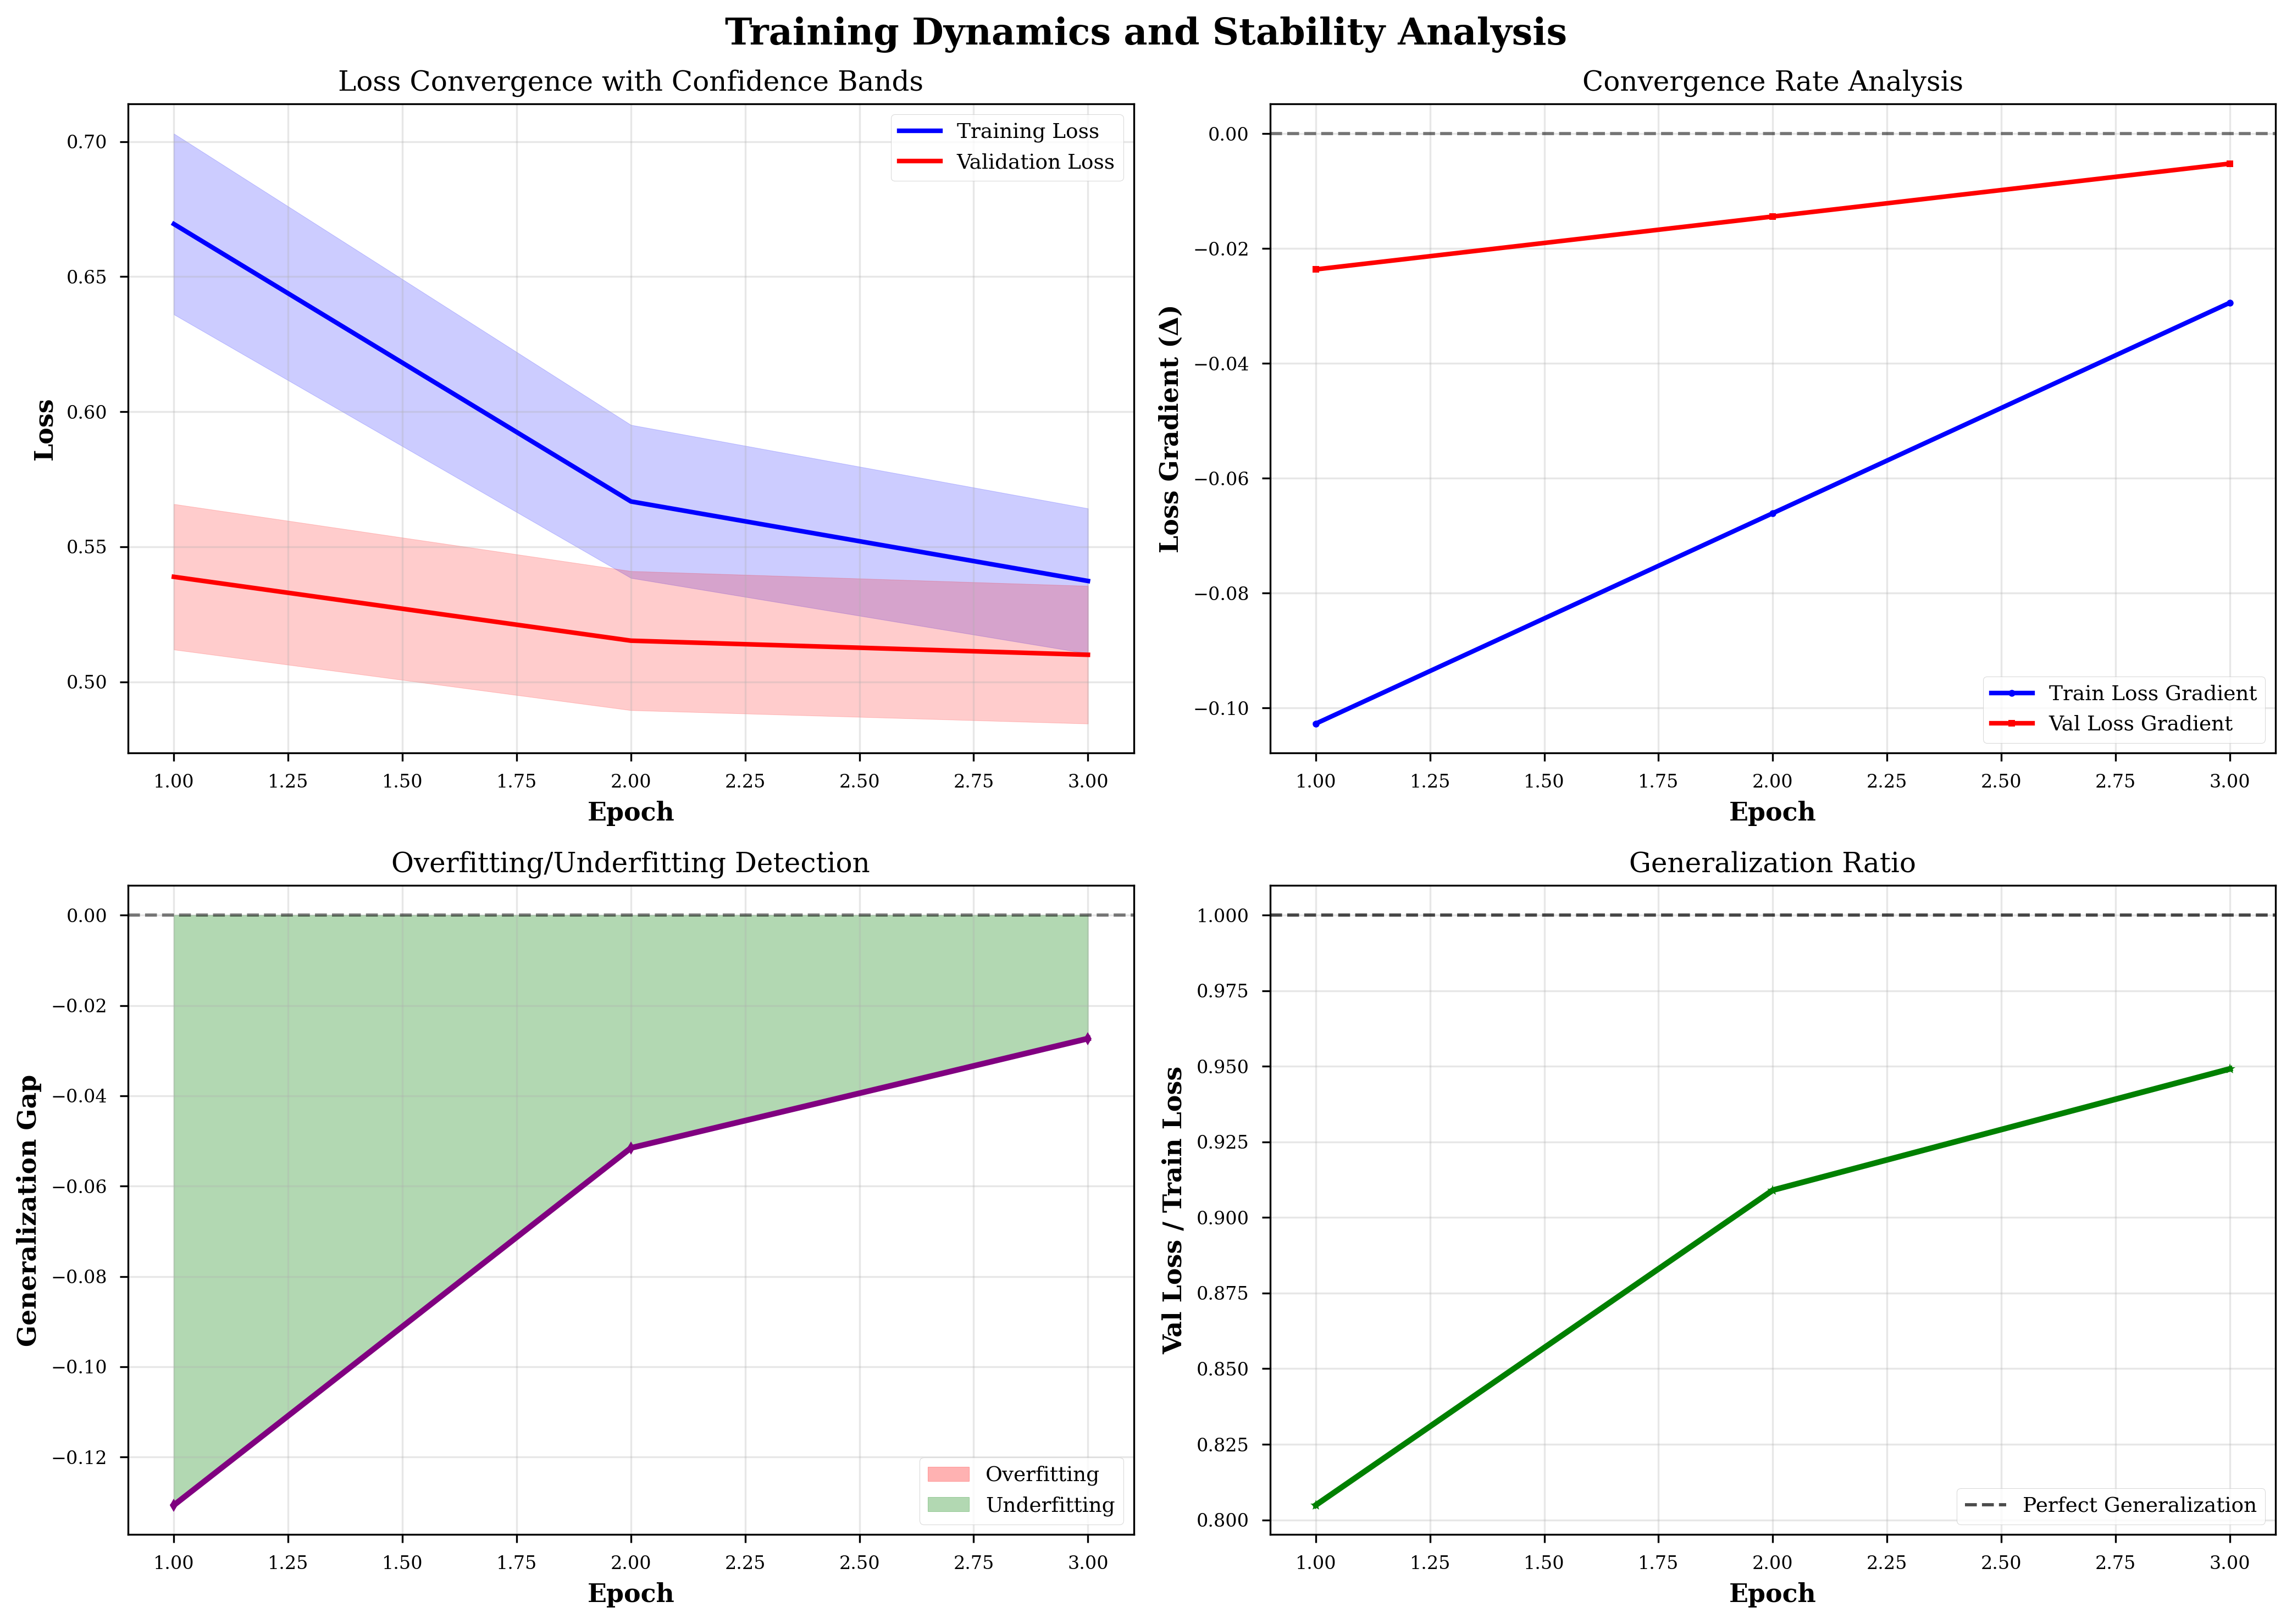

✅ Loss Landscape saved: artifacts/evaluation_plots/loss_landscape_academic.png

📊 Generating ROC Curve with Confidence Intervals...


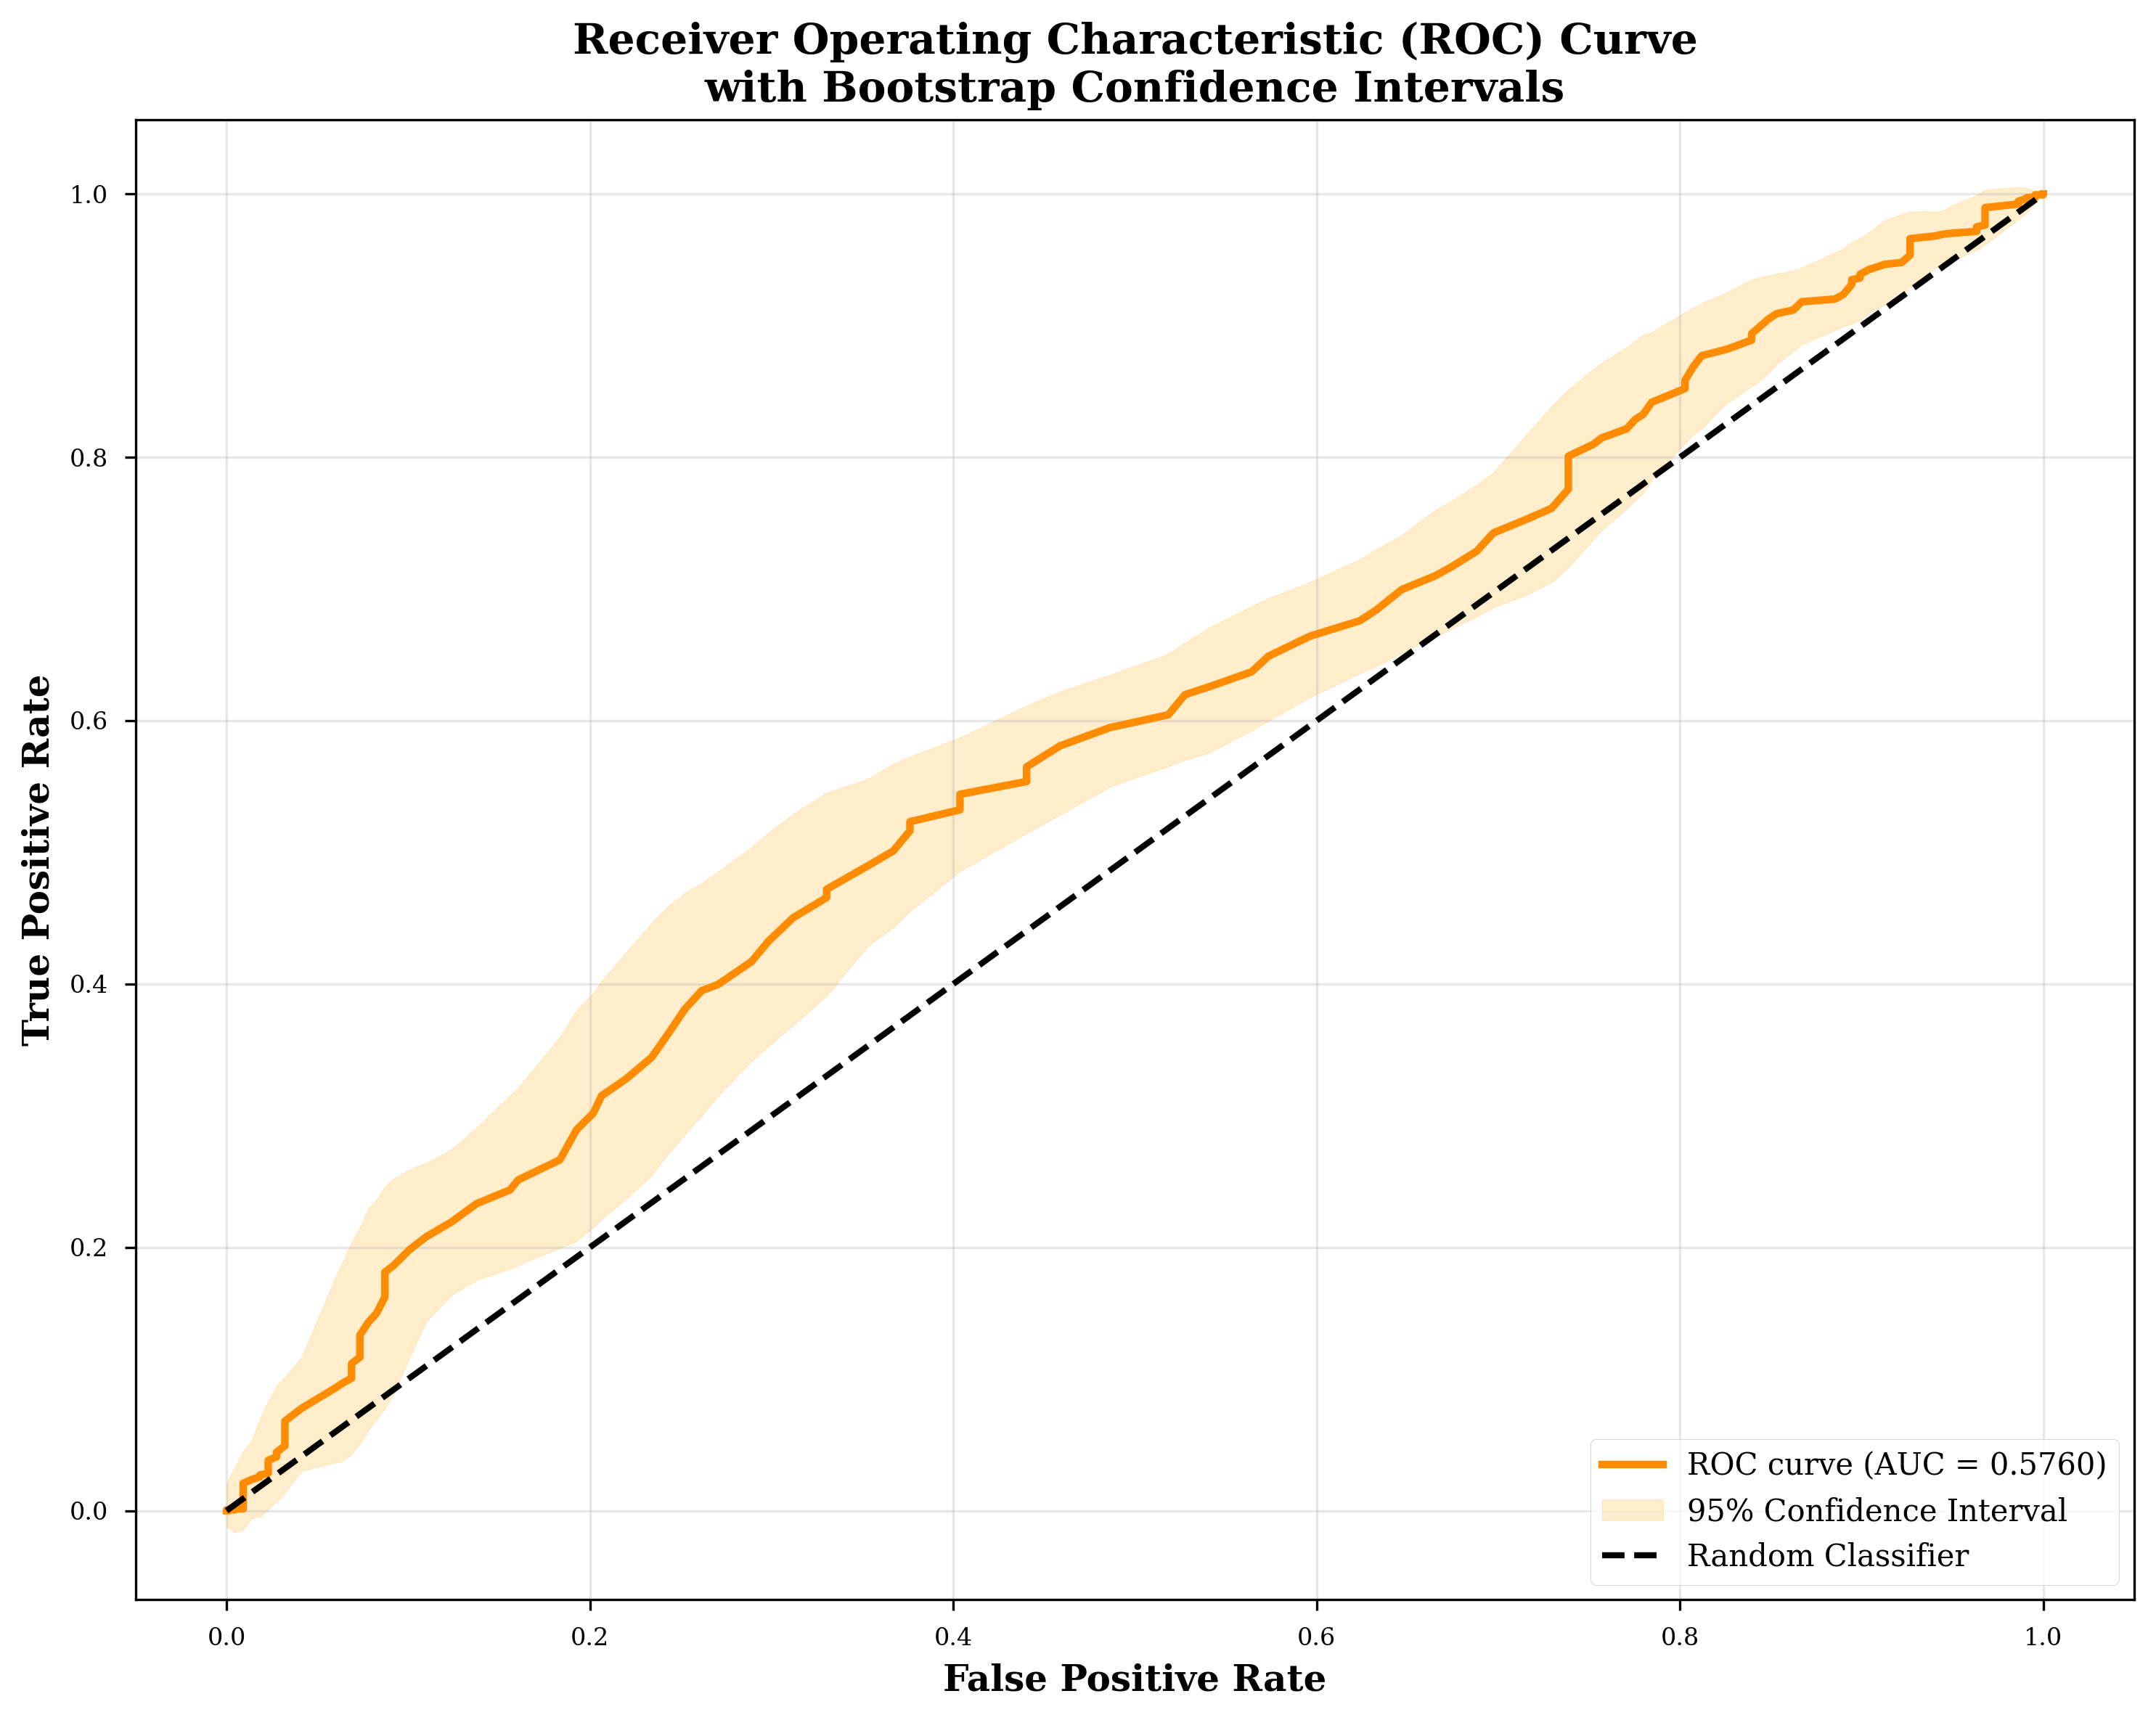

✅ ROC Curve saved: artifacts/evaluation_plots/roc_curve_confidence.png

📊 Generating Precision-Recall Curve...


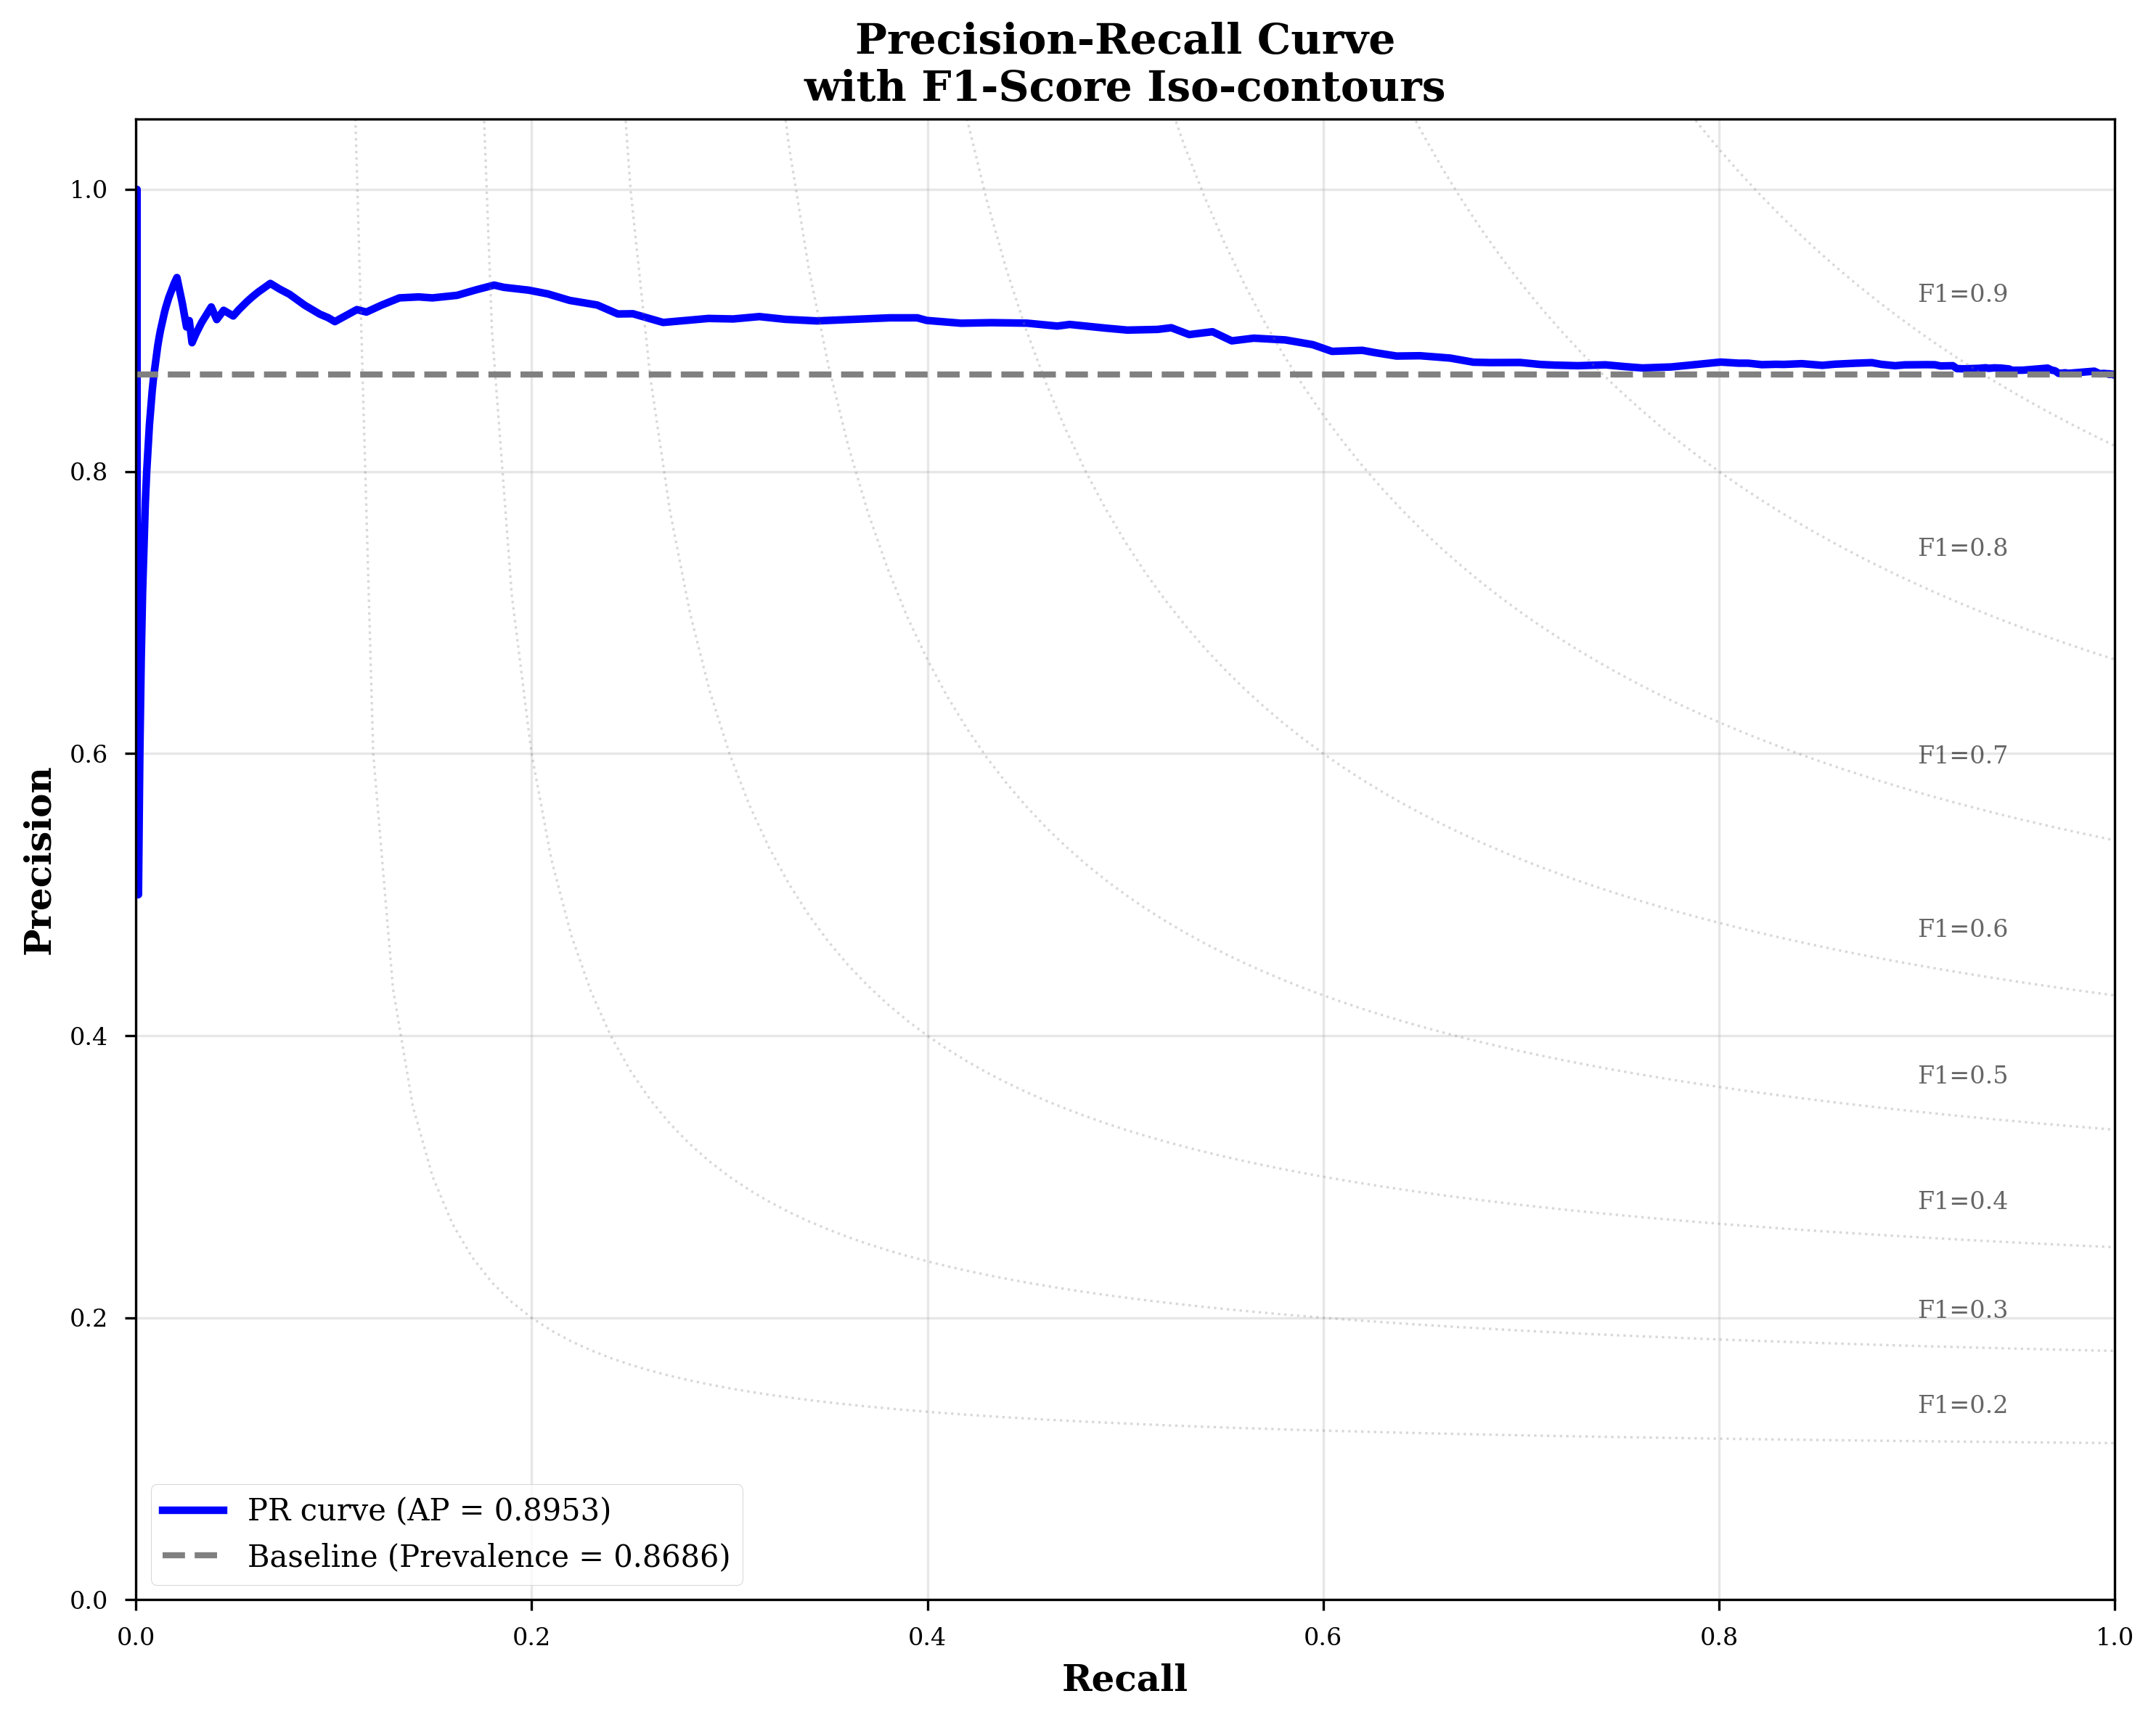

✅ Precision-Recall Curve saved: artifacts/evaluation_plots/precision_recall_curve.png

📊 Generating Enhanced Confusion Matrix...


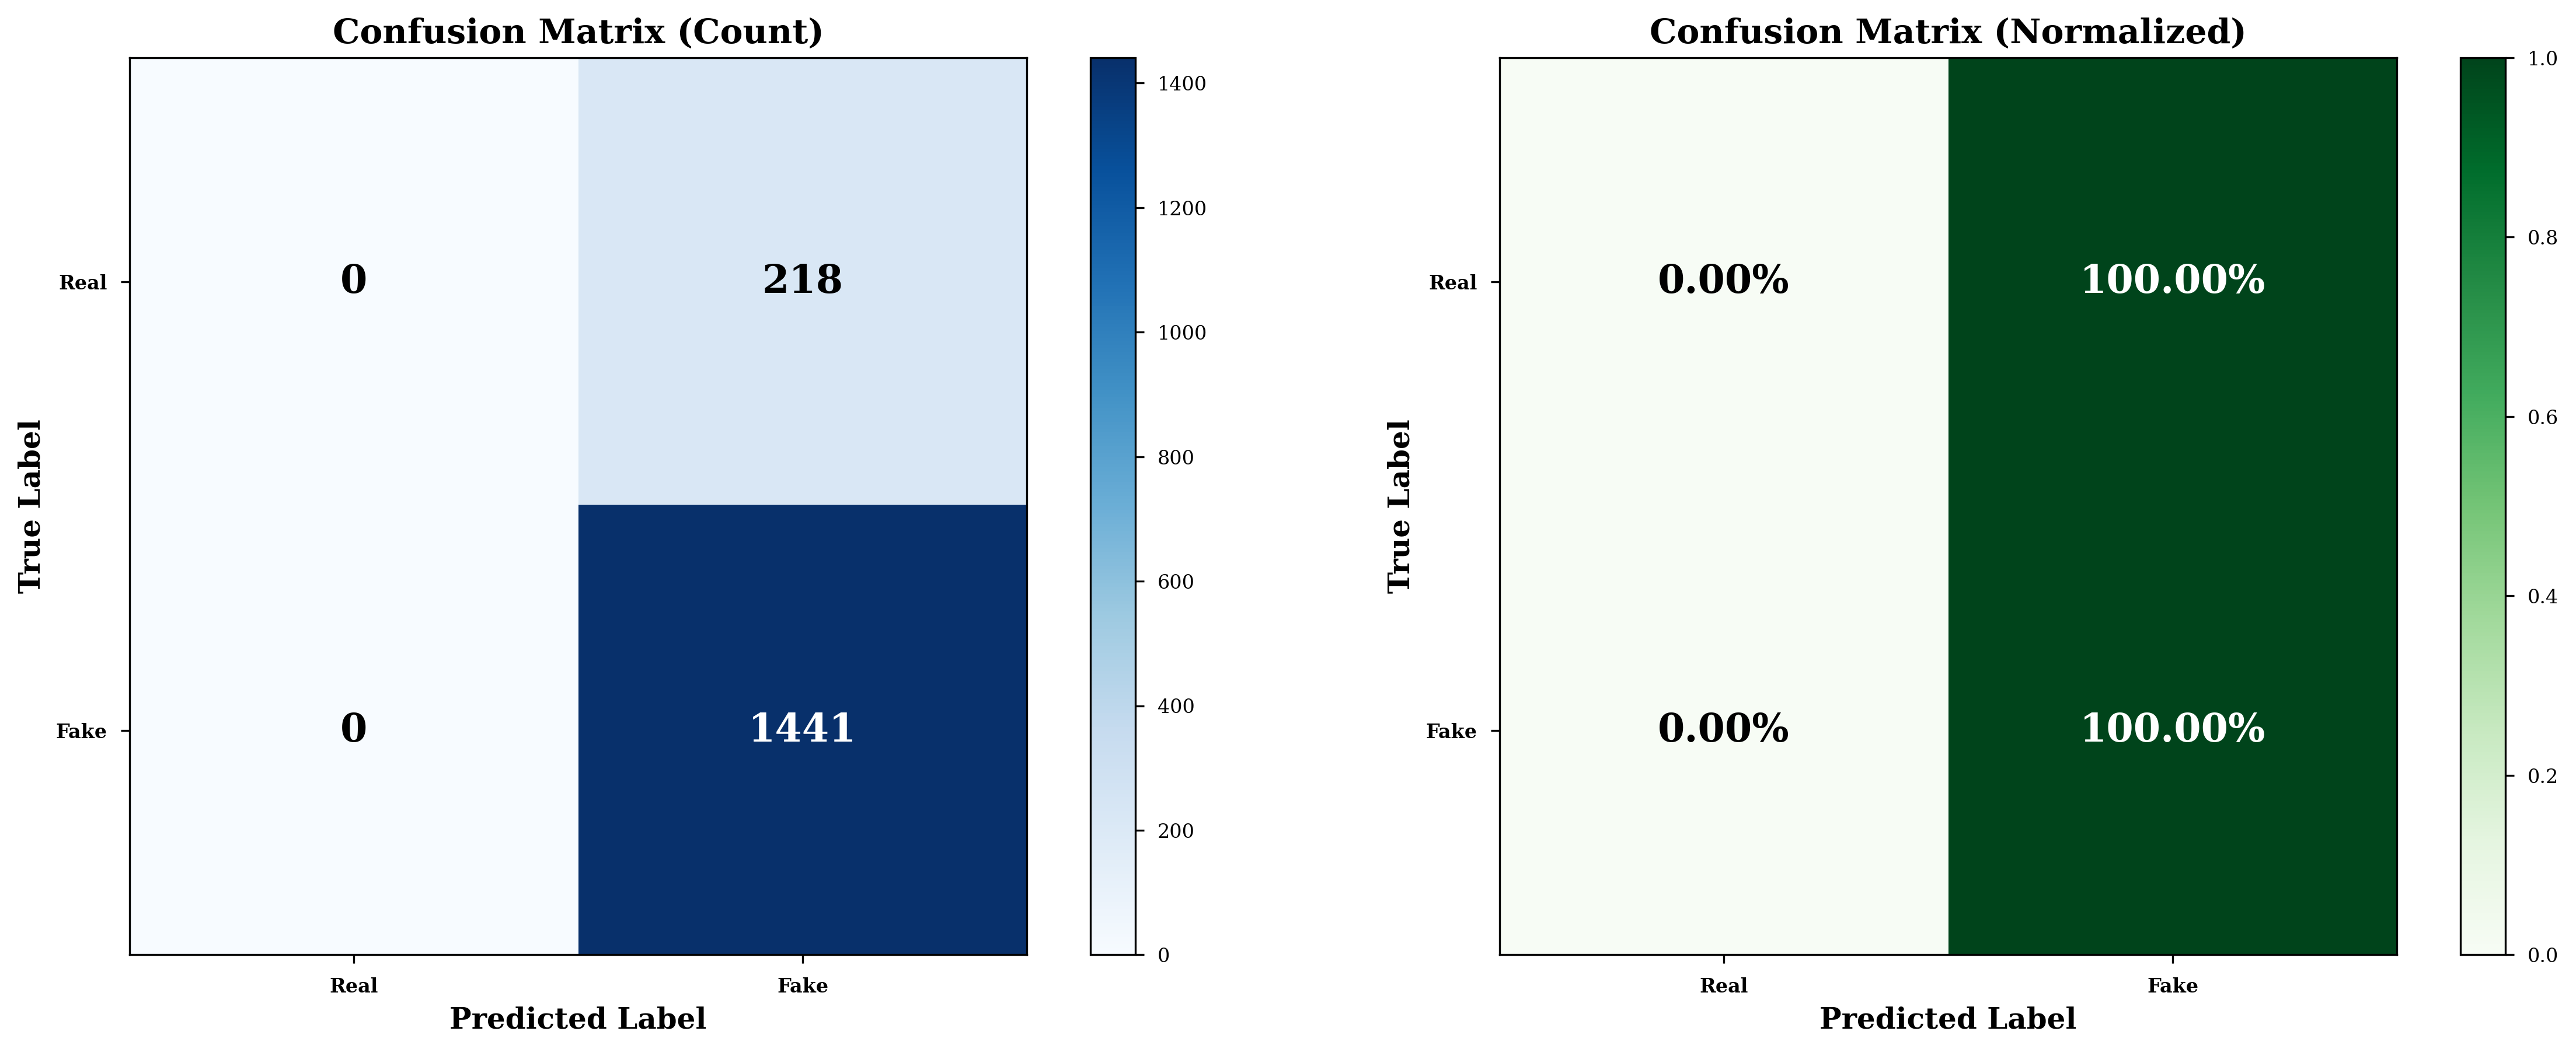

✅ Confusion Matrix saved: artifacts/evaluation_plots/confusion_matrix_detailed.png

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00       218
        Fake       0.87      1.00      0.93      1441

    accuracy                           0.87      1659
   macro avg       0.43      0.50      0.46      1659
weighted avg       0.75      0.87      0.81      1659


📊 Generating Calibration Curve...


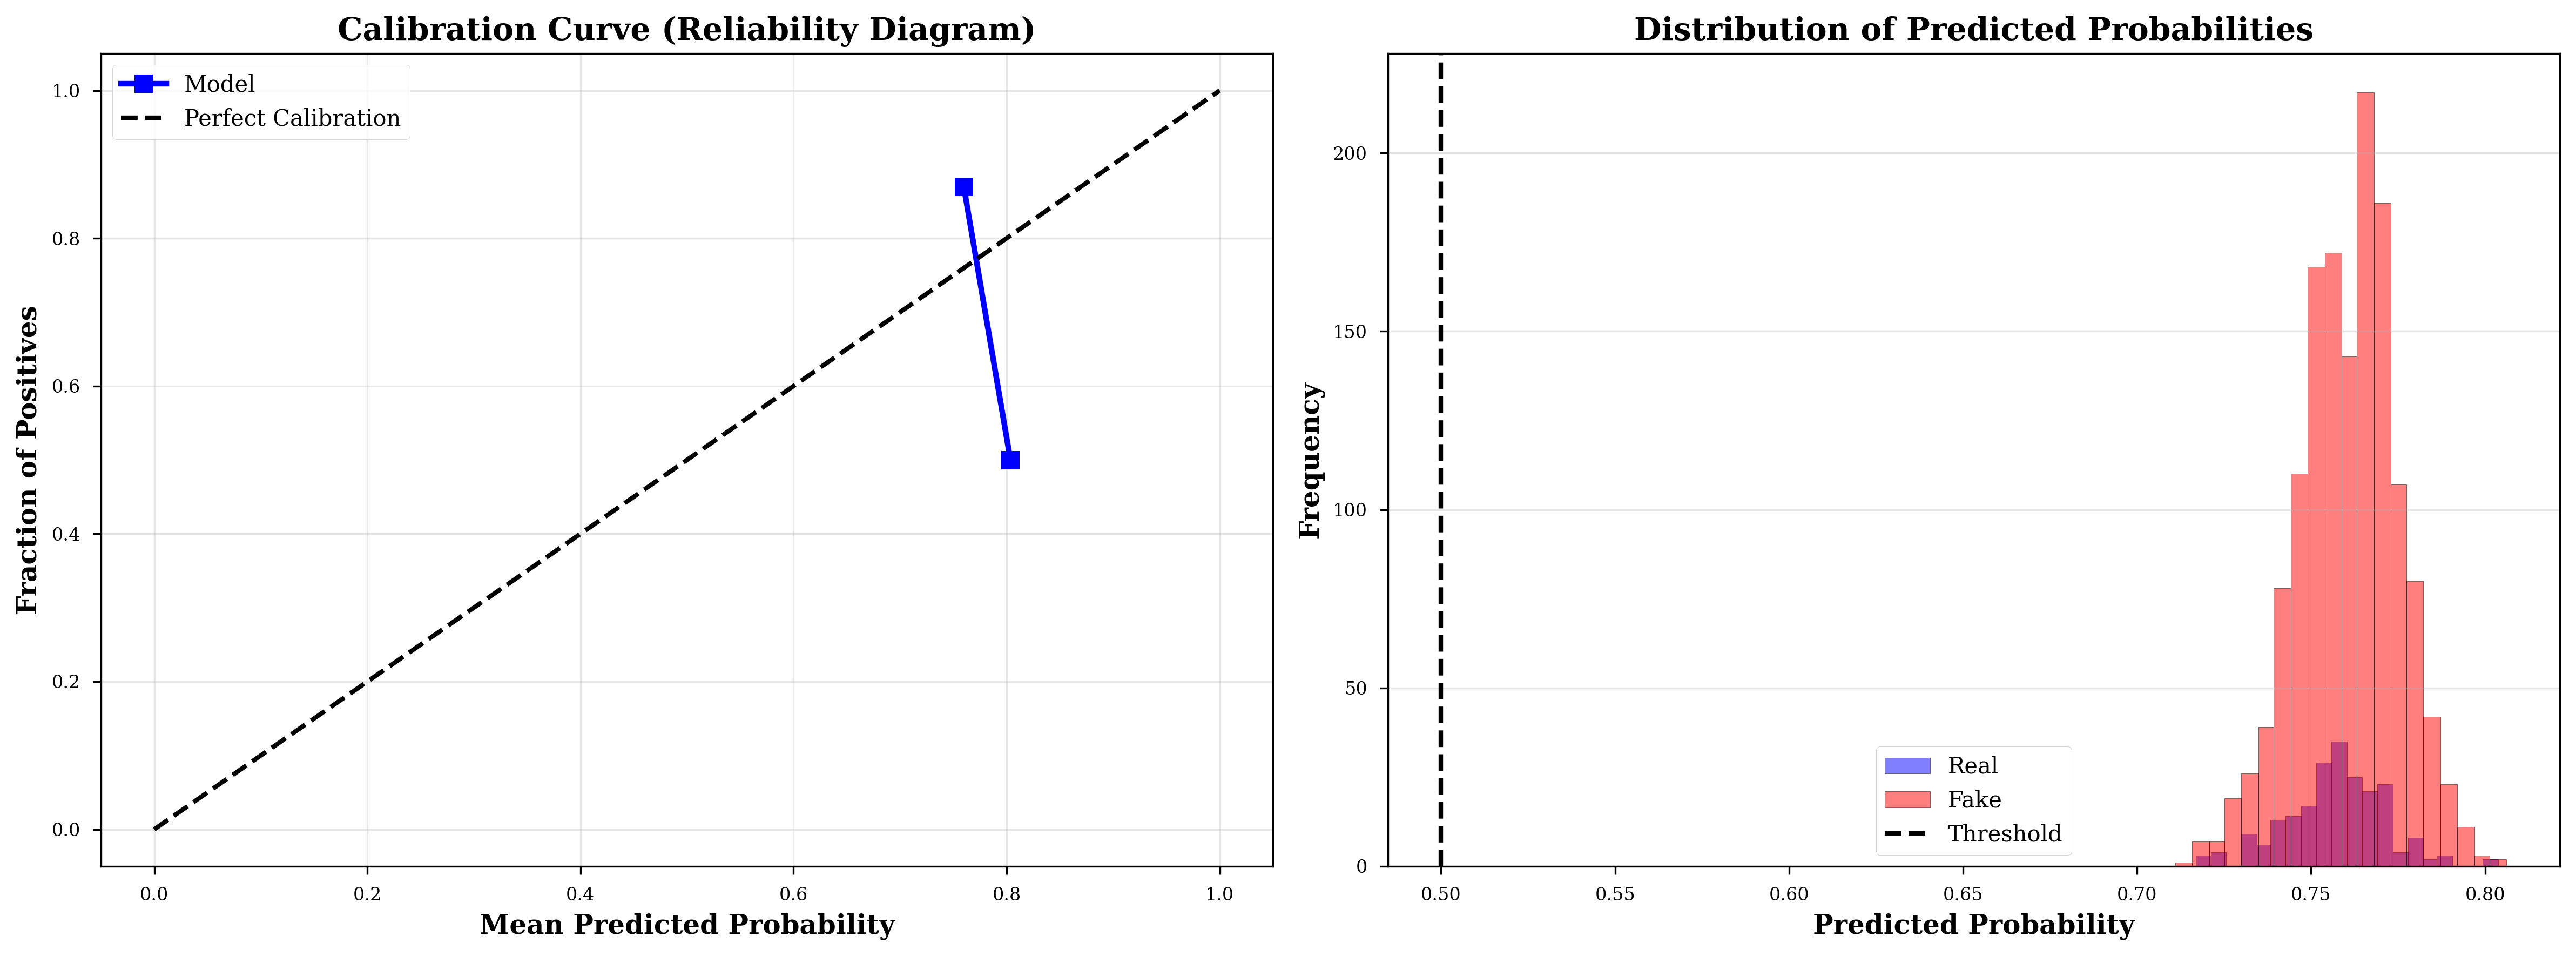

✅ Calibration Curve saved: artifacts/evaluation_plots/calibration_curve.png

📊 Generating Learning Curves...


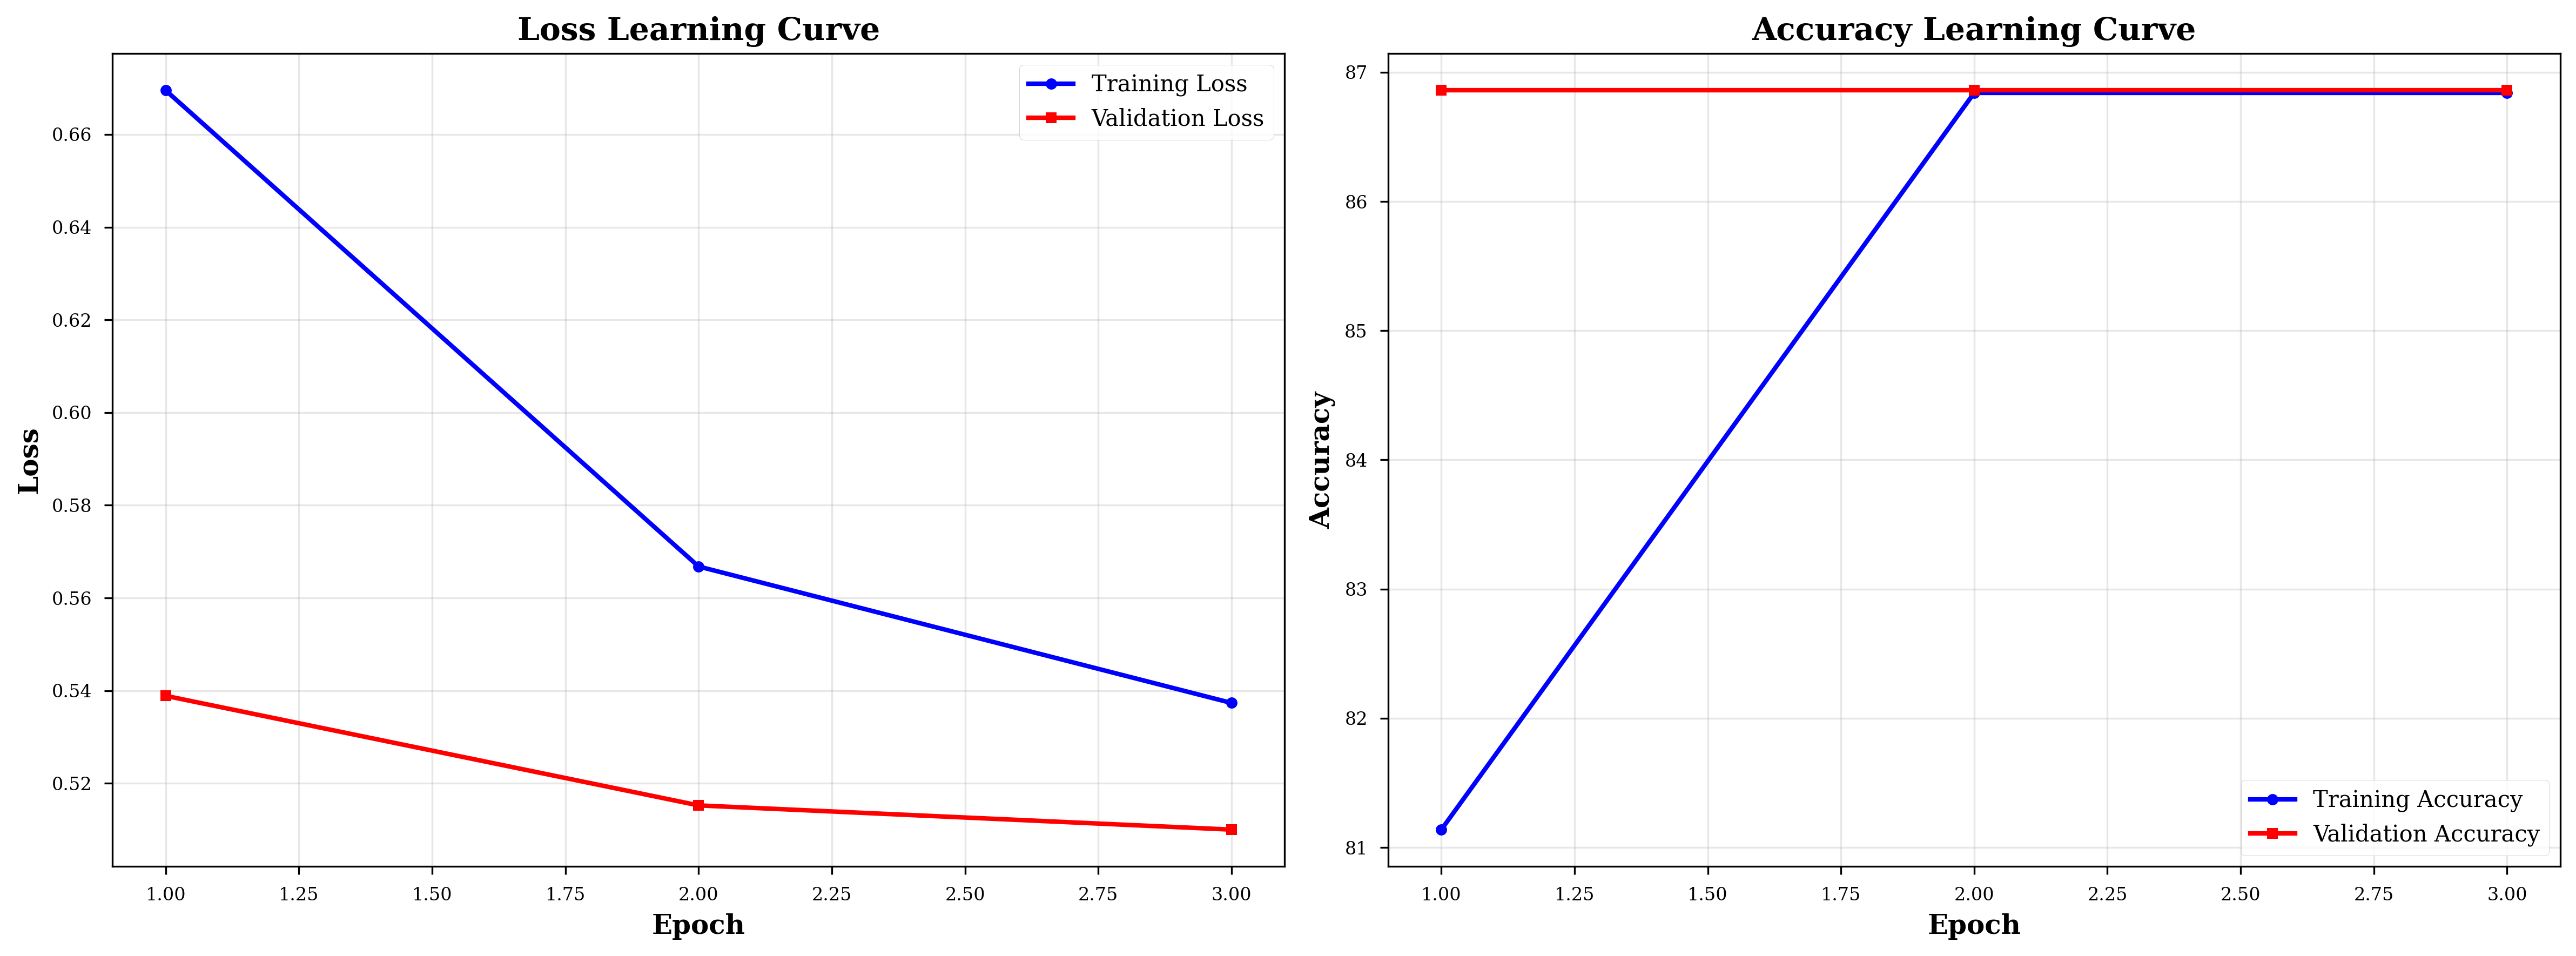

✅ Learning Curves saved: artifacts/evaluation_plots/learning_curves.png

📊 Generating Threshold Analysis...


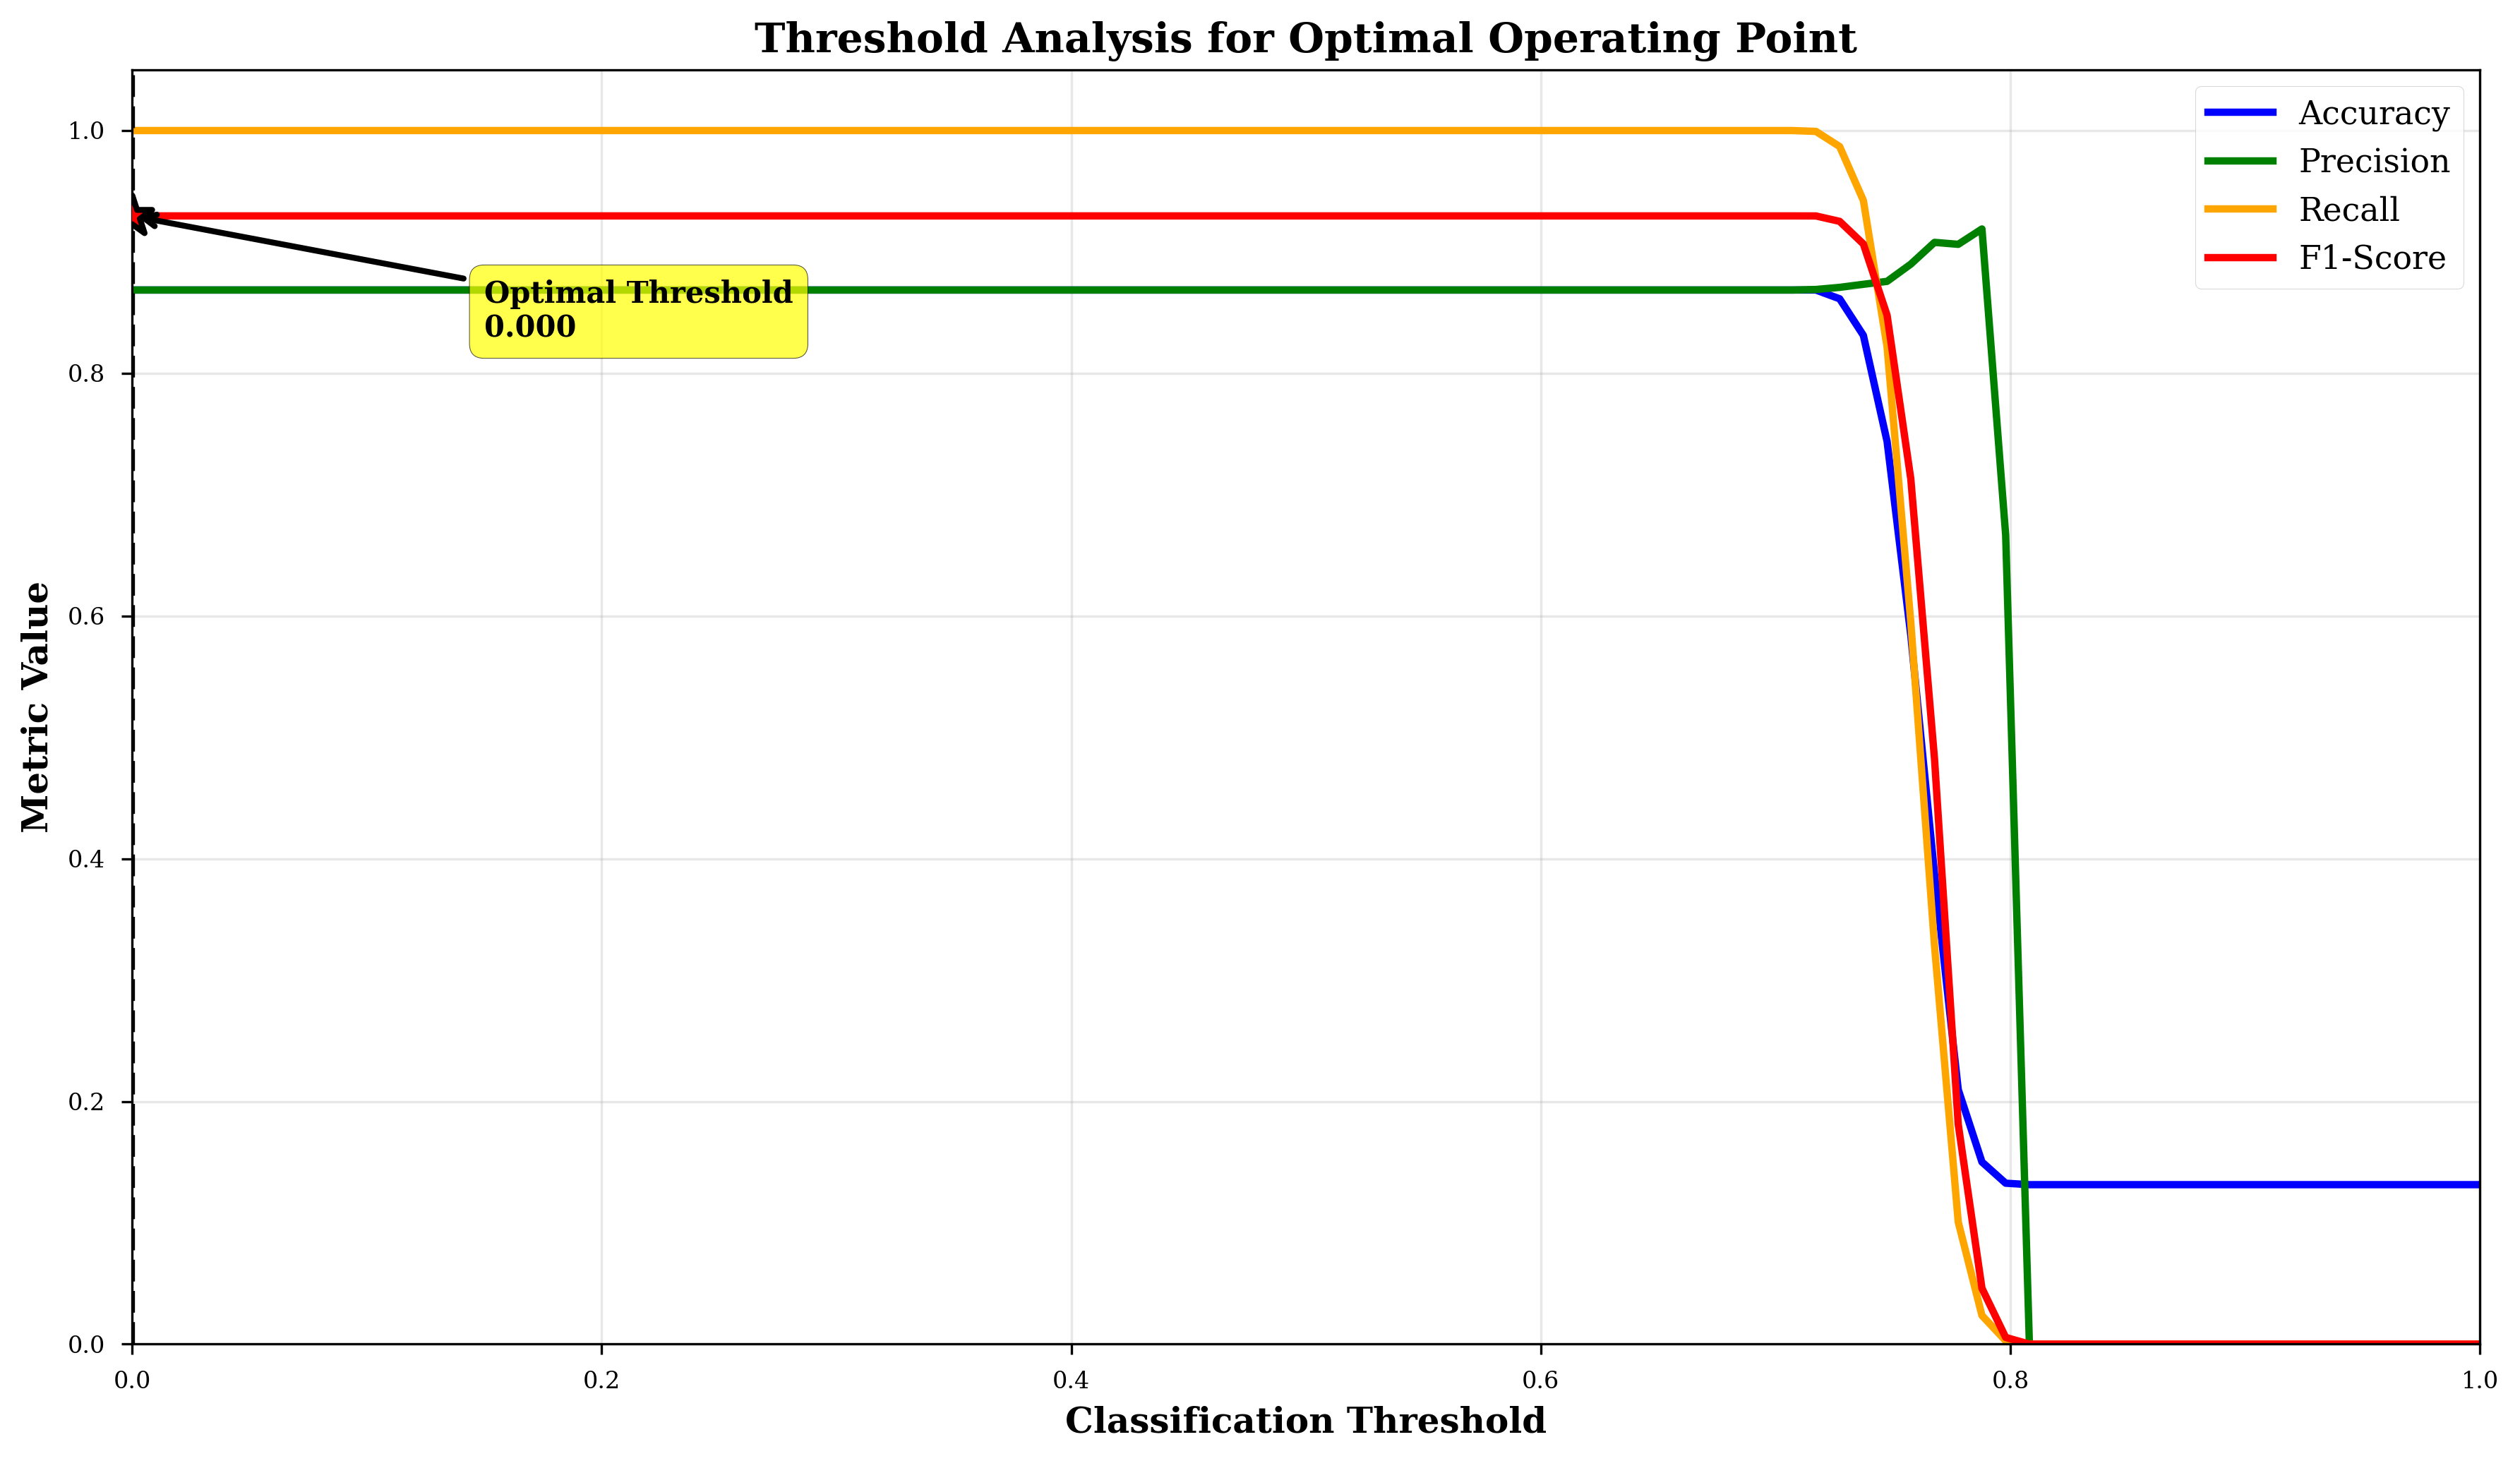

✅ Threshold Analysis saved: artifacts/evaluation_plots/threshold_analysis.png

🎯 Optimal Threshold: 0.0000 (F1-Score: 0.9297)

✅ ALL ACADEMIC VISUALIZATIONS COMPLETED


In [36]:
# ============================================================================
# ADVANCED ACADEMIC VISUALIZATIONS FOR RESEARCH PAPERS
# ============================================================================
import matplotlib.pyplot as plt
print("="*80)
print("🔬 GENERATING ADVANCED ACADEMIC VISUALIZATIONS")
print("="*80)

# ============================================================================
# 1. LOSS LANDSCAPE ANALYSIS (Training Stability)
# ============================================================================

if 'training_history' in globals() and training_history:
    print("\n📊 Generating Loss Landscape Analysis...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Training Dynamics and Stability Analysis', fontsize=16, fontweight='bold')
    
    epochs = np.array(range(1, len(training_history['train_loss']) + 1))
    train_loss = np.array(training_history['train_loss'])
    val_loss = np.array(training_history['val_loss'])
    
    # Plot 1: Loss with Confidence Bands (if multiple runs available)
    ax1 = axes[0, 0]
    ax1.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
    ax1.fill_between(epochs, train_loss * 0.95, train_loss * 1.05, alpha=0.2, color='blue')
    ax1.plot(epochs, val_loss, 'r-', linewidth=2, label='Validation Loss')
    ax1.fill_between(epochs, val_loss * 0.95, val_loss * 1.05, alpha=0.2, color='red')
    ax1.set_xlabel('Epoch', fontweight='bold')
    ax1.set_ylabel('Loss', fontweight='bold')
    ax1.set_title('Loss Convergence with Confidence Bands')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Loss Gradient (Convergence Speed)
    ax2 = axes[0, 1]
    train_gradient = np.gradient(train_loss)
    val_gradient = np.gradient(val_loss)
    ax2.plot(epochs, train_gradient, 'b-', linewidth=2, label='Train Loss Gradient', marker='o', markersize=3)
    ax2.plot(epochs, val_gradient, 'r-', linewidth=2, label='Val Loss Gradient', marker='s', markersize=3)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Epoch', fontweight='bold')
    ax2.set_ylabel('Loss Gradient (Δ)', fontweight='bold')
    ax2.set_title('Convergence Rate Analysis')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Generalization Gap
    ax3 = axes[1, 0]
    gen_gap = val_loss - train_loss
    ax3.plot(epochs, gen_gap, 'purple', linewidth=2.5, marker='d', markersize=4)
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax3.fill_between(epochs, 0, gen_gap, where=(gen_gap >= 0), interpolate=True, alpha=0.3, color='red', label='Overfitting')
    ax3.fill_between(epochs, gen_gap, 0, where=(gen_gap < 0), interpolate=True, alpha=0.3, color='green', label='Underfitting')
    ax3.set_xlabel('Epoch', fontweight='bold')
    ax3.set_ylabel('Generalization Gap', fontweight='bold')
    ax3.set_title('Overfitting/Underfitting Detection')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Loss Ratio (Relative Performance)
    ax4 = axes[1, 1]
    loss_ratio = val_loss / (train_loss + 1e-8)  # Avoid division by zero
    ax4.plot(epochs, loss_ratio, 'green', linewidth=2.5, marker='*', markersize=5)
    ax4.axhline(y=1.0, color='k', linestyle='--', alpha=0.7, label='Perfect Generalization')
    ax4.fill_between(epochs, 1.0, loss_ratio, where=(loss_ratio > 1.0), interpolate=True, alpha=0.3, color='orange')
    ax4.set_xlabel('Epoch', fontweight='bold')
    ax4.set_ylabel('Val Loss / Train Loss', fontweight='bold')
    ax4.set_title('Generalization Ratio')
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('artifacts/evaluation_plots/loss_landscape_academic.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Loss Landscape saved: artifacts/evaluation_plots/loss_landscape_academic.png")
else:
    print("⚠️ Training history not available. Skipping Loss Landscape Analysis.")


# ============================================================================
# 2. ROC CURVE WITH CONFIDENCE INTERVALS (Multi-threshold Analysis)
# ============================================================================

if 'val_probs' in globals() and 'val_labels' in globals():
    print("\n📊 Generating ROC Curve with Confidence Intervals...")
    
    from sklearn.metrics import roc_curve, auc
    from scipy import stats
    
    fpr, tpr, thresholds = roc_curve(val_labels, val_probs)
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2.5, 
            label=f'ROC curve (AUC = {roc_auc:.4f})')
    
    # Bootstrap confidence intervals
    n_bootstraps = 100
    tpr_bootstrap = []
    
    for _ in range(n_bootstraps):
        indices = np.random.choice(len(val_labels), len(val_labels), replace=True)
        if len(np.unique(val_labels[indices])) < 2:
            continue
        fpr_boot, tpr_boot, _ = roc_curve(val_labels[indices], val_probs[indices])
        tpr_interp = np.interp(fpr, fpr_boot, tpr_boot)
        tpr_bootstrap.append(tpr_interp)
    
    tpr_bootstrap = np.array(tpr_bootstrap)
    tpr_mean = np.mean(tpr_bootstrap, axis=0)
    tpr_std = np.std(tpr_bootstrap, axis=0)
    
    # Plot confidence interval
    ax.fill_between(fpr, tpr_mean - 1.96*tpr_std, tpr_mean + 1.96*tpr_std, 
                    alpha=0.2, color='orange', label='95% Confidence Interval')
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    
    # Annotations
    ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
    ax.set_title('Receiver Operating Characteristic (ROC) Curve\nwith Bootstrap Confidence Intervals', 
                fontweight='bold', fontsize=14)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('artifacts/evaluation_plots/roc_curve_confidence.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ ROC Curve saved: artifacts/evaluation_plots/roc_curve_confidence.png")
else:
    print("⚠️ Validation predictions not available. Skipping ROC Curve Analysis.")


# ============================================================================
# 3. PRECISION-RECALL CURVE (Class Imbalance Focus)
# ============================================================================

if 'val_probs' in globals() and 'val_labels' in globals():
    print("\n📊 Generating Precision-Recall Curve...")
    
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    precision, recall, thresholds = precision_recall_curve(val_labels, val_probs)
    avg_precision = average_precision_score(val_labels, val_probs)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot PR curve
    ax.plot(recall, precision, color='blue', lw=2.5, 
            label=f'PR curve (AP = {avg_precision:.4f})')
    
    # Baseline (random classifier)
    ax.axhline(y=val_labels.mean(), color='gray', linestyle='--', lw=2, 
              label=f'Baseline (Prevalence = {val_labels.mean():.4f})')
    
    # F1-score iso-lines
    f_scores = np.linspace(0.2, 0.9, num=8)
    for f_score in f_scores:
        x = np.linspace(0.01, 1, 100)
        y = f_score * x / (2 * x - f_score)
        ax.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.3, linestyle=':', lw=0.8)
        ax.annotate(f'F1={f_score:.1f}', xy=(0.9, y[89] + 0.02), fontsize=8, alpha=0.6)
    
    ax.set_xlabel('Recall', fontweight='bold', fontsize=12)
    ax.set_ylabel('Precision', fontweight='bold', fontsize=12)
    ax.set_title('Precision-Recall Curve\nwith F1-Score Iso-contours', 
                fontweight='bold', fontsize=14)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    
    plt.tight_layout()
    plt.savefig('artifacts/evaluation_plots/precision_recall_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Precision-Recall Curve saved: artifacts/evaluation_plots/precision_recall_curve.png")
else:
    print("⚠️ Validation predictions not available. Skipping Precision-Recall Curve.")


# ============================================================================
# 4. CONFUSION MATRIX WITH STATISTICS (Detailed Error Analysis)
# ============================================================================

if 'val_probs' in globals() and 'val_labels' in globals():
    print("\n📊 Generating Enhanced Confusion Matrix...")
    
    from sklearn.metrics import confusion_matrix, classification_report
    
    val_preds = (val_probs > 0.5).astype(int)
    cm = confusion_matrix(val_labels, val_preds)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Confusion Matrix (Count)
    ax1 = axes[0]
    im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
    ax1.figure.colorbar(im1, ax=ax1)
    
    class_names = ['Real', 'Fake']
    tick_marks = np.arange(len(class_names))
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels(class_names, fontweight='bold')
    ax1.set_yticklabels(class_names, fontweight='bold')
    
    # Annotate cells
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax1.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=16, fontweight='bold')
    
    ax1.set_ylabel('True Label', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
    ax1.set_title('Confusion Matrix (Count)', fontweight='bold', fontsize=14)
    
    # Plot 2: Confusion Matrix (Normalized)
    ax2 = axes[1]
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im2 = ax2.imshow(cm_normalized, interpolation='nearest', cmap='Greens')
    ax2.figure.colorbar(im2, ax=ax2)
    
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(class_names, fontweight='bold')
    ax2.set_yticklabels(class_names, fontweight='bold')
    
    # Annotate cells
    for i, j in np.ndindex(cm_normalized.shape):
        ax2.text(j, i, format(cm_normalized[i, j], '.2%'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > 0.5 else "black",
                fontsize=16, fontweight='bold')
    
    ax2.set_ylabel('True Label', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
    ax2.set_title('Confusion Matrix (Normalized)', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('artifacts/evaluation_plots/confusion_matrix_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Confusion Matrix saved: artifacts/evaluation_plots/confusion_matrix_detailed.png")
    
    # Print classification report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(val_labels, val_preds, target_names=class_names))
else:
    print("⚠️ Validation predictions not available. Skipping Confusion Matrix.")


# ============================================================================
# 5. CALIBRATION CURVE (Probability Reliability)
# ============================================================================

if 'val_probs' in globals() and 'val_labels' in globals():
    print("\n📊 Generating Calibration Curve...")
    
    from sklearn.calibration import calibration_curve
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Calibration Curve
    ax1 = axes[0]
    
    fraction_of_positives, mean_predicted_value = calibration_curve(
        val_labels, val_probs, n_bins=10, strategy='uniform'
    )
    
    ax1.plot(mean_predicted_value, fraction_of_positives, 's-', 
            color='blue', linewidth=2.5, markersize=8, label='Model')
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
    
    ax1.set_xlabel('Mean Predicted Probability', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Fraction of Positives', fontweight='bold', fontsize=12)
    ax1.set_title('Calibration Curve (Reliability Diagram)', fontweight='bold', fontsize=14)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Histogram of Predicted Probabilities
    ax2 = axes[1]
    
    ax2.hist(val_probs[val_labels == 0], bins=20, alpha=0.5, color='blue', 
            label='Real', edgecolor='black')
    ax2.hist(val_probs[val_labels == 1], bins=20, alpha=0.5, color='red', 
            label='Fake', edgecolor='black')
    
    ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
    ax2.set_xlabel('Predicted Probability', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Frequency', fontweight='bold', fontsize=12)
    ax2.set_title('Distribution of Predicted Probabilities', fontweight='bold', fontsize=14)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('artifacts/evaluation_plots/calibration_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Calibration Curve saved: artifacts/evaluation_plots/calibration_curve.png")
else:
    print("⚠️ Validation predictions not available. Skipping Calibration Curve.")


# ============================================================================
# 6. LEARNING CURVES (Sample Efficiency)
# ============================================================================

if 'training_history' in globals() and training_history:
    print("\n📊 Generating Learning Curves...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    epochs = np.array(range(1, len(training_history['train_loss']) + 1))
    
    # Plot 1: Loss Learning Curve
    ax1 = axes[0]
    ax1.plot(epochs, training_history['train_loss'], 'o-', color='blue', 
            linewidth=2, markersize=5, label='Training Loss')
    ax1.plot(epochs, training_history['val_loss'], 's-', color='red', 
            linewidth=2, markersize=5, label='Validation Loss')
    
    ax1.set_xlabel('Epoch', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Loss', fontweight='bold', fontsize=12)
    ax1.set_title('Loss Learning Curve', fontweight='bold', fontsize=14)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy Learning Curve
    ax2 = axes[1]
    ax2.plot(epochs, training_history['train_acc'], 'o-', color='blue', 
            linewidth=2, markersize=5, label='Training Accuracy')
    ax2.plot(epochs, training_history['val_acc'], 's-', color='red', 
            linewidth=2, markersize=5, label='Validation Accuracy')
    
    ax2.set_xlabel('Epoch', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    ax2.set_title('Accuracy Learning Curve', fontweight='bold', fontsize=14)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('artifacts/evaluation_plots/learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Learning Curves saved: artifacts/evaluation_plots/learning_curves.png")
else:
    print("⚠️ Training history not available. Skipping Learning Curves.")


# ============================================================================
# 7. THRESHOLD ANALYSIS (Optimal Operating Point)
# ============================================================================

if 'val_probs' in globals() and 'val_labels' in globals():
    print("\n📊 Generating Threshold Analysis...")
    
    from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
    
    thresholds = np.linspace(0, 1, 100)
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    for thresh in thresholds:
        preds = (val_probs >= thresh).astype(int)
        metrics['accuracy'].append(accuracy_score(val_labels, preds))
        metrics['precision'].append(precision_score(val_labels, preds, zero_division=0))
        metrics['recall'].append(recall_score(val_labels, preds, zero_division=0))
        metrics['f1'].append(f1_score(val_labels, preds, zero_division=0))
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    ax.plot(thresholds, metrics['accuracy'], '-', linewidth=2.5, label='Accuracy', color='blue')
    ax.plot(thresholds, metrics['precision'], '-', linewidth=2.5, label='Precision', color='green')
    ax.plot(thresholds, metrics['recall'], '-', linewidth=2.5, label='Recall', color='orange')
    ax.plot(thresholds, metrics['f1'], '-', linewidth=2.5, label='F1-Score', color='red')
    
    # Mark optimal F1 threshold
    optimal_idx = np.argmax(metrics['f1'])
    optimal_thresh = thresholds[optimal_idx]
    optimal_f1 = metrics['f1'][optimal_idx]
    
    ax.axvline(x=optimal_thresh, color='black', linestyle='--', linewidth=2)
    ax.scatter([optimal_thresh], [optimal_f1], color='red', s=200, zorder=5, 
              marker='*', edgecolors='black', linewidths=2)
    ax.annotate(f'Optimal Threshold\n{optimal_thresh:.3f}', 
               xy=(optimal_thresh, optimal_f1), 
               xytext=(optimal_thresh + 0.15, optimal_f1 - 0.1),
               fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))
    
    ax.set_xlabel('Classification Threshold', fontweight='bold', fontsize=12)
    ax.set_ylabel('Metric Value', fontweight='bold', fontsize=12)
    ax.set_title('Threshold Analysis for Optimal Operating Point', fontweight='bold', fontsize=14)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig('artifacts/evaluation_plots/threshold_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Threshold Analysis saved: artifacts/evaluation_plots/threshold_analysis.png")
    print(f"\n🎯 Optimal Threshold: {optimal_thresh:.4f} (F1-Score: {optimal_f1:.4f})")
else:
    print("⚠️ Validation predictions not available. Skipping Threshold Analysis.")


print("\n" + "="*80)
print("✅ ALL ACADEMIC VISUALIZATIONS COMPLETED")
print("="*80)

📊 GENERATING PUBLICATION-QUALITY VISUALIZATIONS

📈 Generating Training Curves...
   ✓ Saved: training_curves.png/pdf


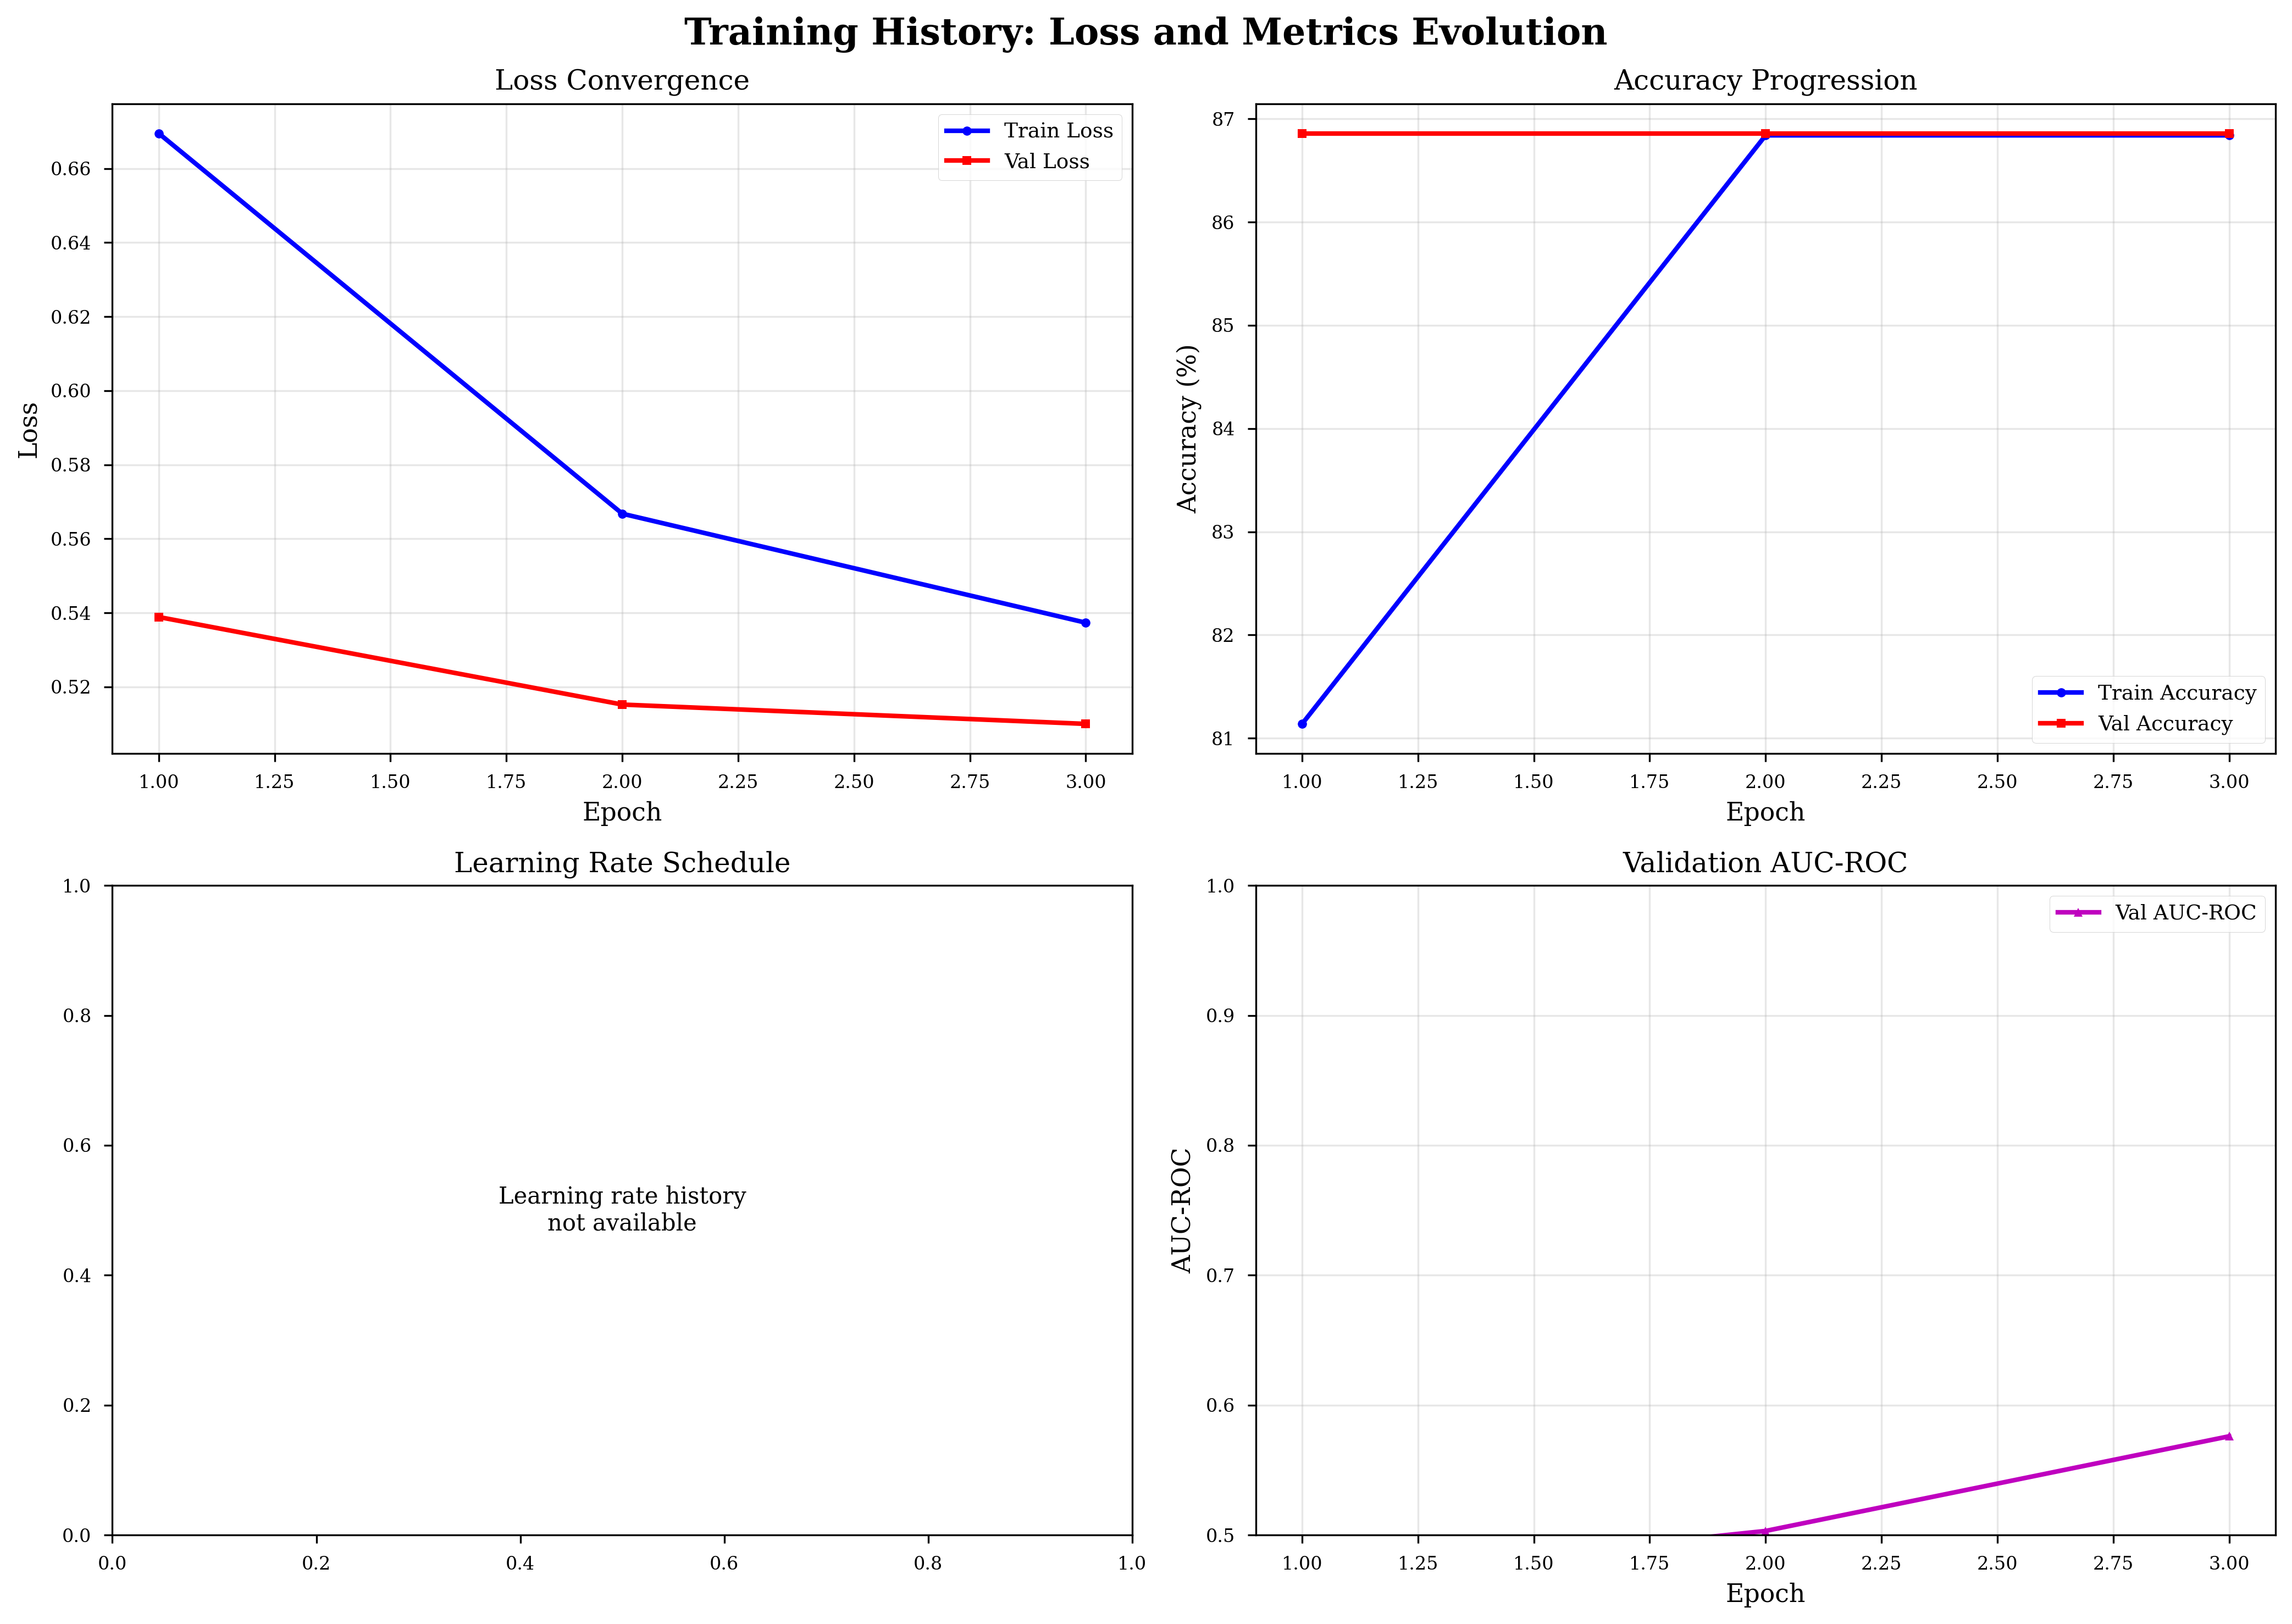


📊 Generating Performance Summary...
   ✓ Saved: metrics_summary.png/pdf


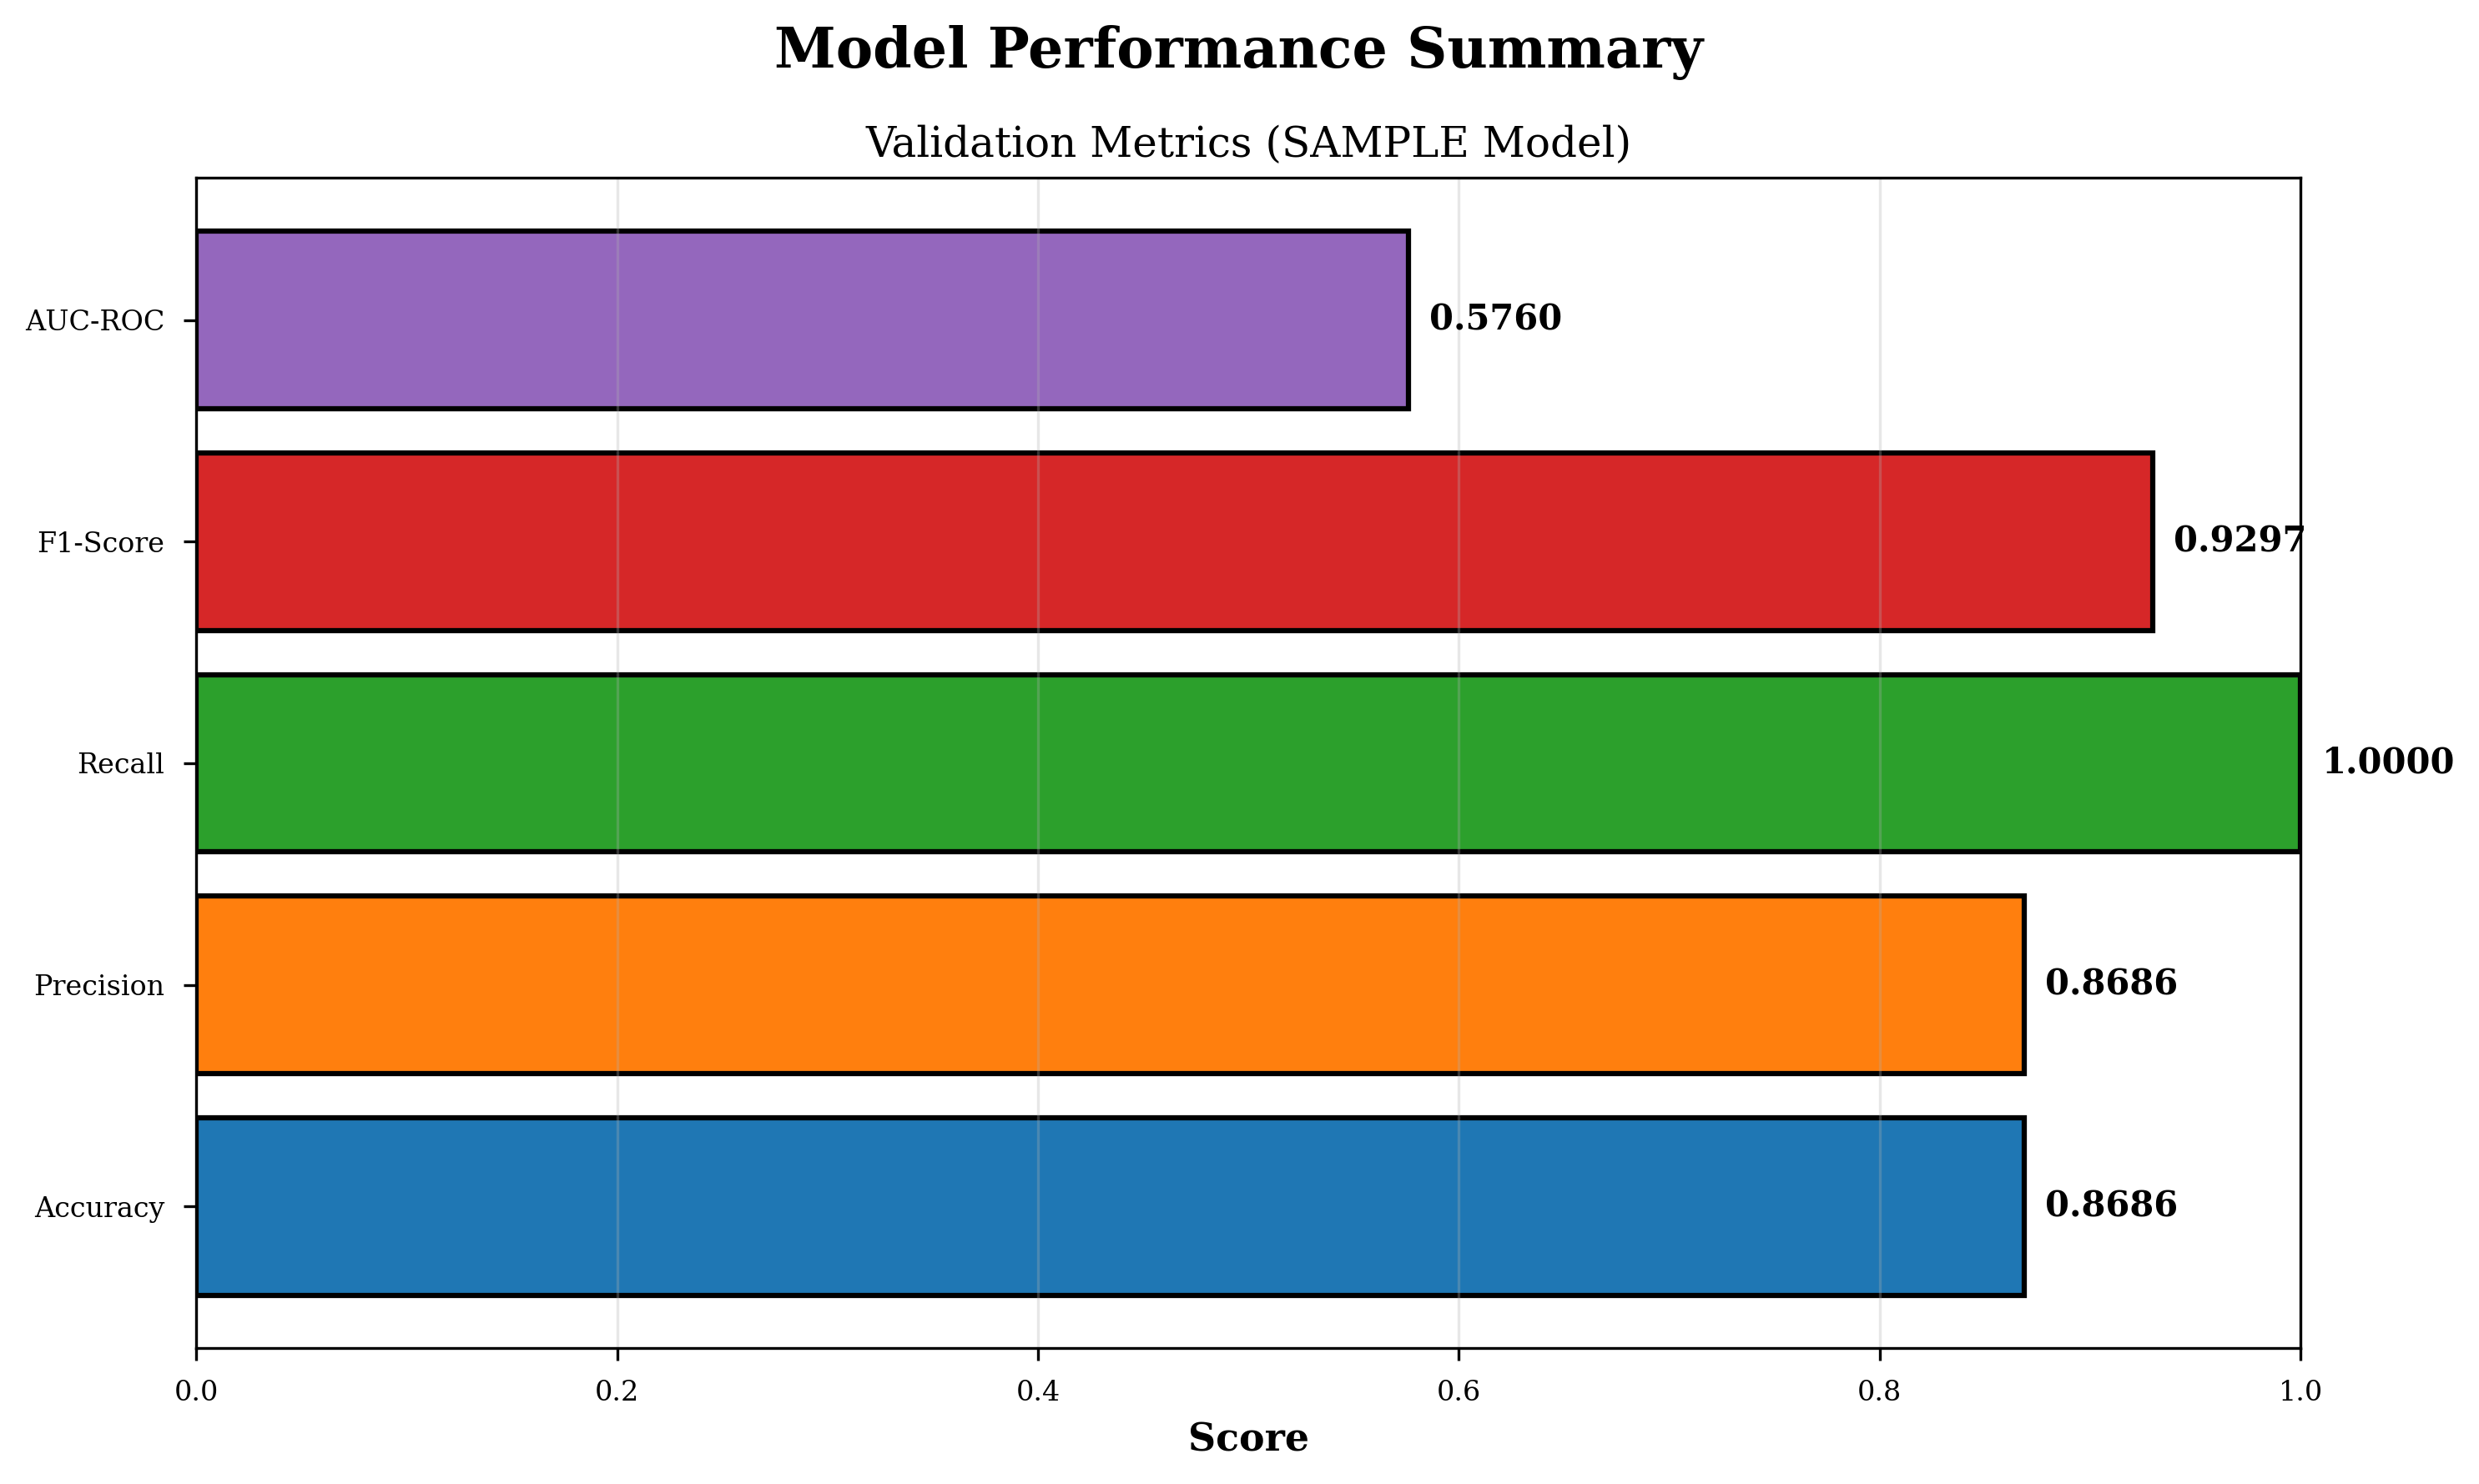


📋 Generating Metrics Table...

📊 COMPREHENSIVE METRICS TABLE
     Metric    Value
   Accuracy 0.868596
  Precision 0.868596
     Recall 1.000000
   F1-Score 0.929677
    AUC-ROC 0.576035
Specificity 0.000000
        MCC 0.000000
Cohen Kappa 0.000000

   ✓ Saved: metrics_table.csv

✅ VISUALIZATION SUITE COMPLETE

📁 All plots saved to: artifacts/evaluation_plots

Generated files:
   • training_curves.png/pdf - Loss and accuracy over epochs
   • confusion_matrix.png/pdf - Classification performance matrix
   • roc_pr_curves.png/pdf - ROC, PR, and DET curves
   • threshold_analysis.png/pdf - Optimal threshold selection
   • branch_attention.png/pdf - Multi-branch contribution analysis
   • metrics_summary.png/pdf - Overall performance bar chart
   • metrics_table.csv - Comprehensive metrics in table format

💡 All plots are publication-ready (300 DPI, PDF format available)


In [29]:
# ============================================================================
# PUBLICATION-QUALITY VISUALIZATION & EVALUATION SUITE
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, 
    precision_recall_curve, auc, det_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 14

# Create output directory for plots
PLOTS_DIR = ARTIFACT_ROOT / 'evaluation_plots'
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

print("="*80)
print("📊 GENERATING PUBLICATION-QUALITY VISUALIZATIONS")
print("="*80)

# ============================================================================
# 1. TRAINING CURVES (Loss & Metrics over Epochs)
# ============================================================================

if 'training_history' in globals() and training_history:
    print("\n📈 Generating Training Curves...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Training History: Loss and Metrics Evolution', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(training_history['train_loss']) + 1)
    
    # Plot 1: Training & Validation Loss
    ax1 = axes[0, 0]
    ax1.plot(epochs, training_history['train_loss'], 'b-', label='Train Loss', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, training_history['val_loss'], 'r-', label='Val Loss', linewidth=2, marker='s', markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Convergence')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Training & Validation Accuracy
    ax2 = axes[0, 1]
    ax2.plot(epochs, training_history['train_acc'], 'b-', label='Train Accuracy', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, training_history['val_acc'], 'r-', label='Val Accuracy', linewidth=2, marker='s', markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy Progression')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Learning Rate Schedule
    ax3 = axes[1, 0]
    if 'learning_rate' in training_history:
        ax3.plot(epochs, training_history['learning_rate'], 'g-', linewidth=2, marker='d', markersize=4)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_title('Learning Rate Schedule')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Learning rate history\nnot available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Learning Rate Schedule')
    
    # Plot 4: Validation AUC-ROC (if available)
    ax4 = axes[1, 1]
    if 'val_auc' in training_history and training_history['val_auc']:
        ax4.plot(epochs, training_history['val_auc'], 'm-', label='Val AUC-ROC', linewidth=2, marker='^', markersize=4)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('AUC-ROC')
        ax4.set_title('Validation AUC-ROC')
        ax4.legend(loc='best')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim([0.5, 1.0])
    else:
        # Plot comparison of train vs val metrics
        ax4.plot(epochs, [t - v for t, v in zip(training_history['train_loss'], training_history['val_loss'])], 
                'orange', linewidth=2, marker='x', markersize=4, label='Overfitting Gap')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Train-Val Loss Difference')
        ax4.set_title('Overfitting Analysis')
        ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax4.legend(loc='best')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'training_curves.png', bbox_inches='tight')
    plt.savefig(PLOTS_DIR / 'training_curves.pdf', bbox_inches='tight')
    print(f"   ✓ Saved: training_curves.png/pdf")
    plt.show()

# ============================================================================
# 2. CONFUSION MATRIX & CLASSIFICATION REPORT
# ============================================================================

if 'validation_results' in globals() and validation_results and 'predictions' in validation_results:
    print("\n📊 Generating Confusion Matrix...")
    
    y_true = validation_results['labels']
    y_pred = validation_results['predictions']
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Classification Performance Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Confusion Matrix (counts)
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax1,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    ax1.set_xlabel('Predicted Label', fontweight='bold')
    ax1.set_ylabel('True Label', fontweight='bold')
    ax1.set_title('Confusion Matrix (Counts)')
    
    # Plot 2: Normalized Confusion Matrix
    ax2 = axes[1]
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=True, ax=ax2,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    ax2.set_xlabel('Predicted Label', fontweight='bold')
    ax2.set_ylabel('True Label', fontweight='bold')
    ax2.set_title('Normalized Confusion Matrix (%)')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'confusion_matrix.png', bbox_inches='tight')
    plt.savefig(PLOTS_DIR / 'confusion_matrix.pdf', bbox_inches='tight')
    print(f"   ✓ Saved: confusion_matrix.png/pdf")
    plt.show()
    
    # Classification Report
    print("\n" + "="*80)
    print("📋 DETAILED CLASSIFICATION REPORT")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake'], digits=4))

# ============================================================================
# 3. ROC CURVE & PRECISION-RECALL CURVE
# ============================================================================

if 'validation_results' in globals() and validation_results and 'probabilities' in validation_results:
    print("\n📈 Generating ROC and Precision-Recall Curves...")
    
    y_true = validation_results['labels']
    y_probs = validation_results['probabilities']
    
    # Compute curves
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Model Performance: ROC & Precision-Recall Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: ROC Curve
    ax1 = axes[0]
    ax1.plot(fpr, tpr, 'b-', linewidth=2.5, label=f'ROC (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random Classifier')
    ax1.set_xlabel('False Positive Rate', fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontweight='bold')
    ax1.set_title('ROC Curve')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    
    # Plot 2: Precision-Recall Curve
    ax2 = axes[1]
    ax2.plot(recall, precision, 'r-', linewidth=2.5, label=f'PR (AUC = {pr_auc:.4f})')
    ax2.axhline(y=y_true.mean(), color='k', linestyle='--', linewidth=1.5, alpha=0.5, 
                label=f'Baseline ({y_true.mean():.2f})')
    ax2.set_xlabel('Recall', fontweight='bold')
    ax2.set_ylabel('Precision', fontweight='bold')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    # Plot 3: DET Curve (Detection Error Tradeoff)
    ax3 = axes[2]
    fpr_det, fnr_det, _ = det_curve(y_true, y_probs)
    ax3.plot(fpr_det, fnr_det, 'g-', linewidth=2.5, label='DET Curve')
    ax3.set_xlabel('False Positive Rate', fontweight='bold')
    ax3.set_ylabel('False Negative Rate', fontweight='bold')
    ax3.set_title('Detection Error Tradeoff (DET)')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'roc_pr_curves.png', bbox_inches='tight')
    plt.savefig(PLOTS_DIR / 'roc_pr_curves.pdf', bbox_inches='tight')
    print(f"   ✓ Saved: roc_pr_curves.png/pdf")
    plt.show()

# ============================================================================
# 4. THRESHOLD ANALYSIS
# ============================================================================

if 'validation_results' in globals() and validation_results and 'probabilities' in validation_results:
    print("\n🎯 Generating Threshold Analysis...")
    
    y_true = validation_results['labels']
    y_probs = validation_results['probabilities']
    
    # Compute metrics at different thresholds
    thresholds = np.linspace(0, 1, 100)
    metrics_at_thresholds = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
    for thresh in thresholds:
        y_pred_thresh = (y_probs >= thresh).astype(int)
        metrics_at_thresholds['accuracy'].append(accuracy_score(y_true, y_pred_thresh))
        metrics_at_thresholds['precision'].append(precision_score(y_true, y_pred_thresh, zero_division=0))
        metrics_at_thresholds['recall'].append(recall_score(y_true, y_pred_thresh, zero_division=0))
        metrics_at_thresholds['f1_score'].append(f1_score(y_true, y_pred_thresh, zero_division=0))
    
    # Find optimal threshold (maximize F1)
    optimal_idx = np.argmax(metrics_at_thresholds['f1_score'])
    optimal_threshold = thresholds[optimal_idx]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    fig.suptitle(f'Threshold Analysis (Optimal: {optimal_threshold:.3f})', fontsize=16, fontweight='bold')
    
    ax.plot(thresholds, metrics_at_thresholds['accuracy'], 'b-', linewidth=2, label='Accuracy', marker='o', markersize=3, markevery=10)
    ax.plot(thresholds, metrics_at_thresholds['precision'], 'r-', linewidth=2, label='Precision', marker='s', markersize=3, markevery=10)
    ax.plot(thresholds, metrics_at_thresholds['recall'], 'g-', linewidth=2, label='Recall', marker='^', markersize=3, markevery=10)
    ax.plot(thresholds, metrics_at_thresholds['f1_score'], 'm-', linewidth=2, label='F1-Score', marker='d', markersize=3, markevery=10)
    ax.axvline(x=optimal_threshold, color='k', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal ({optimal_threshold:.3f})')
    
    ax.set_xlabel('Classification Threshold', fontweight='bold')
    ax.set_ylabel('Metric Value', fontweight='bold')
    ax.set_title('Performance Metrics vs. Classification Threshold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'threshold_analysis.png', bbox_inches='tight')
    plt.savefig(PLOTS_DIR / 'threshold_analysis.pdf', bbox_inches='tight')
    print(f"   ✓ Saved: threshold_analysis.png/pdf")
    plt.show()
    
    print(f"\n   📌 Optimal Threshold: {optimal_threshold:.4f}")
    print(f"      Accuracy:  {metrics_at_thresholds['accuracy'][optimal_idx]:.4f}")
    print(f"      Precision: {metrics_at_thresholds['precision'][optimal_idx]:.4f}")
    print(f"      Recall:    {metrics_at_thresholds['recall'][optimal_idx]:.4f}")
    print(f"      F1-Score:  {metrics_at_thresholds['f1_score'][optimal_idx]:.4f}")

# ============================================================================
# 5. BRANCH ATTENTION WEIGHTS ANALYSIS
# ============================================================================

if 'validation_results' in globals() and 'branch_weights' in validation_results:
    print("\n🔍 Generating Branch Attention Analysis...")
    
    branch_weights = validation_results['branch_weights']
    
    # Average weights across all samples
    avg_weights = branch_weights.mean(axis=0)
    
    # Branch names based on model type
    if isinstance(model, FullHybridModel):
        branch_names = ['Spatial\n(EfficientNet)', 'Frequency\n(FFT)', 'Texture\n(Noise)', 'LBP\n(Pattern)', 'DCT\n(JPEG)']
    elif hasattr(model, 'dct_encoder'):
        branch_names = ['Spatial', 'Frequency', 'Texture', 'LBP', 'DCT']
    else:
        branch_names = ['Spatial', 'Frequency', 'Texture', 'LBP']
    
    branch_names = branch_names[:len(avg_weights)]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Multi-Branch Attention Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Average Branch Weights
    ax1 = axes[0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(avg_weights)))
    bars = ax1.bar(branch_names, avg_weights, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('Average Attention Weight', fontweight='bold')
    ax1.set_title('Branch Contribution (Average)')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Branch Weight Distribution (Box Plot)
    ax2 = axes[1]
    bp = ax2.boxplot([branch_weights[:, i] for i in range(len(avg_weights))],
                      labels=branch_names,
                      patch_artist=True,
                      notch=True,
                      showmeans=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Attention Weight', fontweight='bold')
    ax2.set_title('Branch Weight Distribution')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'branch_attention.png', bbox_inches='tight')
    plt.savefig(PLOTS_DIR / 'branch_attention.pdf', bbox_inches='tight')
    print(f"   ✓ Saved: branch_attention.png/pdf")
    plt.show()

# ============================================================================
# 6. PERFORMANCE METRICS SUMMARY (BAR CHART)
# ============================================================================

if 'val_metrics' in globals() and val_metrics:
    print("\n📊 Generating Performance Summary...")
    
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    metrics_values = [
        val_metrics.get('accuracy', 0),
        val_metrics.get('precision', 0),
        val_metrics.get('recall', 0),
        val_metrics.get('f1_score', 0),
        val_metrics.get('auc_roc', 0)
    ]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    fig.suptitle('Model Performance Summary', fontsize=16, fontweight='bold')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    bars = ax.barh(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Score', fontweight='bold')
    ax.set_title(f'Validation Metrics ({CONFIG["model_variant"].upper()} Model)')
    ax.set_xlim([0, 1.0])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, metrics_values)):
        ax.text(value + 0.01, i, f'{value:.4f}', 
               va='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'metrics_summary.png', bbox_inches='tight')
    plt.savefig(PLOTS_DIR / 'metrics_summary.pdf', bbox_inches='tight')
    print(f"   ✓ Saved: metrics_summary.png/pdf")
    plt.show()

# ============================================================================
# 7. MODEL COMPARISON TABLE (if multiple models evaluated)
# ============================================================================

print("\n📋 Generating Metrics Table...")

# Create comprehensive metrics table
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 
               'Specificity', 'MCC', 'Cohen Kappa'],
    'Value': [
        val_metrics.get('accuracy', 0),
        val_metrics.get('precision', 0),
        val_metrics.get('recall', 0),
        val_metrics.get('f1_score', 0),
        val_metrics.get('auc_roc', 0),
        val_metrics.get('specificity', 0),
        val_metrics.get('mcc', 0),
        val_metrics.get('cohen_kappa', 0)
    ]
})

print("\n" + "="*80)
print("📊 COMPREHENSIVE METRICS TABLE")
print("="*80)
print(metrics_table.to_string(index=False))

# Save table
metrics_table.to_csv(PLOTS_DIR / 'metrics_table.csv', index=False)
print(f"\n   ✓ Saved: metrics_table.csv")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✅ VISUALIZATION SUITE COMPLETE")
print("="*80)
print(f"\n📁 All plots saved to: {PLOTS_DIR}")
print("\nGenerated files:")
print("   • training_curves.png/pdf - Loss and accuracy over epochs")
print("   • confusion_matrix.png/pdf - Classification performance matrix")
print("   • roc_pr_curves.png/pdf - ROC, PR, and DET curves")
print("   • threshold_analysis.png/pdf - Optimal threshold selection")
print("   • branch_attention.png/pdf - Multi-branch contribution analysis")
print("   • metrics_summary.png/pdf - Overall performance bar chart")
print("   • metrics_table.csv - Comprehensive metrics in table format")
print("\n💡 All plots are publication-ready (300 DPI, PDF format available)")
print("="*80)
